<a href="https://www.kaggle.com/code/w1ndness/data-analysis-07-lstm?scriptVersionId=109148764" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/electrical-energy-load/test/1.csv
/kaggle/input/electrical-energy-load/test/3.csv
/kaggle/input/electrical-energy-load/test/.pdf
/kaggle/input/electrical-energy-load/test/2-1.csv
/kaggle/input/electrical-energy-load/test/2-2.csv
/kaggle/input/electrical-energy-load/train/1.csv
/kaggle/input/electrical-energy-load/train/3.csv
/kaggle/input/electrical-energy-load/train/2.csv


In [2]:
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
!nvidia-smi

Wed Oct 26 05:05:22 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Question 1

In [4]:
!rm -f model*

In [5]:
train_data = pd.read_csv('/kaggle/input/electrical-energy-load/train/1.csv')
test_data = pd.read_csv('/kaggle/input/electrical-energy-load/test/1.csv', encoding='gb2312')

In [6]:
train_data.head()

,数据时间,总有功功率（kw）
0,2018/1/1 00:00:00,244033.7682
1,2018/1/1 00:15:00,232720.6402
2,2018/1/1 00:30:00,231685.6891
3,2018/1/1 00:45:00,227581.3317
4,2018/1/1 01:00:00,233482.4269


In [7]:
train_data.columns = ['Date', 'Power']
train_data.head()

,Date,Power
0,2018/1/1 00:00:00,244033.7682
1,2018/1/1 00:15:00,232720.6402
2,2018/1/1 00:30:00,231685.6891
3,2018/1/1 00:45:00,227581.3317
4,2018/1/1 01:00:00,233482.4269


In [8]:
train_data.shape

(128156, 2)

In [9]:
train_data['Date'] = pd.to_datetime(train_data['Date'])
grouper = pd.Grouper(key='Date', freq='15min')
train_data = train_data.groupby(grouper).first()
train_data.head()

,Power
Date,
2018-01-01 00:00:00,244033.7682
2018-01-01 00:15:00,232720.6402
2018-01-01 00:30:00,231685.6891
2018-01-01 00:45:00,227581.3317
2018-01-01 01:00:00,233482.4269


In [10]:
train_data.shape

(128544, 1)

In [11]:
train_data.isnull().sum()

Power    388
dtype: int64

In [12]:
train_data['Power'] = train_data['Power'].interpolate()
train_data.isnull().sum()

Power    0
dtype: int64

In [13]:
train_data.to_csv('15min_freq.csv')

<AxesSubplot:xlabel='Date', ylabel='Power'>

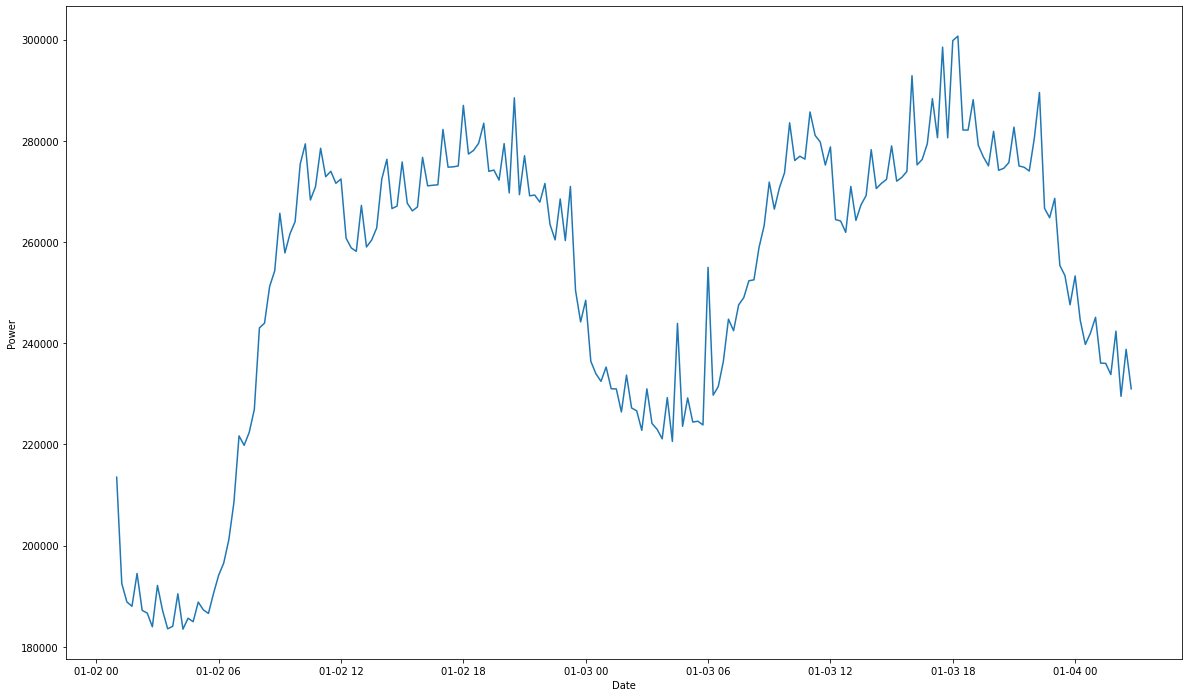

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(20, 12))
sns.lineplot(data=train_data[100:300], x='Date', y='Power', ax=ax)

In [15]:
def split_dataset(data, train_size=.8, valid_size=.1):
    data_size = len(data)
    X_train = data[:int(data_size * train_size)]
    X_valid = data[int(data_size * train_size):int(data_size * train_size) + int(data_size * valid_size)]
    X_test = data[int(data_size * train_size) + int(data_size * valid_size):]
    return X_train, X_valid, X_test

In [16]:
train_bin, valid_bin, test_bin = split_dataset(train_data)

In [17]:
from sklearn.preprocessing import MinMaxScaler

train_scaler = MinMaxScaler()
valid_scaler = MinMaxScaler()
test_scaler = MinMaxScaler()

train_bin = train_scaler.fit_transform(train_bin)
valid_bin = valid_scaler.fit_transform(valid_bin)
test_bin = test_scaler.fit_transform(test_bin)

In [18]:
import torch
from torch.utils.data import DataLoader, TensorDataset

def preprocessing(data, window_size, predict_size):
    X, y = [], []
    for i in range(len(data) - window_size - predict_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size:i + window_size + predict_size].ravel())
    X = torch.FloatTensor(np.array(X))
    y = torch.FloatTensor(np.array(y))
    return X, y

In [19]:
window_size, predict_size = 96, 1

X_train, y_train = preprocessing(train_bin, window_size, predict_size)
X_valid, y_valid = preprocessing(valid_bin, window_size, predict_size)
X_test, y_test = preprocessing(test_bin, window_size, predict_size)

train_data = TensorDataset(X_train, y_train)
valid_data = TensorDataset(X_valid, y_valid)
test_data = TensorDataset(X_test, y_test)

In [20]:
X_train.shape, X_valid.shape, X_test.shape

(torch.Size([102738, 96, 1]),
 torch.Size([12757, 96, 1]),
 torch.Size([12758, 96, 1]))

In [21]:
USE_MULTI_GPU = False

if USE_MULTI_GPU and torch.cuda.device_count() > 1:
    MULTI_GPU = True
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = "0, 1"
    device_ids = [0, 1]
else:
    MULTI_GPU = False

num_gpus = 2 if MULTI_GPU else 1    
    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [22]:
batch_size = 128
train_loader = DataLoader(train_data, batch_size=batch_size * num_gpus,
                          shuffle=True, num_workers=2,
                          drop_last=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size * num_gpus,
                          shuffle=True, num_workers=2,
                          drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size * num_gpus,
                          shuffle=True, num_workers=2,
                          drop_last=True)

In [23]:
from torch import nn
from torch.nn import functional as F

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size,
                 num_layers, output_size, batch_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.batch_size = batch_size
        self.num_directions = 1
        self.lstm = nn.LSTM(self.input_size, self.hidden_size,
                            self.num_layers, batch_first=True)
        self.linear = nn.Linear(self.hidden_size, self.output_size)
#         self.reg = nn.Sequential(nn.Linear(self.hidden_size, self.hidden_size // 2),
#                                  nn.ReLU(),
#                                  nn.Linear(self.hidden_size // 2, self.output_size))
#         self.fc1 = nn.Linear(self.hidden_size, self.hidden_size // 2)
#         self.fc2 = nn.Linear(self.hidden_size // 2, self.hidden_size // 4)
#         self.fc3 = nn.Linear(self.hidden_size // 4, self.output_size)
    
    def forward(self, X):
        h_0 = torch.randn(self.num_directions * self.num_layers, self.batch_size, self.hidden_size).to(device)
        c_0 = torch.randn(self.num_directions * self.num_layers, self.batch_size, self.hidden_size).to(device)
        output, _ = self.lstm(X, (h_0, c_0))
#         print(output.shape)
        o = output[:, -1, :]
#         pred = self.reg(o)
        pred = self.linear(o)
        return pred

In [24]:
from tqdm import tqdm

def train(params, train_loader, valid_loader, path):
    input_size = params['input_size']
    hidden_size = params['hidden_size']
    num_layers = params['num_layers']
    output_size = params['output_size']
    lr = params['learning_rate']
    wd = params['weight_decay']
    step_size = params['step_size']
    gamma = params['gamma']
    epochs = params['epochs']
    train_loss, valid_loss = [], []
    min_valid_loss = np.inf
    
    model = LSTM(input_size, hidden_size, num_layers, output_size, batch_size)
    print(model)
    if MULTI_GPU:
        model = nn.DataParallel(model, device_ids=device_ids)
    model.to(device)
    
    loss = nn.MSELoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size,
                                                gamma=gamma)
    if MULTI_GPU:
        optimizer = nn.DataParallel(optimizer, device_ids=device_ids)
        scheduler = nn.DataParallel(scheduler, device_ids=device_ids)
        
    for epoch in tqdm(range(epochs)):
        train_ls, valid_ls = [], []
        
        model.train()
        for step, (X, y) in enumerate(train_loader):
            optimizer.zero_grad()
            X = X.to(device)
            y = y.to(device)
            y_hat = model(X)
#             if step == 0:
#                 print(y_hat, y)
            l = loss(y_hat, y)
            train_ls.append(l.item())
            l.backward()
            optimizer.step()
            if step % 100 == 0:
                print("Step {}, train loss {:.6f}".format(step, l.item()))
        train_loss.append(np.mean(train_ls))
        
        model.eval()
        for step, (X, y) in enumerate(valid_loader):
            X = X.to(device)
            y = y.to(device)
            with torch.no_grad():
                y_hat = model(X)
#                 print(y_hat)
            l = loss(y_hat, y)
            valid_ls.append(l.item())
        valid_loss.append(np.mean(valid_ls))
        if valid_loss[-1] < min_valid_loss:
            state = {'model': model.state_dict()}
            torch.save(state, path)
            print('New best performance... Save new model checkpoint.')
            min_valid_loss = valid_loss[-1]
        
        print('Epoch [{:d}/{:d}], train loss {:.6f}, valid loss {:.6f}. Now best: {:.6f}'.format(
                epoch + 1, epochs, train_loss[-1], valid_loss[-1], min_valid_loss))
        scheduler.step()
    
    return train_loss, valid_loss


In [25]:
params = {'input_size': 1,
          'hidden_size': 64,
          'output_size': predict_size,
          'num_layers': 2, 
          'learning_rate': 0.1,
          'weight_decay': 1e-3,
          'step_size': 2,
          'gamma': 0.1,
          'epochs': 50}

In [26]:
train_loss, valid_loss = train(params, train_loader, valid_loader, 'model.pth')

LSTM(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)


  0%|          | 0/50 [00:00<?, ?it/s]

Step 0, train loss 0.316982
Step 100, train loss 0.020155
Step 200, train loss 0.005833
Step 300, train loss 0.004605
Step 400, train loss 0.004714
Step 500, train loss 0.002336
Step 600, train loss 0.034230
Step 700, train loss 0.003516
Step 800, train loss 0.007104


  2%|▏         | 1/50 [00:08<07:12,  8.82s/it]

New best performance... Save new model checkpoint.
Epoch [1/50], train loss 0.039260, valid loss 0.003581. Now best: 0.003581
Step 0, train loss 0.005526
Step 100, train loss 0.001467
Step 200, train loss 0.010039
Step 300, train loss 0.005820
Step 400, train loss 0.002407
Step 500, train loss 0.004945
Step 600, train loss 0.002758
Step 700, train loss 0.002654
Step 800, train loss 0.003109


  4%|▍         | 2/50 [00:16<06:36,  8.27s/it]

New best performance... Save new model checkpoint.
Epoch [2/50], train loss 0.007739, valid loss 0.002630. Now best: 0.002630
Step 0, train loss 0.002506
Step 100, train loss 0.002496
Step 200, train loss 0.002824
Step 300, train loss 0.000985
Step 400, train loss 0.002606
Step 500, train loss 0.004061
Step 600, train loss 0.001696
Step 700, train loss 0.002234
Step 800, train loss 0.001333


  6%|▌         | 3/50 [00:24<06:21,  8.12s/it]

New best performance... Save new model checkpoint.
Epoch [3/50], train loss 0.001992, valid loss 0.002463. Now best: 0.002463
Step 0, train loss 0.001490
Step 100, train loss 0.002273
Step 200, train loss 0.002058
Step 300, train loss 0.001261
Step 400, train loss 0.001575
Step 500, train loss 0.002195
Step 600, train loss 0.001705
Step 700, train loss 0.002362
Step 800, train loss 0.001785


  8%|▊         | 4/50 [00:32<06:17,  8.20s/it]

New best performance... Save new model checkpoint.
Epoch [4/50], train loss 0.001762, valid loss 0.001960. Now best: 0.001960
Step 0, train loss 0.001470
Step 100, train loss 0.001421
Step 200, train loss 0.001202
Step 300, train loss 0.001045
Step 400, train loss 0.001396
Step 500, train loss 0.001755
Step 600, train loss 0.001951
Step 700, train loss 0.000832
Step 800, train loss 0.001264


 10%|█         | 5/50 [00:40<06:05,  8.12s/it]

New best performance... Save new model checkpoint.
Epoch [5/50], train loss 0.001413, valid loss 0.001813. Now best: 0.001813
Step 0, train loss 0.002101
Step 100, train loss 0.001735
Step 200, train loss 0.001409
Step 300, train loss 0.001941
Step 400, train loss 0.001079
Step 500, train loss 0.002147
Step 600, train loss 0.001576
Step 700, train loss 0.001302
Step 800, train loss 0.001273


 12%|█▏        | 6/50 [00:48<05:54,  8.05s/it]

New best performance... Save new model checkpoint.
Epoch [6/50], train loss 0.001379, valid loss 0.001718. Now best: 0.001718
Step 0, train loss 0.001401
Step 100, train loss 0.001455
Step 200, train loss 0.001107
Step 300, train loss 0.001261
Step 400, train loss 0.000810
Step 500, train loss 0.001380
Step 600, train loss 0.000858
Step 700, train loss 0.000891
Step 800, train loss 0.001833


 14%|█▍        | 7/50 [00:57<05:48,  8.11s/it]

Epoch [7/50], train loss 0.001317, valid loss 0.001728. Now best: 0.001718
Step 0, train loss 0.000937
Step 100, train loss 0.001141
Step 200, train loss 0.002151
Step 300, train loss 0.000995
Step 400, train loss 0.000951
Step 500, train loss 0.000941
Step 600, train loss 0.001158
Step 700, train loss 0.001020
Step 800, train loss 0.003011


 16%|█▌        | 8/50 [01:05<05:46,  8.24s/it]

Epoch [8/50], train loss 0.001299, valid loss 0.001724. Now best: 0.001718
Step 0, train loss 0.001141
Step 100, train loss 0.001145
Step 200, train loss 0.001181
Step 300, train loss 0.000817
Step 400, train loss 0.001166
Step 500, train loss 0.001071
Step 600, train loss 0.001533
Step 700, train loss 0.001022
Step 800, train loss 0.000923


 18%|█▊        | 9/50 [01:13<05:32,  8.12s/it]

Epoch [9/50], train loss 0.001292, valid loss 0.001740. Now best: 0.001718
Step 0, train loss 0.000862
Step 100, train loss 0.001435
Step 200, train loss 0.002039
Step 300, train loss 0.001172
Step 400, train loss 0.000793
Step 500, train loss 0.000755
Step 600, train loss 0.000863
Step 700, train loss 0.000872
Step 800, train loss 0.001366


 20%|██        | 10/50 [01:21<05:21,  8.03s/it]

Epoch [10/50], train loss 0.001290, valid loss 0.001727. Now best: 0.001718
Step 0, train loss 0.001490
Step 100, train loss 0.001175
Step 200, train loss 0.001170
Step 300, train loss 0.001340
Step 400, train loss 0.001544
Step 500, train loss 0.001410
Step 600, train loss 0.001054
Step 700, train loss 0.000910
Step 800, train loss 0.001157


 22%|██▏       | 11/50 [01:29<05:13,  8.03s/it]

New best performance... Save new model checkpoint.
Epoch [11/50], train loss 0.001284, valid loss 0.001718. Now best: 0.001718
Step 0, train loss 0.000673
Step 100, train loss 0.000724
Step 200, train loss 0.001896
Step 300, train loss 0.000884
Step 400, train loss 0.001865
Step 500, train loss 0.000889
Step 600, train loss 0.001006
Step 700, train loss 0.001496
Step 800, train loss 0.001073


 24%|██▍       | 12/50 [01:37<05:09,  8.15s/it]

New best performance... Save new model checkpoint.
Epoch [12/50], train loss 0.001294, valid loss 0.001712. Now best: 0.001712
Step 0, train loss 0.001273
Step 100, train loss 0.001148
Step 200, train loss 0.001073
Step 300, train loss 0.001423
Step 400, train loss 0.000910
Step 500, train loss 0.001910
Step 600, train loss 0.000676
Step 700, train loss 0.000964
Step 800, train loss 0.001004


 26%|██▌       | 13/50 [01:45<05:00,  8.11s/it]

Epoch [13/50], train loss 0.001283, valid loss 0.001723. Now best: 0.001712
Step 0, train loss 0.001830
Step 100, train loss 0.000899
Step 200, train loss 0.003403
Step 300, train loss 0.000923
Step 400, train loss 0.001576
Step 500, train loss 0.000924
Step 600, train loss 0.000912
Step 700, train loss 0.001068
Step 800, train loss 0.000974


 28%|██▊       | 14/50 [01:53<04:49,  8.04s/it]

Epoch [14/50], train loss 0.001287, valid loss 0.001724. Now best: 0.001712
Step 0, train loss 0.001092
Step 100, train loss 0.001054
Step 200, train loss 0.000816
Step 300, train loss 0.001496
Step 400, train loss 0.001199
Step 500, train loss 0.000787
Step 600, train loss 0.000850
Step 700, train loss 0.000913
Step 800, train loss 0.000823


 30%|███       | 15/50 [02:01<04:41,  8.05s/it]

New best performance... Save new model checkpoint.
Epoch [15/50], train loss 0.001285, valid loss 0.001711. Now best: 0.001711
Step 0, train loss 0.001310
Step 100, train loss 0.001080
Step 200, train loss 0.001147
Step 300, train loss 0.001028
Step 400, train loss 0.001019
Step 500, train loss 0.001264
Step 600, train loss 0.001133
Step 700, train loss 0.001059
Step 800, train loss 0.001500


 32%|███▏      | 16/50 [02:10<04:38,  8.19s/it]

New best performance... Save new model checkpoint.
Epoch [16/50], train loss 0.001286, valid loss 0.001702. Now best: 0.001702
Step 0, train loss 0.000766
Step 100, train loss 0.002663
Step 200, train loss 0.001653
Step 300, train loss 0.001243
Step 400, train loss 0.002019
Step 500, train loss 0.001329
Step 600, train loss 0.001113
Step 700, train loss 0.001695
Step 800, train loss 0.000973


 34%|███▍      | 17/50 [02:18<04:28,  8.14s/it]

Epoch [17/50], train loss 0.001283, valid loss 0.001704. Now best: 0.001702
Step 0, train loss 0.000919
Step 100, train loss 0.000961
Step 200, train loss 0.001451
Step 300, train loss 0.001243
Step 400, train loss 0.001532
Step 500, train loss 0.001014
Step 600, train loss 0.001127
Step 700, train loss 0.001699
Step 800, train loss 0.001528


 36%|███▌      | 18/50 [02:26<04:18,  8.08s/it]

Epoch [18/50], train loss 0.001288, valid loss 0.001703. Now best: 0.001702
Step 0, train loss 0.001120
Step 100, train loss 0.000999
Step 200, train loss 0.000977
Step 300, train loss 0.000981
Step 400, train loss 0.001223
Step 500, train loss 0.001178
Step 600, train loss 0.000984
Step 700, train loss 0.000720
Step 800, train loss 0.000964


 38%|███▊      | 19/50 [02:34<04:08,  8.02s/it]

New best performance... Save new model checkpoint.
Epoch [19/50], train loss 0.001288, valid loss 0.001690. Now best: 0.001690
Step 0, train loss 0.000930
Step 100, train loss 0.000984
Step 200, train loss 0.001306
Step 300, train loss 0.000830
Step 400, train loss 0.001396
Step 500, train loss 0.001376
Step 600, train loss 0.001056
Step 700, train loss 0.000954
Step 800, train loss 0.001064


 40%|████      | 20/50 [02:42<04:05,  8.17s/it]

Epoch [20/50], train loss 0.001296, valid loss 0.001702. Now best: 0.001690
Step 0, train loss 0.001582
Step 100, train loss 0.001070
Step 200, train loss 0.001256
Step 300, train loss 0.001100
Step 400, train loss 0.002441
Step 500, train loss 0.001069
Step 600, train loss 0.001113
Step 700, train loss 0.000764
Step 800, train loss 0.000923


 42%|████▏     | 21/50 [02:50<03:53,  8.04s/it]

Epoch [21/50], train loss 0.001284, valid loss 0.001717. Now best: 0.001690
Step 0, train loss 0.001136
Step 100, train loss 0.001280
Step 200, train loss 0.000771
Step 300, train loss 0.000957
Step 400, train loss 0.000904
Step 500, train loss 0.001199
Step 600, train loss 0.001038
Step 700, train loss 0.000846
Step 800, train loss 0.002260


 44%|████▍     | 22/50 [02:58<03:45,  8.05s/it]

Epoch [22/50], train loss 0.001286, valid loss 0.001712. Now best: 0.001690
Step 0, train loss 0.000815
Step 100, train loss 0.001239
Step 200, train loss 0.001423
Step 300, train loss 0.001055
Step 400, train loss 0.002931
Step 500, train loss 0.001190
Step 600, train loss 0.001364
Step 700, train loss 0.000832
Step 800, train loss 0.001201


 46%|████▌     | 23/50 [03:06<03:37,  8.05s/it]

Epoch [23/50], train loss 0.001286, valid loss 0.001714. Now best: 0.001690
Step 0, train loss 0.002399
Step 100, train loss 0.002666
Step 200, train loss 0.000615
Step 300, train loss 0.001493
Step 400, train loss 0.001709
Step 500, train loss 0.001030
Step 600, train loss 0.002856
Step 700, train loss 0.000986
Step 800, train loss 0.000890


 48%|████▊     | 24/50 [03:14<03:32,  8.17s/it]

Epoch [24/50], train loss 0.001291, valid loss 0.001712. Now best: 0.001690
Step 0, train loss 0.000692
Step 100, train loss 0.001523
Step 200, train loss 0.001004
Step 300, train loss 0.003390
Step 400, train loss 0.001146
Step 500, train loss 0.000778
Step 600, train loss 0.000913
Step 700, train loss 0.001198
Step 800, train loss 0.001373


 50%|█████     | 25/50 [03:22<03:21,  8.07s/it]

Epoch [25/50], train loss 0.001282, valid loss 0.001709. Now best: 0.001690
Step 0, train loss 0.000613
Step 100, train loss 0.001023
Step 200, train loss 0.000845
Step 300, train loss 0.002155
Step 400, train loss 0.001512
Step 500, train loss 0.002567
Step 600, train loss 0.001072
Step 700, train loss 0.002266
Step 800, train loss 0.000932


 52%|█████▏    | 26/50 [03:30<03:14,  8.09s/it]

Epoch [26/50], train loss 0.001286, valid loss 0.001699. Now best: 0.001690
Step 0, train loss 0.001625
Step 100, train loss 0.002483
Step 200, train loss 0.002287
Step 300, train loss 0.000908
Step 400, train loss 0.001156
Step 500, train loss 0.001652
Step 600, train loss 0.002117
Step 700, train loss 0.003102
Step 800, train loss 0.000869


 54%|█████▍    | 27/50 [03:38<03:04,  8.03s/it]

Epoch [27/50], train loss 0.001295, valid loss 0.001719. Now best: 0.001690
Step 0, train loss 0.000935
Step 100, train loss 0.000861
Step 200, train loss 0.001322
Step 300, train loss 0.000884
Step 400, train loss 0.000765
Step 500, train loss 0.001337
Step 600, train loss 0.001390
Step 700, train loss 0.001581
Step 800, train loss 0.001450


 56%|█████▌    | 28/50 [03:47<02:59,  8.14s/it]

Epoch [28/50], train loss 0.001285, valid loss 0.001714. Now best: 0.001690
Step 0, train loss 0.001895
Step 100, train loss 0.001262
Step 200, train loss 0.000844
Step 300, train loss 0.001364
Step 400, train loss 0.001069
Step 500, train loss 0.001139
Step 600, train loss 0.003234
Step 700, train loss 0.000905
Step 800, train loss 0.002021


 58%|█████▊    | 29/50 [03:54<02:48,  8.02s/it]

Epoch [29/50], train loss 0.001296, valid loss 0.001719. Now best: 0.001690
Step 0, train loss 0.001352
Step 100, train loss 0.001021
Step 200, train loss 0.000885
Step 300, train loss 0.000787
Step 400, train loss 0.001450
Step 500, train loss 0.002740
Step 600, train loss 0.002301
Step 700, train loss 0.002076
Step 800, train loss 0.001021


 60%|██████    | 30/50 [04:03<02:42,  8.11s/it]

Epoch [30/50], train loss 0.001291, valid loss 0.001721. Now best: 0.001690
Step 0, train loss 0.001340
Step 100, train loss 0.001275
Step 200, train loss 0.001770
Step 300, train loss 0.001023
Step 400, train loss 0.001807
Step 500, train loss 0.000988
Step 600, train loss 0.000649
Step 700, train loss 0.001082
Step 800, train loss 0.000960


 62%|██████▏   | 31/50 [04:11<02:36,  8.25s/it]

Epoch [31/50], train loss 0.001283, valid loss 0.001724. Now best: 0.001690
Step 0, train loss 0.001004
Step 100, train loss 0.001082
Step 200, train loss 0.000895
Step 300, train loss 0.001302
Step 400, train loss 0.001360
Step 500, train loss 0.001018
Step 600, train loss 0.002716
Step 700, train loss 0.000846
Step 800, train loss 0.001071


 64%|██████▍   | 32/50 [04:19<02:27,  8.17s/it]

Epoch [32/50], train loss 0.001289, valid loss 0.001720. Now best: 0.001690
Step 0, train loss 0.001102
Step 100, train loss 0.001153
Step 200, train loss 0.000801
Step 300, train loss 0.001270
Step 400, train loss 0.001075
Step 500, train loss 0.001396
Step 600, train loss 0.000872
Step 700, train loss 0.001471
Step 800, train loss 0.000998


 66%|██████▌   | 33/50 [04:27<02:16,  8.06s/it]

Epoch [33/50], train loss 0.001281, valid loss 0.001732. Now best: 0.001690
Step 0, train loss 0.001015
Step 100, train loss 0.000895
Step 200, train loss 0.001192
Step 300, train loss 0.001362
Step 400, train loss 0.001275
Step 500, train loss 0.001479
Step 600, train loss 0.000958
Step 700, train loss 0.001526
Step 800, train loss 0.000973


 68%|██████▊   | 34/50 [04:35<02:08,  8.00s/it]

Epoch [34/50], train loss 0.001297, valid loss 0.001714. Now best: 0.001690
Step 0, train loss 0.000840
Step 100, train loss 0.001400
Step 200, train loss 0.000794
Step 300, train loss 0.001182
Step 400, train loss 0.000928
Step 500, train loss 0.001241
Step 600, train loss 0.001432
Step 700, train loss 0.000945
Step 800, train loss 0.001174


 70%|███████   | 35/50 [04:43<02:01,  8.11s/it]

Epoch [35/50], train loss 0.001284, valid loss 0.001707. Now best: 0.001690
Step 0, train loss 0.001656
Step 100, train loss 0.001021
Step 200, train loss 0.000747
Step 300, train loss 0.000989
Step 400, train loss 0.001009
Step 500, train loss 0.001388
Step 600, train loss 0.001139
Step 700, train loss 0.001085
Step 800, train loss 0.000821


 72%|███████▏  | 36/50 [04:51<01:51,  7.98s/it]

Epoch [36/50], train loss 0.001285, valid loss 0.001715. Now best: 0.001690
Step 0, train loss 0.001339
Step 100, train loss 0.002314
Step 200, train loss 0.001176
Step 300, train loss 0.001776
Step 400, train loss 0.001271
Step 500, train loss 0.001416
Step 600, train loss 0.001248
Step 700, train loss 0.001019
Step 800, train loss 0.001649


 74%|███████▍  | 37/50 [04:59<01:43,  7.96s/it]

Epoch [37/50], train loss 0.001289, valid loss 0.001712. Now best: 0.001690
Step 0, train loss 0.001133
Step 100, train loss 0.001293
Step 200, train loss 0.000784
Step 300, train loss 0.001888
Step 400, train loss 0.000847
Step 500, train loss 0.000753
Step 600, train loss 0.001305
Step 700, train loss 0.003417
Step 800, train loss 0.001015


 76%|███████▌  | 38/50 [05:07<01:35,  7.95s/it]

Epoch [38/50], train loss 0.001286, valid loss 0.001722. Now best: 0.001690
Step 0, train loss 0.000736
Step 100, train loss 0.000691
Step 200, train loss 0.001144
Step 300, train loss 0.002893
Step 400, train loss 0.000931
Step 500, train loss 0.000846
Step 600, train loss 0.001241
Step 700, train loss 0.000710
Step 800, train loss 0.000912


 78%|███████▊  | 39/50 [05:15<01:29,  8.11s/it]

Epoch [39/50], train loss 0.001283, valid loss 0.001710. Now best: 0.001690
Step 0, train loss 0.001025
Step 100, train loss 0.001006
Step 200, train loss 0.001175
Step 300, train loss 0.001571
Step 400, train loss 0.001369
Step 500, train loss 0.001449
Step 600, train loss 0.001305
Step 700, train loss 0.001443
Step 800, train loss 0.001509


 80%|████████  | 40/50 [05:23<01:19,  7.95s/it]

Epoch [40/50], train loss 0.001285, valid loss 0.001719. Now best: 0.001690
Step 0, train loss 0.001343
Step 100, train loss 0.002404
Step 200, train loss 0.001017
Step 300, train loss 0.003599
Step 400, train loss 0.001068
Step 500, train loss 0.000969
Step 600, train loss 0.001075
Step 700, train loss 0.003414
Step 800, train loss 0.000815


 82%|████████▏ | 41/50 [05:31<01:12,  8.06s/it]

Epoch [41/50], train loss 0.001284, valid loss 0.001713. Now best: 0.001690
Step 0, train loss 0.001103
Step 100, train loss 0.000780
Step 200, train loss 0.001858
Step 300, train loss 0.001270
Step 400, train loss 0.000906
Step 500, train loss 0.001114
Step 600, train loss 0.001503
Step 700, train loss 0.000907
Step 800, train loss 0.001393


 84%|████████▍ | 42/50 [05:39<01:03,  8.00s/it]

Epoch [42/50], train loss 0.001286, valid loss 0.001711. Now best: 0.001690
Step 0, train loss 0.001732
Step 100, train loss 0.001079
Step 200, train loss 0.000803
Step 300, train loss 0.001526
Step 400, train loss 0.000909
Step 500, train loss 0.001736
Step 600, train loss 0.000826
Step 700, train loss 0.000760
Step 800, train loss 0.001055


 86%|████████▌ | 43/50 [05:47<00:56,  8.09s/it]

Epoch [43/50], train loss 0.001284, valid loss 0.001703. Now best: 0.001690
Step 0, train loss 0.000608
Step 100, train loss 0.001516
Step 200, train loss 0.001717
Step 300, train loss 0.001206
Step 400, train loss 0.000766
Step 500, train loss 0.000863
Step 600, train loss 0.001006
Step 700, train loss 0.001637
Step 800, train loss 0.000991


 88%|████████▊ | 44/50 [05:55<00:47,  7.96s/it]

Epoch [44/50], train loss 0.001284, valid loss 0.001723. Now best: 0.001690
Step 0, train loss 0.002394
Step 100, train loss 0.000916
Step 200, train loss 0.001194
Step 300, train loss 0.000864
Step 400, train loss 0.001783
Step 500, train loss 0.000950
Step 600, train loss 0.001277
Step 700, train loss 0.001482
Step 800, train loss 0.000949


 90%|█████████ | 45/50 [06:03<00:39,  7.99s/it]

Epoch [45/50], train loss 0.001289, valid loss 0.001717. Now best: 0.001690
Step 0, train loss 0.001008
Step 100, train loss 0.000938
Step 200, train loss 0.001037
Step 300, train loss 0.000955
Step 400, train loss 0.001788
Step 500, train loss 0.001786
Step 600, train loss 0.001009
Step 700, train loss 0.001494
Step 800, train loss 0.000923


 92%|█████████▏| 46/50 [06:11<00:31,  7.99s/it]

Epoch [46/50], train loss 0.001291, valid loss 0.001734. Now best: 0.001690
Step 0, train loss 0.001058
Step 100, train loss 0.001695
Step 200, train loss 0.001230
Step 300, train loss 0.001180
Step 400, train loss 0.001664
Step 500, train loss 0.001119
Step 600, train loss 0.001651
Step 700, train loss 0.001064
Step 800, train loss 0.001424


 94%|█████████▍| 47/50 [06:19<00:24,  8.07s/it]

Epoch [47/50], train loss 0.001285, valid loss 0.001711. Now best: 0.001690
Step 0, train loss 0.001024
Step 100, train loss 0.000865
Step 200, train loss 0.000932
Step 300, train loss 0.000877
Step 400, train loss 0.000856
Step 500, train loss 0.001055
Step 600, train loss 0.001030
Step 700, train loss 0.001210
Step 800, train loss 0.001566


 96%|█████████▌| 48/50 [06:27<00:15,  7.98s/it]

Epoch [48/50], train loss 0.001286, valid loss 0.001713. Now best: 0.001690
Step 0, train loss 0.001290
Step 100, train loss 0.000956
Step 200, train loss 0.001002
Step 300, train loss 0.001479
Step 400, train loss 0.001603
Step 500, train loss 0.002081
Step 600, train loss 0.001388
Step 700, train loss 0.000998
Step 800, train loss 0.001228


 98%|█████████▊| 49/50 [06:35<00:08,  8.04s/it]

Epoch [49/50], train loss 0.001283, valid loss 0.001706. Now best: 0.001690
Step 0, train loss 0.001217
Step 100, train loss 0.000804
Step 200, train loss 0.001481
Step 300, train loss 0.000717
Step 400, train loss 0.000918
Step 500, train loss 0.000862
Step 600, train loss 0.001014
Step 700, train loss 0.000998
Step 800, train loss 0.000901


100%|██████████| 50/50 [06:43<00:00,  8.07s/it]

Epoch [50/50], train loss 0.001285, valid loss 0.001711. Now best: 0.001690


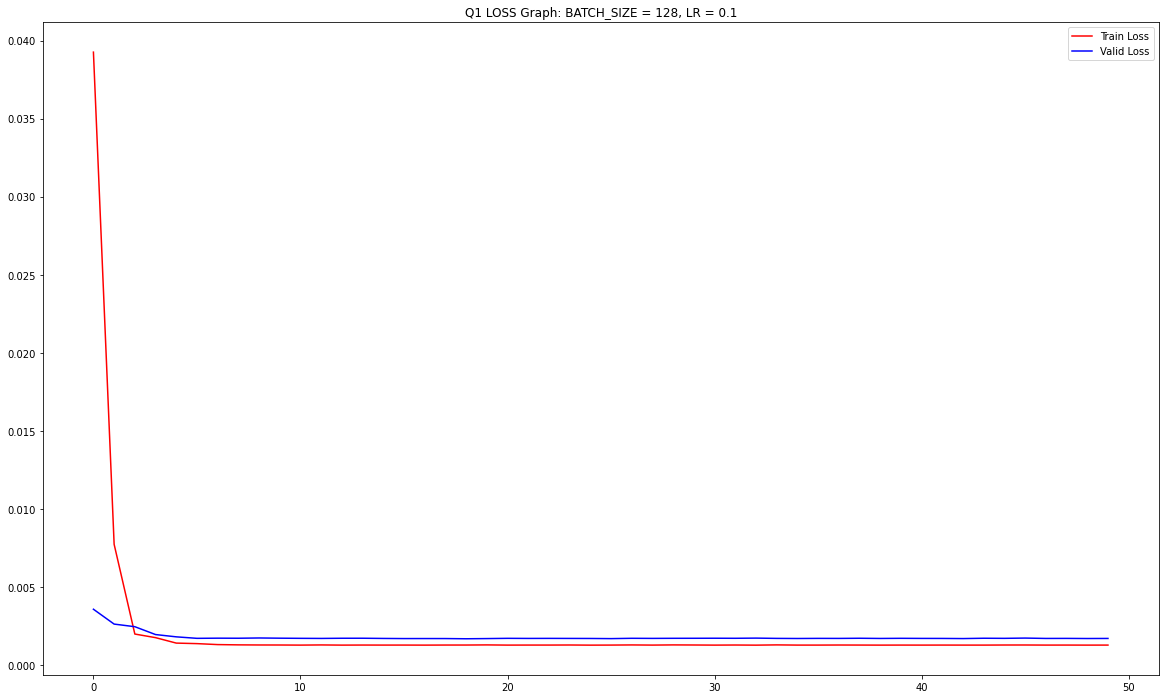

In [27]:
x = np.arange(len(train_loss))
plt.figure(figsize=(20, 12))
plt.plot(x, train_loss, color='r', label='Train Loss')
plt.plot(x, valid_loss, color='b', label='Valid Loss')
plt.title(f"Q1 LOSS Graph: BATCH_SIZE = {batch_size}, LR = {params['learning_rate']}")
plt.legend()
plt.show()

In [28]:
def mape(truths, preds):
    return np.mean(np.abs((truths - preds) / truths)) * 100

from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score

In [29]:
def test(params, test_loader, path):
    input_size = params['input_size']
    hidden_size = params['hidden_size']
    num_layers = params['num_layers']
    output_size = params['output_size']
    truths, preds = [], []
    model = LSTM(input_size, hidden_size, num_layers, output_size, batch_size)
    print(model)
    if MULTI_GPU:
        model = nn.DataParallel(model, device_ids=device_ids)
    model.load_state_dict(torch.load(path)['model'])
    model.to(device)
    
    model.eval()
    for X, y in tqdm(test_loader):
        X = X.to(device)
        for each in y:
            truths.append(each.cpu().numpy())
        with torch.no_grad():
            y_hat = model(X)
            for each in y_hat:
                preds.append(each.cpu().numpy())
    truths, preds = np.array(truths), np.array(preds)
    truths = test_scaler.inverse_transform(truths)
    preds = test_scaler.inverse_transform(preds)
    print('MAPE:', mape(truths, preds))
    print('MAE:', MAE(truths, preds))
    print('MSE:', MSE(truths, preds))
    print('R2 Score:', r2_score(truths, preds))
    
    return truths, preds

In [30]:
truths, preds = test(params, test_loader, 'model.pth')

LSTM(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)


100%|██████████| 99/99 [00:01<00:00, 95.39it/s] 

MAPE: 6.816111505031586
MAE: 12403.228
MSE: 289116830.0
R2 Score: 0.6451937535714767


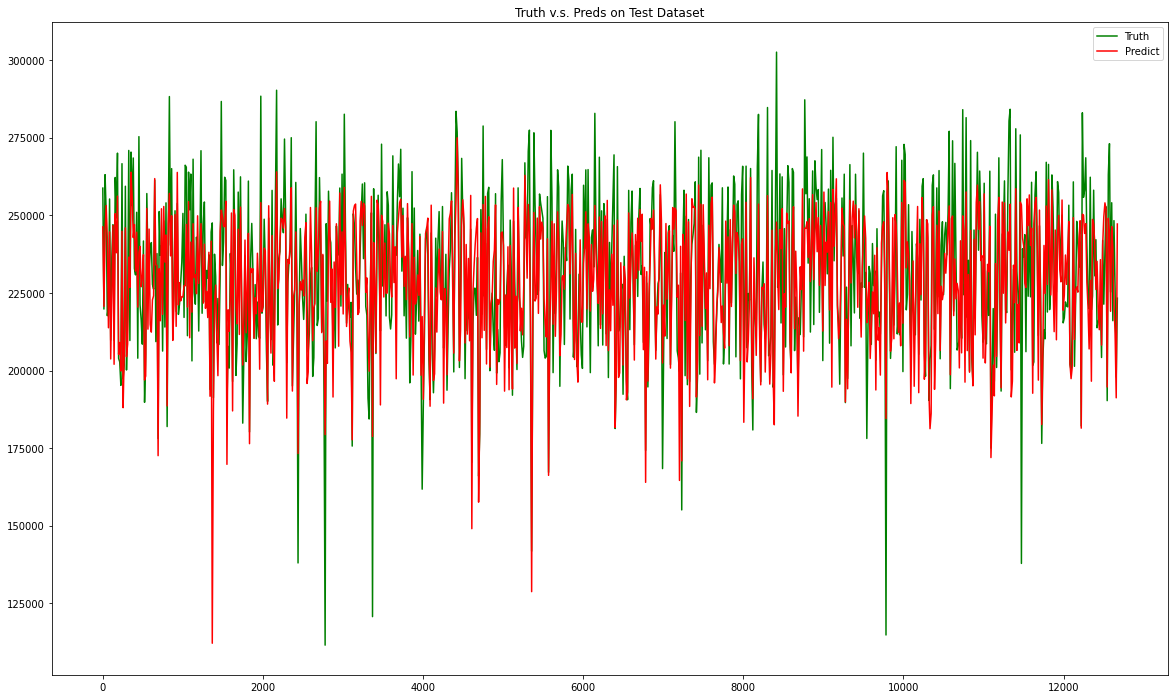

In [31]:
from scipy.interpolate import make_interp_spline

x = [i for i in range(1, len(truths) + 1)]
x_smth = np.linspace(np.min(x), np.max(x), 900)
truths_smth = make_interp_spline(x, truths)(x_smth)
preds_smth = make_interp_spline(x, preds)(x_smth)
plt.figure(figsize=(20, 12))
plt.plot(x_smth, truths_smth, color='g', label='Truth')
plt.plot(x_smth, preds_smth, color='r', label='Predict')
plt.legend()
plt.title('Truth v.s. Preds on Test Dataset')
plt.show()

# Question 2

In [32]:
df = pd.read_csv('15min_freq.csv')
df.head()

,Date,Power
0,2018-01-01 00:00:00,244033.7682
1,2018-01-01 00:15:00,232720.6402
2,2018-01-01 00:30:00,231685.6891
3,2018-01-01 00:45:00,227581.3317
4,2018-01-01 01:00:00,233482.4269


In [33]:
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Hour'] = df['Date'].dt.hour
df['Minute'] = df['Date'].dt.minute
df['Tick'] = df['Hour'] * 4 + df['Minute'] // 15
df.drop(columns=['Date'], inplace=True)
df.head()

,Power,Year,Month,Day,Hour,Minute,Tick
0,244033.7682,2018,1,1,0,0,0
1,232720.6402,2018,1,1,0,15,1
2,231685.6891,2018,1,1,0,30,2
3,227581.3317,2018,1,1,0,45,3
4,233482.4269,2018,1,1,1,0,4


In [34]:
groups = df.groupby(['Year', 'Month', 'Day'], as_index=False)
columns = ['Power', 'Year', 'Month', 'Day', 'Hour', 'Minute']
data_daily_max = pd.DataFrame(columns=columns)
data_daily_min = pd.DataFrame(columns=columns)
for group in groups:
    _, meta = group
    max_row = meta[meta['Power'] == meta['Power'].max()]
    min_row = meta[meta['Power'] == meta['Power'].min()]
    data_daily_max = pd.concat([data_daily_max, max_row], ignore_index=True)
    data_daily_min = pd.concat([data_daily_min, min_row], ignore_index=True)

In [35]:
data_daily_max.head()

,Power,Year,Month,Day,Hour,Minute,Tick
0,257733.9648,2018,1,1,19,45,79.0
1,288502.5947,2018,1,2,20,30,82.0
2,300698.5858,2018,1,3,18,15,73.0
3,293806.5077,2018,1,4,14,45,59.0
4,295075.2147,2018,1,5,18,30,74.0


In [36]:
data_daily_min.head()

,Power,Year,Month,Day,Hour,Minute,Tick
0,203793.5753,2018,1,1,8,15,33.0
1,183505.2648,2018,1,2,4,15,17.0
2,220601.5301,2018,1,3,4,15,17.0
3,224981.5866,2018,1,4,4,45,19.0
4,224667.8170,2018,1,5,4,15,17.0


Text(0.5, 1.0, 'Daily Power Max & Min')

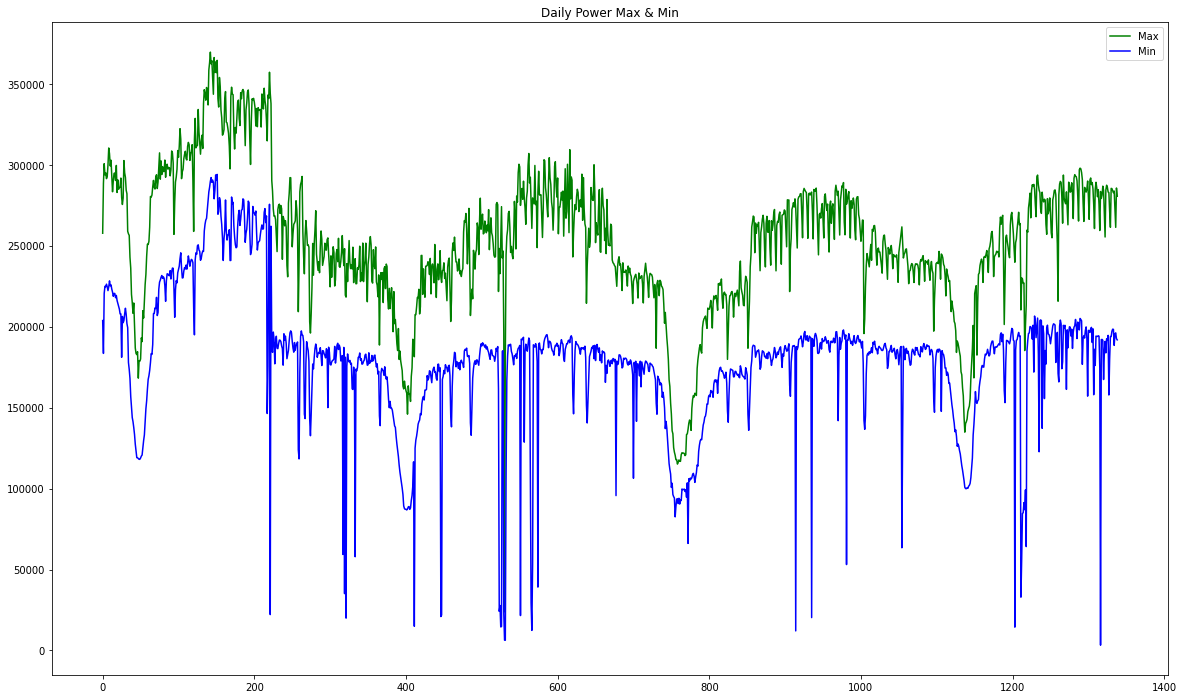

In [37]:
plt.figure(figsize=(20, 12))
x = np.arange(len(data_daily_max))
plt.plot(x, data_daily_max['Power'], c='g', label='Max')
plt.plot(x, data_daily_min['Power'], c='b', label='Min')
plt.legend()
plt.title('Daily Power Max & Min')

Text(0.5, 1.0, 'Daily Max and Min Time (As Tick)')

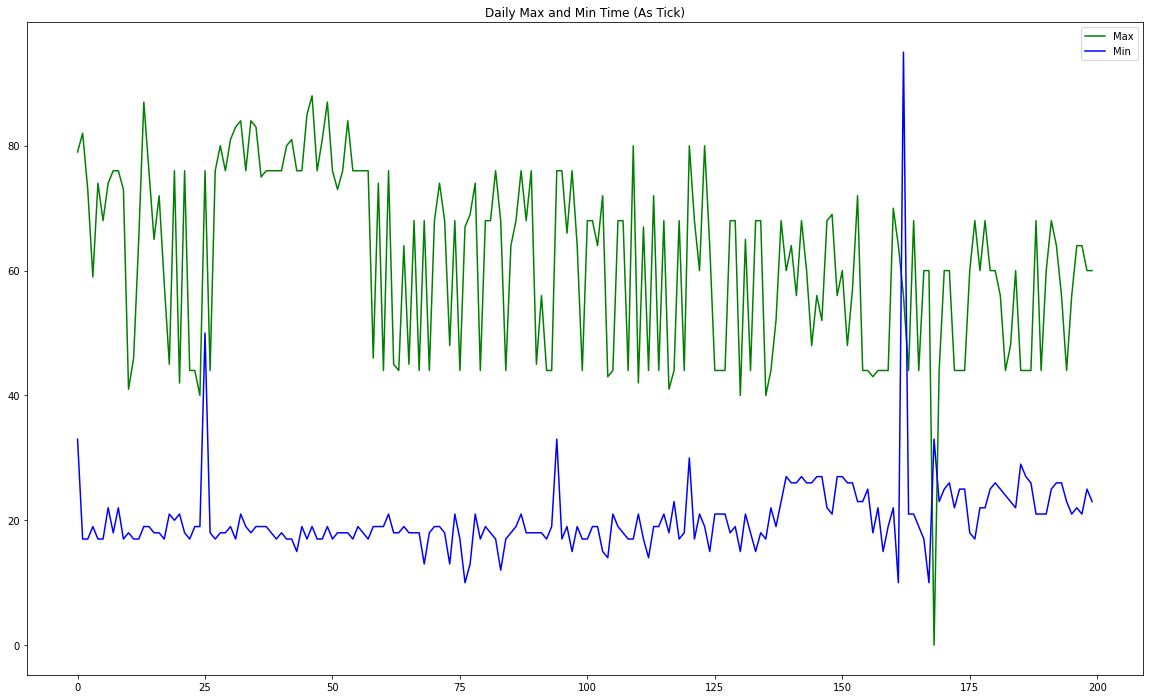

In [38]:
plt.figure(figsize=(20, 12))
x = np.arange(len(data_daily_max[:200]))
plt.plot(x, data_daily_max['Tick'][:200], c='g', label='Max')
plt.plot(x, data_daily_min['Tick'][:200], c='b', label='Min')
plt.legend()
plt.title('Daily Max and Min Time (As Tick)')

In [39]:
data_daily_max['Date'] = pd.to_datetime(data_daily_max[['Year', 'Month', 'Day']])
data_daily_min['Date'] = pd.to_datetime(data_daily_min[['Year', 'Month', 'Day']])

In [40]:
weather_data = pd.read_csv('../input/electrical-energy-load/train/3.csv')
weather_data.head()

,日期,天气状况,最高温度,最低温度,白天风力风向,夜晚风力风向
0,2018年1月1日,多云/多云,22℃,12℃,无持续风向<3级,无持续风向<3级
1,2018年1月1日,多云/多云,22℃,12℃,无持续风向<3级,无持续风向<3级
2,2018年1月2日,多云/多云,22℃,15℃,无持续风向<3级,无持续风向<3级
3,2018年1月3日,多云/阴,23℃,15℃,无持续风向<3级,无持续风向<3级
4,2018年1月4日,多云/小雨,21℃,16℃,无持续风向<3级,无持续风向<3级


In [41]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1345 entries, 0 to 1344
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   日期      1345 non-null   object
 1   天气状况    1345 non-null   object
 2   最高温度    1345 non-null   object
 3   最低温度    1345 non-null   object
 4   白天风力风向  1345 non-null   object
 5   夜晚风力风向  1345 non-null   object
dtypes: object(6)
memory usage: 63.2+ KB


In [42]:
weather_data.columns = ['Date', 'Weather', 'HighTemp', 'LowTemp', 'DayWind', 'NightWind']
weather_data['Date'] = weather_data['Date'].apply(lambda x: x.replace('年', '-'))
weather_data['Date'] = weather_data['Date'].apply(lambda x: x.replace('月', '-'))
weather_data['Date'] = weather_data['Date'].apply(lambda x: x.replace('日', '-'))
weather_data['Date'] = pd.to_datetime(weather_data['Date'])
weather_data.head()

,Date,Weather,HighTemp,LowTemp,DayWind,NightWind
0,2018-01-01,多云/多云,22℃,12℃,无持续风向<3级,无持续风向<3级
1,2018-01-01,多云/多云,22℃,12℃,无持续风向<3级,无持续风向<3级
2,2018-01-02,多云/多云,22℃,15℃,无持续风向<3级,无持续风向<3级
3,2018-01-03,多云/阴,23℃,15℃,无持续风向<3级,无持续风向<3级
4,2018-01-04,多云/小雨,21℃,16℃,无持续风向<3级,无持续风向<3级


In [43]:
weather_data['HighTemp'] = weather_data['HighTemp'].apply(lambda x: int(x[:-1]))
weather_data['LowTemp'] = weather_data['LowTemp'].apply(lambda x: int(x[:-1]))
weather_data['HighTemp'] = weather_data['HighTemp'].astype('int32')
weather_data['LowTemp'] = weather_data['LowTemp'].astype('int32')
weather_data.head()

,Date,Weather,HighTemp,LowTemp,DayWind,NightWind
0,2018-01-01,多云/多云,22,12,无持续风向<3级,无持续风向<3级
1,2018-01-01,多云/多云,22,12,无持续风向<3级,无持续风向<3级
2,2018-01-02,多云/多云,22,15,无持续风向<3级,无持续风向<3级
3,2018-01-03,多云/阴,23,15,无持续风向<3级,无持续风向<3级
4,2018-01-04,多云/小雨,21,16,无持续风向<3级,无持续风向<3级


In [44]:
weather_data['Weather1'] = weather_data['Weather'].apply(lambda x: x.split('/')[0])
weather_data['Weather2'] = weather_data['Weather'].apply(lambda x: x.split('/')[1])
weather_data.drop(columns=['Weather'], inplace=True)
weather_data['Weather1'].value_counts(), weather_data['Weather2'].value_counts()

(多云       447
 雷阵雨      213
 阴        172
 晴        158
 阵雨        96
 中雨        87
 小雨        78
 大雨        52
 暴雨        14
 中到大雨      10
 小雨-中雨      8
 中雨-大雨      4
 雾          2
 小到中雨       2
 晴间多云       1
 大到暴雨       1
 Name: Weather1, dtype: int64,
 多云       574
 阴        187
 晴        142
 雷阵雨      131
 阵雨       103
 小雨        77
 中雨        68
 大雨        33
 暴雨         8
 小到中雨       7
 大到暴雨       4
 雾          3
 中到大雨       3
 中雨-大雨      2
 小雨-中雨      2
 局部多云       1
 Name: Weather2, dtype: int64)

In [45]:
from sklearn.preprocessing import OneHotEncoder

weather_encoder = OneHotEncoder(handle_unknown='ignore')
weather_encoder.fit(weather_data[['Weather1', 'Weather2']].values)
mat = weather_encoder.transform(weather_data[['Weather1', 'Weather2']].values).toarray()
feature_labels = np.array(weather_encoder.categories_).ravel()

columns = []
for col in ['Weather1', 'Weather2']:
    for val in weather_data[col].unique():
        columns.append('{}_{}'.format(col, val))
        
onehot_codes = pd.DataFrame(data=mat, columns=columns, dtype=int)
weather_data = pd.concat([weather_data, onehot_codes], axis=1)
weather_data.head()

,Date,HighTemp,LowTemp,DayWind,NightWind,Weather1,Weather2,Weather1_多云,Weather1_阴,Weather1_小雨-中雨,...,Weather2_晴,Weather2_局部多云,Weather2_阵雨,Weather2_雾,Weather2_雷阵雨,Weather2_大雨,Weather2_暴雨,Weather2_中到大雨,Weather2_小到中雨,Weather2_大到暴雨
0,2018-01-01,22,12,无持续风向<3级,无持续风向<3级,多云,多云,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2018-01-01,22,12,无持续风向<3级,无持续风向<3级,多云,多云,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2018-01-02,22,15,无持续风向<3级,无持续风向<3级,多云,多云,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2018-01-03,23,15,无持续风向<3级,无持续风向<3级,多云,阴,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,2018-01-04,21,16,无持续风向<3级,无持续风向<3级,多云,小雨,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [46]:
wind_encoder = OneHotEncoder(handle_unknown='ignore')
wind_encoder.fit(weather_data[['DayWind', 'NightWind']].values)
mat = wind_encoder.transform(weather_data[['DayWind', 'NightWind']].values).toarray()
feature_labels = np.array(wind_encoder.categories_).ravel()

columns = []
for col in ['DayWind', 'NightWind']:
    for val in weather_data[col].unique():
        columns.append('{}_{}'.format(col, val))

onehot_codes = pd.DataFrame(data=mat, columns=columns, dtype=int)
weather_data = pd.concat([weather_data, onehot_codes], axis=1)
weather_data.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  after removing the cwd from sys.path.


,Date,HighTemp,LowTemp,DayWind,NightWind,Weather1,Weather2,Weather1_多云,Weather1_阴,Weather1_小雨-中雨,...,NightWind_北风3-4级,NightWind_北风4-5级,NightWind_南风3-4级,NightWind_南风1-2级,NightWind_东南风1-2级,NightWind_西南风3-4级,NightWind_东风1-2级,NightWind_北风1-2级,NightWind_东北风1-2级,NightWind_西南风1-2级
0,2018-01-01,22,12,无持续风向<3级,无持续风向<3级,多云,多云,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,2018-01-01,22,12,无持续风向<3级,无持续风向<3级,多云,多云,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,2018-01-02,22,15,无持续风向<3级,无持续风向<3级,多云,多云,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,2018-01-03,23,15,无持续风向<3级,无持续风向<3级,多云,阴,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,2018-01-04,21,16,无持续风向<3级,无持续风向<3级,多云,小雨,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [47]:
weather_data.shape

(1345, 90)

In [48]:
weather_data.drop(columns=['DayWind', 'NightWind', 'Weather1', 'Weather2'], inplace=True)
weather_data = weather_data.drop_duplicates(subset=['Date']).reset_index()
weather_data.shape

(1339, 87)

In [49]:
daily_max_data = pd.merge(data_daily_max, weather_data, on='Date')
daily_min_data = pd.merge(data_daily_min, weather_data, on='Date')

In [50]:
daily_max_data.index = daily_max_data['Date']
daily_min_data.index = daily_min_data['Date']
daily_max_data.drop(columns=['Date', 'index', 'Year', 'Month', 'Day', 'Hour', 'Minute'], inplace=True)
daily_min_data.drop(columns=['Date', 'index', 'Year', 'Month', 'Day', 'Hour', 'Minute'], inplace=True)

In [51]:
daily_max_data.head()

,Power,Tick,HighTemp,LowTemp,Weather1_多云,Weather1_阴,Weather1_小雨-中雨,Weather1_大雨,Weather1_中雨,Weather1_小雨,...,NightWind_北风3-4级,NightWind_北风4-5级,NightWind_南风3-4级,NightWind_南风1-2级,NightWind_东南风1-2级,NightWind_西南风3-4级,NightWind_东风1-2级,NightWind_北风1-2级,NightWind_东北风1-2级,NightWind_西南风1-2级
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-01,257733.9648,79.0,22,12,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
2018-01-02,288502.5947,82.0,22,15,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
2018-01-03,300698.5858,73.0,23,15,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
2018-01-04,293806.5077,59.0,21,16,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
2018-01-05,295075.2147,74.0,19,13,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [52]:
daily_max_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1339 entries, 2018-01-01 to 2021-08-31
Data columns (total 87 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Power                1339 non-null   float64
 1   Tick                 1339 non-null   float64
 2   HighTemp             1339 non-null   int32  
 3   LowTemp              1339 non-null   int32  
 4   Weather1_多云          1339 non-null   int64  
 5   Weather1_阴           1339 non-null   int64  
 6   Weather1_小雨-中雨       1339 non-null   int64  
 7   Weather1_大雨          1339 non-null   int64  
 8   Weather1_中雨          1339 non-null   int64  
 9   Weather1_小雨          1339 non-null   int64  
 10  Weather1_晴           1339 non-null   int64  
 11  Weather1_雷阵雨         1339 non-null   int64  
 12  Weather1_雾           1339 non-null   int64  
 13  Weather1_阵雨          1339 non-null   int64  
 14  Weather1_中雨-大雨       1339 non-null   int64  
 15  Weather1_晴间多云       

In [53]:
# from sklearn.feature_selection import VarianceThreshold

# daily_max_data = daily_max_data.values
# daily_min_data = daily_min_data.values

# max_selector = VarianceThreshold(threshold=0.16)
# daily_max_data = np.concatenate([daily_max_data[:, :2], max_selector.fit_transform(daily_max_data[:, 2:])], axis=1)

# min_selector = VarianceThreshold(threshold=0.16)
# daily_min_data = np.concatenate([daily_min_data[:, :2], min_selector.fit_transform(daily_min_data[:, 2:])], axis=1)

In [54]:
daily_max_data

,Power,Tick,HighTemp,LowTemp,Weather1_多云,Weather1_阴,Weather1_小雨-中雨,Weather1_大雨,Weather1_中雨,Weather1_小雨,...,NightWind_北风3-4级,NightWind_北风4-5级,NightWind_南风3-4级,NightWind_南风1-2级,NightWind_东南风1-2级,NightWind_西南风3-4级,NightWind_东风1-2级,NightWind_北风1-2级,NightWind_东北风1-2级,NightWind_西南风1-2级
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-01,257733.9648,79.0,22,12,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
2018-01-02,288502.5947,82.0,22,15,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
2018-01-03,300698.5858,73.0,23,15,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
2018-01-04,293806.5077,59.0,21,16,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
2018-01-05,295075.2147,74.0,19,13,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-27,283786.5080,44.0,35,26,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2021-08-28,272522.5991,64.0,33,26,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2021-08-29,261364.9171,44.0,32,25,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [55]:
train_bin_max, valid_bin_max, test_bin_max = split_dataset(daily_max_data, .7, .1)
train_bin_min, valid_bin_min, test_bin_min = split_dataset(daily_min_data, .7, .1)

In [56]:
test_max_power_range = [test_bin_max['Power'].min(), test_bin_max['Power'].max()]
test_max_tick_range = [test_bin_max['Tick'].min(), test_bin_max['Tick'].max()]

test_min_power_range = [test_bin_min['Power'].min(), test_bin_min['Power'].max()]
test_min_tick_range = [test_bin_min['Tick'].min(), test_bin_min['Tick'].max()]

In [57]:
def scaling(data):
    scaler = MinMaxScaler()
    return scaler, scaler.fit_transform(data)

In [58]:
train_max_scaler, train_max = scaling(train_bin_max)
train_min_scaler, train_min = scaling(train_bin_min)
valid_max_scaler, valid_max = scaling(valid_bin_max)
valid_min_scaler, valid_min = scaling(valid_bin_min)
test_max_scaler, test_max = scaling(test_bin_max)
test_min_scaler, test_min = scaling(test_bin_min)

Now daily max data on: train_max, valid_max, test_max

Now daily min data on: train_min, valid_min, test_min


## 2.1 For Daily Max

### 2.1.1 multi-output LSTM Regression Trail

In [59]:
def preprocessing(data, window_size, predict_size):
    X, y = [], []
    for i in range(len(data) - window_size - predict_size):
        X.append(data[i:i + window_size, 2:])
        y.append(data[i + window_size:i + window_size + predict_size, :2].reshape(2, -1))
    X = torch.FloatTensor(np.array(X))
    y = torch.FloatTensor(np.array(y))
    return X, y

In [60]:
window_size, predict_size = 14, 1

X_train, y_train = preprocessing(train_max, window_size, predict_size)
X_valid, y_valid = preprocessing(valid_max, window_size, predict_size)
X_test, y_test = preprocessing(test_max, window_size, predict_size)

In [61]:
X_train.shape

torch.Size([922, 14, 85])

In [62]:
train_data = TensorDataset(X_train, y_train)
valid_data = TensorDataset(X_valid, y_valid)
test_data = TensorDataset(X_test, y_test)

In [63]:
batch_size = 16
train_loader = DataLoader(train_data, batch_size=batch_size * num_gpus,
                          shuffle=True, num_workers=2,
                          drop_last=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size * num_gpus,
                          shuffle=True, num_workers=2,
                          drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size * num_gpus,
                          shuffle=True, num_workers=2,
                          drop_last=True)

In [64]:
print('Train set:', X_train.shape, y_train.shape)
print('Valid set:', X_valid.shape, y_valid.shape)
print('Test set:', X_test.shape, y_test.shape)

Train set: torch.Size([922, 14, 85]) torch.Size([922, 2, 1])
Valid set: torch.Size([118, 14, 85]) torch.Size([118, 2, 1])
Test set: torch.Size([254, 14, 85]) torch.Size([254, 2, 1])


In [65]:
class LSTM_multi(nn.Module):
    def __init__(self, input_size, hidden_size,
                 num_layers, output_size, batch_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.batch_size = batch_size
        self.num_directions = 1
        self.lstm = nn.LSTM(self.input_size, self.hidden_size,
                            self.num_layers, batch_first=True)
#         self.reg_pred = nn.Sequential(nn.Linear(self.hidden_size, self.hidden_size // 2),
#                                       nn.ReLU(),
#                                       nn.Linear(self.hidden_size // 2, self.hidden_size // 4),
#                                       nn.ReLU(),
#                                       nn.Linear(self.hidden_size // 4, self.output_size))
#         self.reg_time = nn.Sequential(nn.Linear(self.hidden_size, self.hidden_size // 2),
#                                       nn.ReLU(),
#                                       nn.Linear(self.hidden_size // 2, self.hidden_size // 4),
#                                       nn.ReLU(),
#                                       nn.Linear(self.hidden_size // 4, self.output_size))
        self.linear_pred = nn.Linear(self.hidden_size, self.output_size)
        self.linear_time = nn.Linear(self.hidden_size, self.output_size)
    
    def forward(self, X):
        h_0 = torch.randn(self.num_directions * self.num_layers, self.batch_size, self.hidden_size).to(device)
        c_0 = torch.randn(self.num_directions * self.num_layers, self.batch_size, self.hidden_size).to(device)
        output, _ = self.lstm(X, (h_0, c_0))
        o = output[:, -1, :]
        pred, time = self.linear_pred(o), self.linear_time(o)
#         pred, time = self.reg_pred(o), self.reg_time(o)
        preds = torch.stack([pred, time], dim=0)
        return preds

In [66]:
params = {'input_size': X_train.shape[2],
          'hidden_size': 512,
          'output_size': predict_size,
          'num_outputs': 2,
          'num_layers': 20, 
          'learning_rate': 0.5,
          'weight_decay': 1e-2,
          'step_size': 10,
          'gamma': 0.1,
          'epochs': 100}

In [67]:
def train(params, train_loader, valid_loader, path):
    input_size = params['input_size']
    hidden_size = params['hidden_size']
    num_layers = params['num_layers']
    output_size = params['output_size']
    lr = params['learning_rate']
    wd = params['weight_decay']
    step_size = params['step_size']
    gamma = params['gamma']
    epochs = params['epochs']
    num_outputs = params['num_outputs']
    train_loss, valid_loss = [], []
    min_valid_loss = np.inf
    
    model = LSTM_multi(input_size, hidden_size, num_layers, output_size, batch_size)
    print(model)
    if MULTI_GPU:
        model = nn.DataParallel(model, device_ids=device_ids)
    model.to(device)
    
    loss = nn.MSELoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size,
                                                gamma=gamma)
    if MULTI_GPU:
        optimizer = nn.DataParallel(optimizer, device_ids=device_ids)
        scheduler = nn.DataParallel(scheduler, device_ids=device_ids)
        
    for epoch in tqdm(range(epochs)):
        train_ls, valid_ls = [], []
        
        model.train()
        for step, (X, y) in enumerate(train_loader):
            X = X.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            l = 0
            for k in range(num_outputs):
                l += loss(y_hat[k, :, :], y[:, k, :])
            l /= num_outputs
            train_ls.append(l.item())
            l.backward()
            optimizer.step()
            if step % 10 == 0:
                print("Step {}, train loss {:.6f}".format(step, l.item()))
        train_loss.append(np.mean(train_ls))
        
        model.eval()
        for step, (X, y) in enumerate(valid_loader):
            X = X.to(device)
            y = y.to(device)
            with torch.no_grad():
                y_hat = model(X)
            l = 0
            for k in range(num_outputs):
                l += loss(y_hat[k, :, :], y[:, k, :])
            l /= num_outputs
            valid_ls.append(l.item())
        valid_loss.append(np.mean(valid_ls))
        if valid_loss[-1] < min_valid_loss:
            state = {'model': model.state_dict()}
            torch.save(state, path)
            min_valid_loss = valid_loss[-1]
        
        print('Epoch [{:d}/{:d}], train loss {:.6f}, valid loss {:.6f}. Now best: {:.6f}'.format(
                epoch + 1, epochs, train_loss[-1], valid_loss[-1], min_valid_loss))
        scheduler.step()
    
    return train_loss, valid_loss

In [68]:
train_loss, valid_loss = train(params, train_loader, valid_loader, 'model_max.pth')

LSTM_multi(
  (lstm): LSTM(85, 512, num_layers=20, batch_first=True)
  (linear_pred): Linear(in_features=512, out_features=1, bias=True)
  (linear_time): Linear(in_features=512, out_features=1, bias=True)
)


  0%|          | 0/100 [00:00<?, ?it/s]

Step 0, train loss 0.375640
Step 10, train loss 108.642059
Step 20, train loss 197.178909
Step 30, train loss 201.855560
Step 40, train loss 143.394806
Step 50, train loss 279.198425


  1%|          | 1/100 [00:03<05:51,  3.55s/it]

Epoch [1/100], train loss 185.370884, valid loss 248.722898. Now best: 248.722898
Step 0, train loss 175.628799
Step 10, train loss 275.362183
Step 20, train loss 293.517120
Step 30, train loss 223.568420
Step 40, train loss 108.819519
Step 50, train loss 140.443756


  2%|▏         | 2/100 [00:07<05:52,  3.60s/it]

Epoch [2/100], train loss 197.540646, valid loss 155.953674. Now best: 155.953674
Step 0, train loss 300.382568
Step 10, train loss 85.949020
Step 20, train loss 235.694061
Step 30, train loss 243.617477
Step 40, train loss 110.813431
Step 50, train loss 173.507874


  3%|▎         | 3/100 [00:10<05:50,  3.62s/it]

Epoch [3/100], train loss 176.273684, valid loss 140.034457. Now best: 140.034457
Step 0, train loss 221.468689
Step 10, train loss 126.381744
Step 20, train loss 196.680954
Step 30, train loss 139.294022
Step 40, train loss 102.465637
Step 50, train loss 143.358154


  4%|▍         | 4/100 [00:14<05:49,  3.64s/it]

Epoch [4/100], train loss 142.556501, valid loss 121.509575. Now best: 121.509575
Step 0, train loss 113.235962
Step 10, train loss 191.475952
Step 20, train loss 173.506271
Step 30, train loss 102.386490
Step 40, train loss 248.024231
Step 50, train loss 114.760788


  5%|▌         | 5/100 [00:17<05:26,  3.44s/it]

Epoch [5/100], train loss 135.098827, valid loss 177.874422. Now best: 121.509575
Step 0, train loss 163.677475
Step 10, train loss 138.859497
Step 20, train loss 171.526306
Step 30, train loss 126.925316
Step 40, train loss 111.042938
Step 50, train loss 134.751099


  6%|▌         | 6/100 [00:20<05:11,  3.32s/it]

Epoch [6/100], train loss 173.800608, valid loss 200.322719. Now best: 121.509575
Step 0, train loss 261.413727
Step 10, train loss 108.002075
Step 20, train loss 176.241608
Step 30, train loss 228.267914
Step 40, train loss 86.759285
Step 50, train loss 202.214172


  7%|▋         | 7/100 [00:23<05:01,  3.24s/it]

Epoch [7/100], train loss 201.602467, valid loss 222.204725. Now best: 121.509575
Step 0, train loss 162.873718
Step 10, train loss 214.193604
Step 20, train loss 269.104858
Step 30, train loss 115.760132
Step 40, train loss 227.819336
Step 50, train loss 187.660126


  8%|▊         | 8/100 [00:26<04:54,  3.20s/it]

Epoch [8/100], train loss 182.834524, valid loss 172.082758. Now best: 121.509575
Step 0, train loss 193.807220
Step 10, train loss 130.500504
Step 20, train loss 300.225159
Step 30, train loss 199.207214
Step 40, train loss 194.201233
Step 50, train loss 226.358917


  9%|▉         | 9/100 [00:30<04:51,  3.20s/it]

Epoch [9/100], train loss 198.577736, valid loss 224.240969. Now best: 121.509575
Step 0, train loss 226.746262
Step 10, train loss 211.491943
Step 20, train loss 185.486328
Step 30, train loss 219.171646
Step 40, train loss 115.033524
Step 50, train loss 182.082397


 10%|█         | 10/100 [00:33<04:47,  3.19s/it]

Epoch [10/100], train loss 212.193327, valid loss 188.689956. Now best: 121.509575
Step 0, train loss 287.100525
Step 10, train loss 197.011963
Step 20, train loss 112.377174
Step 30, train loss 154.630188
Step 40, train loss 109.545181
Step 50, train loss 105.893707


 11%|█         | 11/100 [00:36<04:56,  3.33s/it]

Epoch [11/100], train loss 155.196884, valid loss 100.421838. Now best: 100.421838
Step 0, train loss 76.563454
Step 10, train loss 61.123211
Step 20, train loss 88.377296
Step 30, train loss 48.535717
Step 40, train loss 41.597980
Step 50, train loss 57.358299


 12%|█▏        | 12/100 [00:40<05:01,  3.43s/it]

Epoch [12/100], train loss 64.885775, valid loss 56.337549. Now best: 56.337549
Step 0, train loss 61.707306
Step 10, train loss 33.319805
Step 20, train loss 31.534433
Step 30, train loss 23.019287
Step 40, train loss 57.640236
Step 50, train loss 33.301964


 13%|█▎        | 13/100 [00:44<05:03,  3.49s/it]

Epoch [13/100], train loss 38.658011, valid loss 22.453820. Now best: 22.453820
Step 0, train loss 18.551949
Step 10, train loss 15.157932
Step 20, train loss 35.920559
Step 30, train loss 21.486219
Step 40, train loss 18.003014
Step 50, train loss 12.454972


 14%|█▍        | 14/100 [00:47<05:05,  3.55s/it]

Epoch [14/100], train loss 19.399402, valid loss 11.564578. Now best: 11.564578
Step 0, train loss 19.496899
Step 10, train loss 7.278380
Step 20, train loss 13.904026
Step 30, train loss 7.470173
Step 40, train loss 13.371686
Step 50, train loss 12.723972


 15%|█▌        | 15/100 [00:51<05:04,  3.58s/it]

Epoch [15/100], train loss 9.068178, valid loss 5.911385. Now best: 5.911385
Step 0, train loss 3.027122
Step 10, train loss 4.497573
Step 20, train loss 5.278373
Step 30, train loss 4.439944
Step 40, train loss 3.828243
Step 50, train loss 2.102408


 16%|█▌        | 16/100 [00:55<05:02,  3.60s/it]

Epoch [16/100], train loss 4.224734, valid loss 3.554232. Now best: 3.554232
Step 0, train loss 3.488935
Step 10, train loss 2.191145
Step 20, train loss 3.100289
Step 30, train loss 0.892350
Step 40, train loss 2.224823
Step 50, train loss 1.877511


 17%|█▋        | 17/100 [00:58<05:01,  3.63s/it]

Epoch [17/100], train loss 2.175161, valid loss 1.784642. Now best: 1.784642
Step 0, train loss 1.582174
Step 10, train loss 0.877037
Step 20, train loss 1.797264
Step 30, train loss 0.773838
Step 40, train loss 2.032696
Step 50, train loss 0.520981


 18%|█▊        | 18/100 [01:02<05:03,  3.70s/it]

Epoch [18/100], train loss 1.082684, valid loss 0.912387. Now best: 0.912387
Step 0, train loss 1.635287
Step 10, train loss 0.897067
Step 20, train loss 0.517190
Step 30, train loss 0.344272
Step 40, train loss 0.487812
Step 50, train loss 0.441441


 19%|█▉        | 19/100 [01:06<04:58,  3.69s/it]

Epoch [19/100], train loss 0.538603, valid loss 0.392018. Now best: 0.392018
Step 0, train loss 0.433014
Step 10, train loss 0.221822
Step 20, train loss 0.221181
Step 30, train loss 0.266382
Step 40, train loss 0.181007
Step 50, train loss 0.233611


 20%|██        | 20/100 [01:10<04:54,  3.68s/it]

Epoch [20/100], train loss 0.275281, valid loss 0.311020. Now best: 0.311020
Step 0, train loss 0.193236
Step 10, train loss 0.195861
Step 20, train loss 0.302031
Step 30, train loss 0.138124
Step 40, train loss 0.143113
Step 50, train loss 0.226735


 21%|██        | 21/100 [01:13<04:53,  3.72s/it]

Epoch [21/100], train loss 0.214086, valid loss 0.258033. Now best: 0.258033
Step 0, train loss 0.210641
Step 10, train loss 0.201290
Step 20, train loss 0.262472
Step 30, train loss 0.183947
Step 40, train loss 0.158528
Step 50, train loss 0.177928


 22%|██▏       | 22/100 [01:17<04:48,  3.70s/it]

Epoch [22/100], train loss 0.196942, valid loss 0.246819. Now best: 0.246819
Step 0, train loss 0.201431
Step 10, train loss 0.158750
Step 20, train loss 0.100889
Step 30, train loss 0.140841
Step 40, train loss 0.088969
Step 50, train loss 0.127795


 23%|██▎       | 23/100 [01:21<04:44,  3.69s/it]

Epoch [23/100], train loss 0.171198, valid loss 0.245428. Now best: 0.245428
Step 0, train loss 0.204672
Step 10, train loss 0.079298
Step 20, train loss 0.108231
Step 30, train loss 0.146309
Step 40, train loss 0.146037
Step 50, train loss 0.057481


 24%|██▍       | 24/100 [01:24<04:39,  3.68s/it]

Epoch [24/100], train loss 0.165097, valid loss 0.232058. Now best: 0.232058
Step 0, train loss 0.145380
Step 10, train loss 0.122971
Step 20, train loss 0.200552
Step 30, train loss 0.116896
Step 40, train loss 0.176869
Step 50, train loss 0.116963


 25%|██▌       | 25/100 [01:28<04:34,  3.66s/it]

Epoch [25/100], train loss 0.153588, valid loss 0.192657. Now best: 0.192657
Step 0, train loss 0.278611
Step 10, train loss 0.113850
Step 20, train loss 0.128736
Step 30, train loss 0.243950
Step 40, train loss 0.131359
Step 50, train loss 0.113075


 26%|██▌       | 26/100 [01:31<04:19,  3.50s/it]

Epoch [26/100], train loss 0.148386, valid loss 0.198896. Now best: 0.192657
Step 0, train loss 0.121357
Step 10, train loss 0.179587
Step 20, train loss 0.116280
Step 30, train loss 0.049141
Step 40, train loss 0.179859
Step 50, train loss 0.149837


 27%|██▋       | 27/100 [01:34<04:07,  3.39s/it]

Epoch [27/100], train loss 0.127820, valid loss 0.200136. Now best: 0.192657
Step 0, train loss 0.109780
Step 10, train loss 0.137234
Step 20, train loss 0.143385
Step 30, train loss 0.184278
Step 40, train loss 0.060103
Step 50, train loss 0.098739


 28%|██▊       | 28/100 [01:37<03:57,  3.30s/it]

Epoch [28/100], train loss 0.131353, valid loss 0.204891. Now best: 0.192657
Step 0, train loss 0.114840
Step 10, train loss 0.088015
Step 20, train loss 0.046655
Step 30, train loss 0.117069
Step 40, train loss 0.129023
Step 50, train loss 0.082259


 29%|██▉       | 29/100 [01:40<03:49,  3.23s/it]

Epoch [29/100], train loss 0.114751, valid loss 0.229177. Now best: 0.192657
Step 0, train loss 0.129978
Step 10, train loss 0.104374
Step 20, train loss 0.075264
Step 30, train loss 0.137464
Step 40, train loss 0.111622
Step 50, train loss 0.123383


 30%|███       | 30/100 [01:44<03:55,  3.37s/it]

Epoch [30/100], train loss 0.106520, valid loss 0.189164. Now best: 0.189164
Step 0, train loss 0.099783
Step 10, train loss 0.076731
Step 20, train loss 0.097918
Step 30, train loss 0.080068
Step 40, train loss 0.147025
Step 50, train loss 0.176828


 31%|███       | 31/100 [01:48<03:59,  3.46s/it]

Epoch [31/100], train loss 0.100953, valid loss 0.183293. Now best: 0.183293
Step 0, train loss 0.077061
Step 10, train loss 0.124747
Step 20, train loss 0.168811
Step 30, train loss 0.285322
Step 40, train loss 0.121630
Step 50, train loss 0.120151


 32%|███▏      | 32/100 [01:51<03:58,  3.51s/it]

Epoch [32/100], train loss 0.109238, valid loss 0.165576. Now best: 0.165576
Step 0, train loss 0.128736
Step 10, train loss 0.090235
Step 20, train loss 0.076334
Step 30, train loss 0.095584
Step 40, train loss 0.111007
Step 50, train loss 0.060534


 33%|███▎      | 33/100 [01:54<03:47,  3.39s/it]

Epoch [33/100], train loss 0.112468, valid loss 0.180660. Now best: 0.165576
Step 0, train loss 0.088932
Step 10, train loss 0.084627
Step 20, train loss 0.086944
Step 30, train loss 0.151865
Step 40, train loss 0.172940
Step 50, train loss 0.131057


 34%|███▍      | 34/100 [01:58<03:48,  3.46s/it]

Epoch [34/100], train loss 0.107577, valid loss 0.164065. Now best: 0.164065
Step 0, train loss 0.055581
Step 10, train loss 0.109380
Step 20, train loss 0.133274
Step 30, train loss 0.099577
Step 40, train loss 0.113747
Step 50, train loss 0.064246


 35%|███▌      | 35/100 [02:01<03:37,  3.35s/it]

Epoch [35/100], train loss 0.103665, valid loss 0.177576. Now best: 0.164065
Step 0, train loss 0.121689
Step 10, train loss 0.078774
Step 20, train loss 0.086860
Step 30, train loss 0.062399
Step 40, train loss 0.111082
Step 50, train loss 0.081022


 36%|███▌      | 36/100 [02:04<03:33,  3.33s/it]

Epoch [36/100], train loss 0.099254, valid loss 0.190948. Now best: 0.164065
Step 0, train loss 0.119074
Step 10, train loss 0.093516
Step 20, train loss 0.139482
Step 30, train loss 0.104300
Step 40, train loss 0.185188
Step 50, train loss 0.119770


 37%|███▋      | 37/100 [02:08<03:36,  3.43s/it]

Epoch [37/100], train loss 0.101400, valid loss 0.161497. Now best: 0.161497
Step 0, train loss 0.145336
Step 10, train loss 0.073078
Step 20, train loss 0.101447
Step 30, train loss 0.120153
Step 40, train loss 0.125676
Step 50, train loss 0.135911


 38%|███▊      | 38/100 [02:12<03:36,  3.49s/it]

Epoch [38/100], train loss 0.103528, valid loss 0.161041. Now best: 0.161041
Step 0, train loss 0.085662
Step 10, train loss 0.177336
Step 20, train loss 0.204873
Step 30, train loss 0.091610
Step 40, train loss 0.117328
Step 50, train loss 0.081162


 39%|███▉      | 39/100 [02:15<03:26,  3.39s/it]

Epoch [39/100], train loss 0.112718, valid loss 0.177866. Now best: 0.161041
Step 0, train loss 0.063294
Step 10, train loss 0.095194
Step 20, train loss 0.085308
Step 30, train loss 0.098664
Step 40, train loss 0.057685
Step 50, train loss 0.140548


 40%|████      | 40/100 [02:18<03:17,  3.29s/it]

Epoch [40/100], train loss 0.094371, valid loss 0.194441. Now best: 0.161041
Step 0, train loss 0.055998
Step 10, train loss 0.090171
Step 20, train loss 0.094213
Step 30, train loss 0.083079
Step 40, train loss 0.104027
Step 50, train loss 0.055048


 41%|████      | 41/100 [02:21<03:10,  3.23s/it]

Epoch [41/100], train loss 0.098965, valid loss 0.169572. Now best: 0.161041
Step 0, train loss 0.080121
Step 10, train loss 0.144179
Step 20, train loss 0.065132
Step 30, train loss 0.089944
Step 40, train loss 0.077703
Step 50, train loss 0.093144


 42%|████▏     | 42/100 [02:24<03:04,  3.19s/it]

Epoch [42/100], train loss 0.093947, valid loss 0.177761. Now best: 0.161041
Step 0, train loss 0.119231
Step 10, train loss 0.051729
Step 20, train loss 0.140818
Step 30, train loss 0.167116
Step 40, train loss 0.121893
Step 50, train loss 0.080476


 43%|████▎     | 43/100 [02:27<03:00,  3.17s/it]

Epoch [43/100], train loss 0.100169, valid loss 0.181645. Now best: 0.161041
Step 0, train loss 0.133287
Step 10, train loss 0.152217
Step 20, train loss 0.123922
Step 30, train loss 0.079735
Step 40, train loss 0.116075
Step 50, train loss 0.098468


 44%|████▍     | 44/100 [02:30<02:56,  3.15s/it]

Epoch [44/100], train loss 0.100577, valid loss 0.164773. Now best: 0.161041
Step 0, train loss 0.040078
Step 10, train loss 0.128645
Step 20, train loss 0.073548
Step 30, train loss 0.081219
Step 40, train loss 0.117953
Step 50, train loss 0.077632


 45%|████▌     | 45/100 [02:33<02:51,  3.13s/it]

Epoch [45/100], train loss 0.100782, valid loss 0.179211. Now best: 0.161041
Step 0, train loss 0.072226
Step 10, train loss 0.104533
Step 20, train loss 0.085585
Step 30, train loss 0.143998
Step 40, train loss 0.092582
Step 50, train loss 0.092205


 46%|████▌     | 46/100 [02:37<02:53,  3.21s/it]

Epoch [46/100], train loss 0.105670, valid loss 0.185700. Now best: 0.161041
Step 0, train loss 0.103492
Step 10, train loss 0.035022
Step 20, train loss 0.110024
Step 30, train loss 0.047454
Step 40, train loss 0.044876
Step 50, train loss 0.111142


 47%|████▋     | 47/100 [02:40<02:48,  3.17s/it]

Epoch [47/100], train loss 0.096772, valid loss 0.178264. Now best: 0.161041
Step 0, train loss 0.066919
Step 10, train loss 0.074919
Step 20, train loss 0.093702
Step 30, train loss 0.060610
Step 40, train loss 0.080222
Step 50, train loss 0.133900


 48%|████▊     | 48/100 [02:43<02:43,  3.14s/it]

Epoch [48/100], train loss 0.094425, valid loss 0.178367. Now best: 0.161041
Step 0, train loss 0.157535
Step 10, train loss 0.079361
Step 20, train loss 0.108991
Step 30, train loss 0.059504
Step 40, train loss 0.093166
Step 50, train loss 0.058385


 49%|████▉     | 49/100 [02:46<02:39,  3.13s/it]

Epoch [49/100], train loss 0.096194, valid loss 0.181996. Now best: 0.161041
Step 0, train loss 0.061023
Step 10, train loss 0.107719
Step 20, train loss 0.094548
Step 30, train loss 0.124820
Step 40, train loss 0.057429
Step 50, train loss 0.127786


 50%|█████     | 50/100 [02:49<02:36,  3.13s/it]

Epoch [50/100], train loss 0.094091, valid loss 0.169231. Now best: 0.161041
Step 0, train loss 0.057302
Step 10, train loss 0.072358
Step 20, train loss 0.071843
Step 30, train loss 0.145230
Step 40, train loss 0.079312
Step 50, train loss 0.088640


 51%|█████     | 51/100 [02:52<02:32,  3.11s/it]

Epoch [51/100], train loss 0.094885, valid loss 0.212983. Now best: 0.161041
Step 0, train loss 0.110939
Step 10, train loss 0.064909
Step 20, train loss 0.093814
Step 30, train loss 0.074072
Step 40, train loss 0.166917
Step 50, train loss 0.050104


 52%|█████▏    | 52/100 [02:55<02:28,  3.10s/it]

Epoch [52/100], train loss 0.087957, valid loss 0.168939. Now best: 0.161041
Step 0, train loss 0.090977
Step 10, train loss 0.114997
Step 20, train loss 0.122322
Step 30, train loss 0.112285
Step 40, train loss 0.113683
Step 50, train loss 0.139694


 53%|█████▎    | 53/100 [02:59<02:26,  3.11s/it]

Epoch [53/100], train loss 0.099509, valid loss 0.161379. Now best: 0.161041
Step 0, train loss 0.154224
Step 10, train loss 0.091788
Step 20, train loss 0.110020
Step 30, train loss 0.074259
Step 40, train loss 0.077289
Step 50, train loss 0.097005


 54%|█████▍    | 54/100 [03:02<02:22,  3.11s/it]

Epoch [54/100], train loss 0.101923, valid loss 0.167779. Now best: 0.161041
Step 0, train loss 0.064846
Step 10, train loss 0.068377
Step 20, train loss 0.165473
Step 30, train loss 0.062762
Step 40, train loss 0.164024
Step 50, train loss 0.082403


 55%|█████▌    | 55/100 [03:05<02:19,  3.10s/it]

Epoch [55/100], train loss 0.095986, valid loss 0.165332. Now best: 0.161041
Step 0, train loss 0.109232
Step 10, train loss 0.108202
Step 20, train loss 0.059612
Step 30, train loss 0.111298
Step 40, train loss 0.063841
Step 50, train loss 0.052584


 56%|█████▌    | 56/100 [03:08<02:18,  3.15s/it]

Epoch [56/100], train loss 0.089545, valid loss 0.168780. Now best: 0.161041
Step 0, train loss 0.192147
Step 10, train loss 0.082106
Step 20, train loss 0.085856
Step 30, train loss 0.126513
Step 40, train loss 0.102476
Step 50, train loss 0.137957


 57%|█████▋    | 57/100 [03:11<02:15,  3.15s/it]

Epoch [57/100], train loss 0.101737, valid loss 0.177015. Now best: 0.161041
Step 0, train loss 0.128921
Step 10, train loss 0.148079
Step 20, train loss 0.092506
Step 30, train loss 0.111256
Step 40, train loss 0.095070
Step 50, train loss 0.053384


 58%|█████▊    | 58/100 [03:14<02:11,  3.13s/it]

Epoch [58/100], train loss 0.094023, valid loss 0.181682. Now best: 0.161041
Step 0, train loss 0.148050
Step 10, train loss 0.098771
Step 20, train loss 0.055644
Step 30, train loss 0.139765
Step 40, train loss 0.081943
Step 50, train loss 0.097987


 59%|█████▉    | 59/100 [03:18<02:14,  3.29s/it]

Epoch [59/100], train loss 0.102228, valid loss 0.159721. Now best: 0.159721
Step 0, train loss 0.058067
Step 10, train loss 0.100790
Step 20, train loss 0.136608
Step 30, train loss 0.044385
Step 40, train loss 0.092473
Step 50, train loss 0.126468


 60%|██████    | 60/100 [03:21<02:09,  3.24s/it]

Epoch [60/100], train loss 0.095243, valid loss 0.160460. Now best: 0.159721
Step 0, train loss 0.069918
Step 10, train loss 0.068030
Step 20, train loss 0.132609
Step 30, train loss 0.086870
Step 40, train loss 0.078858
Step 50, train loss 0.140498


 61%|██████    | 61/100 [03:24<02:04,  3.19s/it]

Epoch [61/100], train loss 0.099323, valid loss 0.175702. Now best: 0.159721
Step 0, train loss 0.084157
Step 10, train loss 0.100384
Step 20, train loss 0.141462
Step 30, train loss 0.127364
Step 40, train loss 0.098401
Step 50, train loss 0.087479


 62%|██████▏   | 62/100 [03:28<02:06,  3.32s/it]

Epoch [62/100], train loss 0.093693, valid loss 0.145445. Now best: 0.145445
Step 0, train loss 0.076784
Step 10, train loss 0.027607
Step 20, train loss 0.073527
Step 30, train loss 0.057192
Step 40, train loss 0.078584
Step 50, train loss 0.075370


 63%|██████▎   | 63/100 [03:31<02:01,  3.29s/it]

Epoch [63/100], train loss 0.092136, valid loss 0.167174. Now best: 0.145445
Step 0, train loss 0.078527
Step 10, train loss 0.109272
Step 20, train loss 0.105293
Step 30, train loss 0.086992
Step 40, train loss 0.088483
Step 50, train loss 0.115563


 64%|██████▍   | 64/100 [03:34<01:56,  3.24s/it]

Epoch [64/100], train loss 0.104400, valid loss 0.172599. Now best: 0.145445
Step 0, train loss 0.054895
Step 10, train loss 0.138971
Step 20, train loss 0.129443
Step 30, train loss 0.072164
Step 40, train loss 0.079831
Step 50, train loss 0.079689


 65%|██████▌   | 65/100 [03:37<01:51,  3.20s/it]

Epoch [65/100], train loss 0.097376, valid loss 0.159869. Now best: 0.145445
Step 0, train loss 0.047646
Step 10, train loss 0.071365
Step 20, train loss 0.181015
Step 30, train loss 0.090820
Step 40, train loss 0.106391
Step 50, train loss 0.116017


 66%|██████▌   | 66/100 [03:40<01:47,  3.18s/it]

Epoch [66/100], train loss 0.102330, valid loss 0.160389. Now best: 0.145445
Step 0, train loss 0.111934
Step 10, train loss 0.151411
Step 20, train loss 0.116925
Step 30, train loss 0.095488
Step 40, train loss 0.146957
Step 50, train loss 0.086906


 67%|██████▋   | 67/100 [03:43<01:44,  3.16s/it]

Epoch [67/100], train loss 0.103865, valid loss 0.156766. Now best: 0.145445
Step 0, train loss 0.103786
Step 10, train loss 0.080325
Step 20, train loss 0.090054
Step 30, train loss 0.111944
Step 40, train loss 0.123530
Step 50, train loss 0.066457


 68%|██████▊   | 68/100 [03:46<01:40,  3.14s/it]

Epoch [68/100], train loss 0.093612, valid loss 0.183020. Now best: 0.145445
Step 0, train loss 0.140056
Step 10, train loss 0.064195
Step 20, train loss 0.063391
Step 30, train loss 0.106372
Step 40, train loss 0.124478
Step 50, train loss 0.126674


 69%|██████▉   | 69/100 [03:50<01:36,  3.12s/it]

Epoch [69/100], train loss 0.098661, valid loss 0.180016. Now best: 0.145445
Step 0, train loss 0.062126
Step 10, train loss 0.102408
Step 20, train loss 0.125269
Step 30, train loss 0.064072
Step 40, train loss 0.130984
Step 50, train loss 0.079389


 70%|███████   | 70/100 [03:53<01:33,  3.13s/it]

Epoch [70/100], train loss 0.096810, valid loss 0.154838. Now best: 0.145445
Step 0, train loss 0.091336
Step 10, train loss 0.076320
Step 20, train loss 0.093344
Step 30, train loss 0.080743
Step 40, train loss 0.122248
Step 50, train loss 0.071462


 71%|███████   | 71/100 [03:56<01:30,  3.13s/it]

Epoch [71/100], train loss 0.093433, valid loss 0.158290. Now best: 0.145445
Step 0, train loss 0.046765
Step 10, train loss 0.084889
Step 20, train loss 0.050229
Step 30, train loss 0.087322
Step 40, train loss 0.134224
Step 50, train loss 0.090800


 72%|███████▏  | 72/100 [03:59<01:27,  3.11s/it]

Epoch [72/100], train loss 0.093594, valid loss 0.170065. Now best: 0.145445
Step 0, train loss 0.052618
Step 10, train loss 0.060098
Step 20, train loss 0.097806
Step 30, train loss 0.110716
Step 40, train loss 0.091855
Step 50, train loss 0.089043


 73%|███████▎  | 73/100 [04:02<01:23,  3.10s/it]

Epoch [73/100], train loss 0.089529, valid loss 0.149913. Now best: 0.145445
Step 0, train loss 0.053902
Step 10, train loss 0.085706
Step 20, train loss 0.074268
Step 30, train loss 0.080480
Step 40, train loss 0.075282
Step 50, train loss 0.060081


 74%|███████▍  | 74/100 [04:05<01:20,  3.11s/it]

Epoch [74/100], train loss 0.094680, valid loss 0.177906. Now best: 0.145445
Step 0, train loss 0.148535
Step 10, train loss 0.123657
Step 20, train loss 0.072515
Step 30, train loss 0.161270
Step 40, train loss 0.087956
Step 50, train loss 0.162994


 75%|███████▌  | 75/100 [04:08<01:17,  3.10s/it]

Epoch [75/100], train loss 0.098400, valid loss 0.155313. Now best: 0.145445
Step 0, train loss 0.146246
Step 10, train loss 0.124459
Step 20, train loss 0.106589
Step 30, train loss 0.102518
Step 40, train loss 0.092644
Step 50, train loss 0.091075


 76%|███████▌  | 76/100 [04:11<01:14,  3.12s/it]

Epoch [76/100], train loss 0.095818, valid loss 0.152045. Now best: 0.145445
Step 0, train loss 0.078494
Step 10, train loss 0.115072
Step 20, train loss 0.055903
Step 30, train loss 0.137878
Step 40, train loss 0.123069
Step 50, train loss 0.092018


 77%|███████▋  | 77/100 [04:14<01:11,  3.11s/it]

Epoch [77/100], train loss 0.099435, valid loss 0.160620. Now best: 0.145445
Step 0, train loss 0.078901
Step 10, train loss 0.053723
Step 20, train loss 0.107567
Step 30, train loss 0.090451
Step 40, train loss 0.112783
Step 50, train loss 0.077107


 78%|███████▊  | 78/100 [04:18<01:08,  3.11s/it]

Epoch [78/100], train loss 0.092037, valid loss 0.165511. Now best: 0.145445
Step 0, train loss 0.075699
Step 10, train loss 0.148293
Step 20, train loss 0.091549
Step 30, train loss 0.130373
Step 40, train loss 0.056153
Step 50, train loss 0.161583


 79%|███████▉  | 79/100 [04:21<01:05,  3.10s/it]

Epoch [79/100], train loss 0.101091, valid loss 0.165864. Now best: 0.145445
Step 0, train loss 0.058180
Step 10, train loss 0.070169
Step 20, train loss 0.089871
Step 30, train loss 0.106252
Step 40, train loss 0.067371
Step 50, train loss 0.097774


 80%|████████  | 80/100 [04:24<01:02,  3.10s/it]

Epoch [80/100], train loss 0.100714, valid loss 0.170056. Now best: 0.145445
Step 0, train loss 0.080060
Step 10, train loss 0.057511
Step 20, train loss 0.070438
Step 30, train loss 0.082140
Step 40, train loss 0.064577
Step 50, train loss 0.102500


 81%|████████  | 81/100 [04:27<00:59,  3.11s/it]

Epoch [81/100], train loss 0.094956, valid loss 0.177620. Now best: 0.145445
Step 0, train loss 0.091348
Step 10, train loss 0.100004
Step 20, train loss 0.121300
Step 30, train loss 0.105514
Step 40, train loss 0.086567
Step 50, train loss 0.103378


 82%|████████▏ | 82/100 [04:30<00:55,  3.10s/it]

Epoch [82/100], train loss 0.097268, valid loss 0.164423. Now best: 0.145445
Step 0, train loss 0.211291
Step 10, train loss 0.109692
Step 20, train loss 0.067653
Step 30, train loss 0.086868
Step 40, train loss 0.115530
Step 50, train loss 0.107847


 83%|████████▎ | 83/100 [04:33<00:52,  3.10s/it]

Epoch [83/100], train loss 0.102461, valid loss 0.182505. Now best: 0.145445
Step 0, train loss 0.132787
Step 10, train loss 0.073516
Step 20, train loss 0.114026
Step 30, train loss 0.085278
Step 40, train loss 0.157592
Step 50, train loss 0.096064


 84%|████████▍ | 84/100 [04:36<00:49,  3.10s/it]

Epoch [84/100], train loss 0.098544, valid loss 0.152878. Now best: 0.145445
Step 0, train loss 0.099478
Step 10, train loss 0.040022
Step 20, train loss 0.071531
Step 30, train loss 0.075808
Step 40, train loss 0.102782
Step 50, train loss 0.076233


 85%|████████▌ | 85/100 [04:39<00:46,  3.10s/it]

Epoch [85/100], train loss 0.089301, valid loss 0.157671. Now best: 0.145445
Step 0, train loss 0.065215
Step 10, train loss 0.070524
Step 20, train loss 0.129881
Step 30, train loss 0.090542
Step 40, train loss 0.126364
Step 50, train loss 0.115983


 86%|████████▌ | 86/100 [04:42<00:44,  3.14s/it]

Epoch [86/100], train loss 0.091571, valid loss 0.181002. Now best: 0.145445
Step 0, train loss 0.073598
Step 10, train loss 0.100687
Step 20, train loss 0.079703
Step 30, train loss 0.053383
Step 40, train loss 0.148243
Step 50, train loss 0.100084


 87%|████████▋ | 87/100 [04:46<00:40,  3.14s/it]

Epoch [87/100], train loss 0.092988, valid loss 0.174045. Now best: 0.145445
Step 0, train loss 0.104939
Step 10, train loss 0.053306
Step 20, train loss 0.117184
Step 30, train loss 0.121695
Step 40, train loss 0.096033
Step 50, train loss 0.100759


 88%|████████▊ | 88/100 [04:49<00:37,  3.13s/it]

Epoch [88/100], train loss 0.105425, valid loss 0.179821. Now best: 0.145445
Step 0, train loss 0.108478
Step 10, train loss 0.082122
Step 20, train loss 0.096939
Step 30, train loss 0.166738
Step 40, train loss 0.116106
Step 50, train loss 0.065896


 89%|████████▉ | 89/100 [04:52<00:34,  3.12s/it]

Epoch [89/100], train loss 0.102418, valid loss 0.153400. Now best: 0.145445
Step 0, train loss 0.043359
Step 10, train loss 0.076216
Step 20, train loss 0.124726
Step 30, train loss 0.122435
Step 40, train loss 0.068141
Step 50, train loss 0.090569


 90%|█████████ | 90/100 [04:55<00:31,  3.11s/it]

Epoch [90/100], train loss 0.093912, valid loss 0.163004. Now best: 0.145445
Step 0, train loss 0.107224
Step 10, train loss 0.145991
Step 20, train loss 0.072353
Step 30, train loss 0.077646
Step 40, train loss 0.068885
Step 50, train loss 0.153060


 91%|█████████ | 91/100 [04:58<00:27,  3.10s/it]

Epoch [91/100], train loss 0.094418, valid loss 0.164588. Now best: 0.145445
Step 0, train loss 0.071124
Step 10, train loss 0.096847
Step 20, train loss 0.067973
Step 30, train loss 0.104718
Step 40, train loss 0.106571
Step 50, train loss 0.049132


 92%|█████████▏| 92/100 [05:01<00:24,  3.10s/it]

Epoch [92/100], train loss 0.093860, valid loss 0.165294. Now best: 0.145445
Step 0, train loss 0.043746
Step 10, train loss 0.085054
Step 20, train loss 0.056320
Step 30, train loss 0.082973
Step 40, train loss 0.110031
Step 50, train loss 0.083745


 93%|█████████▎| 93/100 [05:04<00:21,  3.10s/it]

Epoch [93/100], train loss 0.097696, valid loss 0.168365. Now best: 0.145445
Step 0, train loss 0.064440
Step 10, train loss 0.138487
Step 20, train loss 0.075566
Step 30, train loss 0.047771
Step 40, train loss 0.137573
Step 50, train loss 0.097796


 94%|█████████▍| 94/100 [05:07<00:18,  3.10s/it]

Epoch [94/100], train loss 0.093383, valid loss 0.173347. Now best: 0.145445
Step 0, train loss 0.088744
Step 10, train loss 0.093438
Step 20, train loss 0.062312
Step 30, train loss 0.100086
Step 40, train loss 0.104346
Step 50, train loss 0.088990


 95%|█████████▌| 95/100 [05:10<00:15,  3.10s/it]

Epoch [95/100], train loss 0.100764, valid loss 0.182115. Now best: 0.145445
Step 0, train loss 0.132695
Step 10, train loss 0.075186
Step 20, train loss 0.172276
Step 30, train loss 0.084479
Step 40, train loss 0.057036
Step 50, train loss 0.086032


 96%|█████████▌| 96/100 [05:14<00:12,  3.15s/it]

Epoch [96/100], train loss 0.097661, valid loss 0.169369. Now best: 0.145445
Step 0, train loss 0.136172
Step 10, train loss 0.088235
Step 20, train loss 0.084428
Step 30, train loss 0.115002
Step 40, train loss 0.122344
Step 50, train loss 0.101235


 97%|█████████▋| 97/100 [05:17<00:09,  3.15s/it]

Epoch [97/100], train loss 0.095260, valid loss 0.165493. Now best: 0.145445
Step 0, train loss 0.080922
Step 10, train loss 0.119425
Step 20, train loss 0.066661
Step 30, train loss 0.091016
Step 40, train loss 0.122246
Step 50, train loss 0.092788


 98%|█████████▊| 98/100 [05:20<00:06,  3.13s/it]

Epoch [98/100], train loss 0.092547, valid loss 0.159966. Now best: 0.145445
Step 0, train loss 0.089983
Step 10, train loss 0.125230
Step 20, train loss 0.067943
Step 30, train loss 0.059883
Step 40, train loss 0.081232
Step 50, train loss 0.141807


 99%|█████████▉| 99/100 [05:23<00:03,  3.12s/it]

Epoch [99/100], train loss 0.100001, valid loss 0.174472. Now best: 0.145445
Step 0, train loss 0.077732
Step 10, train loss 0.087775
Step 20, train loss 0.085392
Step 30, train loss 0.148512
Step 40, train loss 0.065158
Step 50, train loss 0.153888


100%|██████████| 100/100 [05:26<00:00,  3.27s/it]

Epoch [100/100], train loss 0.092865, valid loss 0.153317. Now best: 0.145445


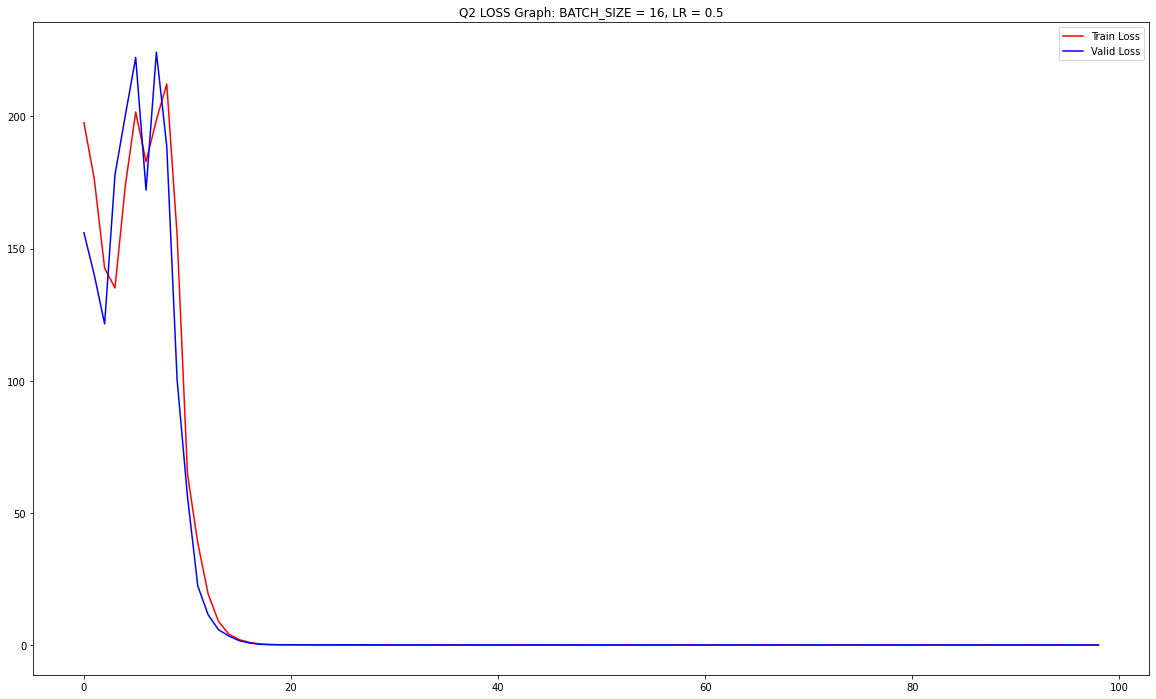

In [69]:
x = np.arange(len(train_loss[1:]))
plt.figure(figsize=(20, 12))
plt.plot(x, train_loss[1:], color='r', label='Train Loss')
plt.plot(x, valid_loss[1:], color='b', label='Valid Loss')
plt.title(f"Q2 LOSS Graph: BATCH_SIZE = {batch_size}, LR = {params['learning_rate']}")
plt.legend()
plt.show()

In [70]:
def test(params, test_loader, path):
    input_size = params['input_size']
    hidden_size = params['hidden_size']
    num_layers = params['num_layers']
    output_size = params['output_size']
    num_outputs = params['num_outputs']
    truths, preds = [[], []], [[], []]
    model = LSTM_multi(input_size, hidden_size, num_layers, output_size, batch_size)
    print(model)
    if MULTI_GPU:
        model = nn.DataParallel(model, device_ids=device_ids)
    model.load_state_dict(torch.load(path)['model'])
    model.to(device)
    
    model.eval()
    for X, y in tqdm(test_loader):
        X = X.to(device)
        for k in range(num_outputs):
            truths[k].extend(y[:, k, :].view(-1).cpu().numpy())
        with torch.no_grad():
            y_hat = model(X)
            for k in range(num_outputs):
                preds[k].extend(y_hat[k, :, :].view(-1).cpu().numpy())
    truths, preds = np.array(truths), np.array(preds)
    for vals in [truths, preds]:
        vals[0] = vals[0] * (test_max_power_range[1] - test_max_power_range[0]) + test_max_power_range[0]
        vals[1] = vals[1] * (test_max_tick_range[1] - test_max_tick_range[0]) + test_max_tick_range[0]
    scores = pd.DataFrame(columns=['MAPE', 'MAE', 'MSE', 'R2 Score'])
    for k in range(num_outputs):
        scores.loc[k, 'MAPE'] = mape(truths[k], preds[k])
        scores.loc[k, 'MAE'] = MAE(truths[k], preds[k])
        scores.loc[k, 'MSE'] = MSE(truths[k], preds[k])
        scores.loc[k, 'R2 Score'] = r2_score(truths[k], preds[k])
    return truths, preds, scores

In [71]:
truths, preds, scores = test(params, test_loader, 'model_max.pth')

LSTM_multi(
  (lstm): LSTM(85, 512, num_layers=20, batch_first=True)
  (linear_pred): Linear(in_features=512, out_features=1, bias=True)
  (linear_time): Linear(in_features=512, out_features=1, bias=True)
)


100%|██████████| 15/15 [00:00<00:00, 37.06it/s]


In [72]:
scores

,MAPE,MAE,MSE,R2 Score
0,18.938303,45728.128906,3156981504.0,-1.340322
1,66.427642,21.146933,672.527039,-3.30908


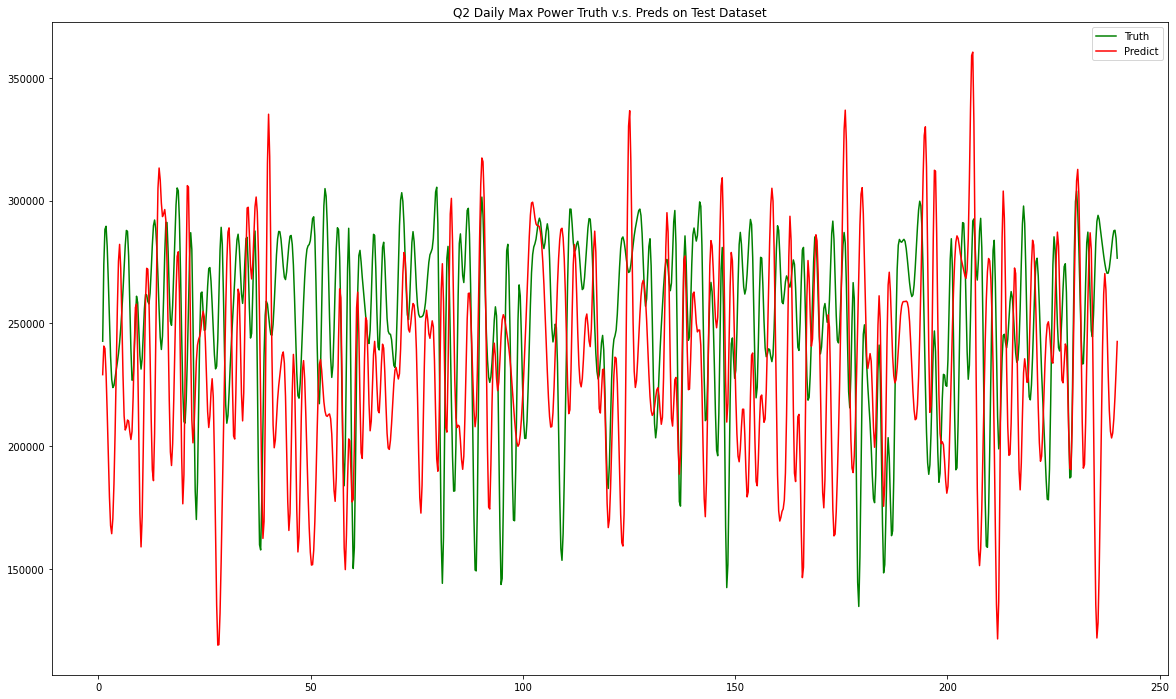

In [73]:
x = [i for i in range(1, len(truths[0]) + 1)]
x_smth = np.linspace(np.min(x), np.max(x), 900)
truths_smth = make_interp_spline(x, truths[0])(x_smth)
preds_smth = make_interp_spline(x, preds[0])(x_smth)
plt.figure(figsize=(20, 12))
plt.plot(x_smth, truths_smth, color='g', label='Truth')
plt.plot(x_smth, preds_smth, color='r', label='Predict')
plt.legend()
plt.title('Q2 Daily Max Power Truth v.s. Preds on Test Dataset')
plt.show()

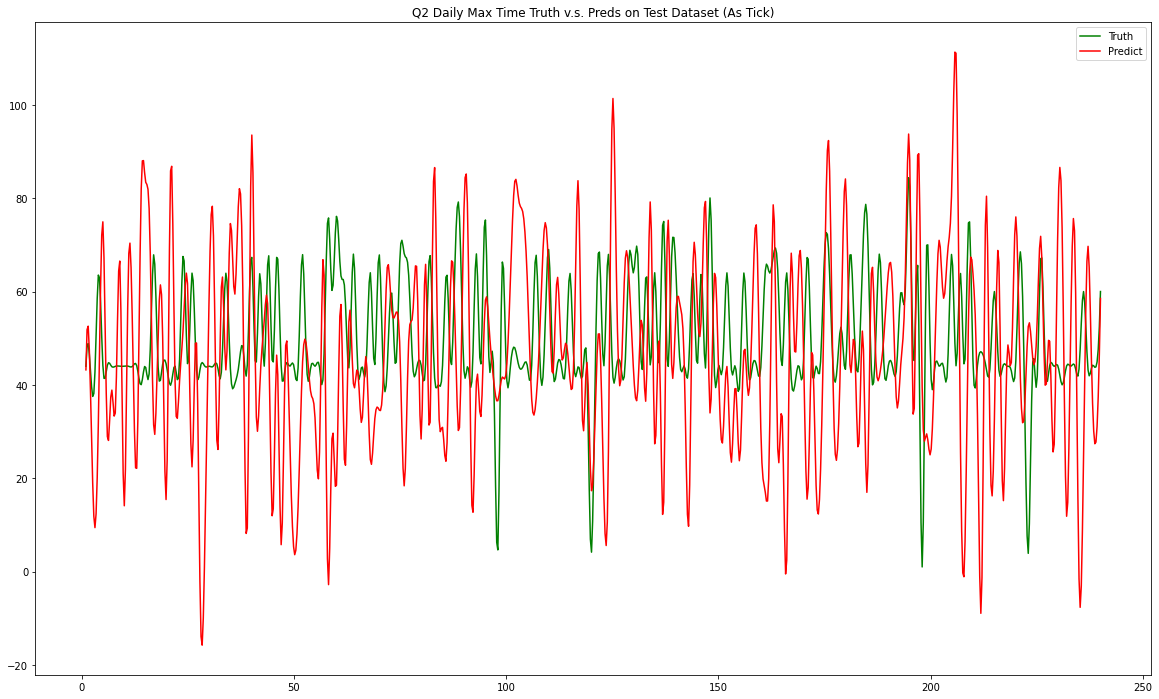

In [74]:
x = [i for i in range(1, len(truths[1]) + 1)]
x_smth = np.linspace(np.min(x), np.max(x), 900)
truths_smth = make_interp_spline(x, truths[1])(x_smth)
preds_smth = make_interp_spline(x, preds[1])(x_smth)
plt.figure(figsize=(20, 12))
plt.plot(x_smth, truths_smth, color='g', label='Truth')
plt.plot(x_smth, preds_smth, color='r', label='Predict')
plt.legend()
plt.title('Q2 Daily Max Time Truth v.s. Preds on Test Dataset (As Tick)')
plt.show()

### 2.1.2 single-output LSTM and train twice Trail

#### 2.1.2.1 Train Model for Power

In [75]:
def preprocessing(data, window_size, predict_size):
    X, y = [], []
    for i in range(len(data) - window_size - predict_size):
        X.append(data[i:i + window_size, 2:])
        y.append(data[i + window_size:i + window_size + predict_size, :1].reshape(1, -1))
    X = torch.FloatTensor(np.array(X))
    y = torch.FloatTensor(np.array(y))
    return X, y

In [76]:
window_size, predict_size = 14, 1

X_train, y_train = preprocessing(train_max, window_size, predict_size)
X_valid, y_valid = preprocessing(valid_max, window_size, predict_size)
X_test, y_test = preprocessing(test_max, window_size, predict_size)

train_data = TensorDataset(X_train, y_train)
valid_data = TensorDataset(X_valid, y_valid)
test_data = TensorDataset(X_test, y_test)

In [77]:
batch_size = 16
train_loader = DataLoader(train_data, batch_size=batch_size * num_gpus,
                          shuffle=True, num_workers=2,
                          drop_last=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size * num_gpus,
                          shuffle=True, num_workers=2,
                          drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size * num_gpus,
                          shuffle=True, num_workers=2,
                          drop_last=True)

In [78]:
def train(params, train_loader, valid_loader, path):
    input_size = params['input_size']
    hidden_size = params['hidden_size']
    num_layers = params['num_layers']
    output_size = params['output_size']
    lr = params['learning_rate']
    wd = params['weight_decay']
    step_size = params['step_size']
    gamma = params['gamma']
    epochs = params['epochs']
    train_loss, valid_loss = [], []
    min_valid_loss = np.inf
    
    model = LSTM(input_size, hidden_size, num_layers, output_size, batch_size)
    print(model)
    if MULTI_GPU:
        model = nn.DataParallel(model, device_ids=device_ids)
    model.to(device)
    
    loss = nn.MSELoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size,
                                                gamma=gamma)
    if MULTI_GPU:
        optimizer = nn.DataParallel(optimizer, device_ids=device_ids)
        scheduler = nn.DataParallel(scheduler, device_ids=device_ids)
        
    for epoch in tqdm(range(epochs)):
        train_ls, valid_ls = [], []
        
        model.train()
        for step, (X, y) in enumerate(train_loader):
            optimizer.zero_grad()
            X = X.to(device)
            y = y.to(device)
            y_hat = model(X)
#             if step == 0:
#                 print(y_hat, y)
            l = loss(y_hat, y)
            train_ls.append(l.item())
            l.backward()
            optimizer.step()
            if step % 100 == 0:
                print("Step {}, train loss {:.6f}".format(step, l.item()))
        train_loss.append(np.mean(train_ls))
        
        model.eval()
        for step, (X, y) in enumerate(valid_loader):
            X = X.to(device)
            y = y.to(device)
            with torch.no_grad():
                y_hat = model(X)
#                 print(y_hat)
            l = loss(y_hat, y)
            valid_ls.append(l.item())
        valid_loss.append(np.mean(valid_ls))
        if valid_loss[-1] < min_valid_loss:
            state = {'model': model.state_dict()}
            torch.save(state, path)
            print('New best performance... Save new model checkpoint.')
            min_valid_loss = valid_loss[-1]
        
        print('Epoch [{:d}/{:d}], train loss {:.6f}, valid loss {:.6f}. Now best: {:.6f}'.format(
                epoch + 1, epochs, train_loss[-1], valid_loss[-1], min_valid_loss))
        scheduler.step()
    
    return train_loss, valid_loss

In [79]:
params = {'input_size': X_train.shape[2],
          'hidden_size': 512,
          'output_size': predict_size,
          'num_layers': 2, 
          'learning_rate': 0.5,
          'weight_decay': 1e-2,
          'step_size': 2,
          'gamma': 0.1,
          'epochs': 100}

In [80]:
train_loss, valid_loss = train(params, train_loader, valid_loader, 'model_max_1.pth')

LSTM(
  (lstm): LSTM(85, 512, num_layers=3, batch_first=True)
  (linear): Linear(in_features=512, out_features=1, bias=True)
)


  0%|          | 0/100 [00:00<?, ?it/s]

Step 0, train loss 0.409996


/opt/conda/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([16, 1, 1])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  1%|          | 1/100 [00:00<01:14,  1.34it/s]

New best performance... Save new model checkpoint.
Epoch [1/100], train loss 139.667164, valid loss 124.143514. Now best: 124.143514
Step 0, train loss 78.423523


  2%|▏         | 2/100 [00:01<01:13,  1.33it/s]

New best performance... Save new model checkpoint.
Epoch [2/100], train loss 104.375685, valid loss 121.790491. Now best: 121.790491
Step 0, train loss 129.263794


  3%|▎         | 3/100 [00:02<01:12,  1.33it/s]

New best performance... Save new model checkpoint.
Epoch [3/100], train loss 63.943095, valid loss 36.349334. Now best: 36.349334
Step 0, train loss 25.243843


  4%|▍         | 4/100 [00:03<01:12,  1.33it/s]

New best performance... Save new model checkpoint.
Epoch [4/100], train loss 28.153512, valid loss 17.738931. Now best: 17.738931
Step 0, train loss 22.869511


  5%|▌         | 5/100 [00:03<01:19,  1.19it/s]

New best performance... Save new model checkpoint.
Epoch [5/100], train loss 19.866708, valid loss 17.512823. Now best: 17.512823
Step 0, train loss 19.349798


  6%|▌         | 6/100 [00:04<01:15,  1.24it/s]

Epoch [6/100], train loss 16.938263, valid loss 18.174285. Now best: 17.512823
Step 0, train loss 13.811079


  7%|▋         | 7/100 [00:05<01:11,  1.30it/s]

Epoch [7/100], train loss 15.031694, valid loss 20.140615. Now best: 17.512823
Step 0, train loss 12.485186


  8%|▊         | 8/100 [00:06<01:10,  1.30it/s]

New best performance... Save new model checkpoint.
Epoch [8/100], train loss 16.700672, valid loss 15.011666. Now best: 15.011666
Step 0, train loss 19.705933


  9%|▉         | 9/100 [00:06<01:08,  1.34it/s]

Epoch [9/100], train loss 16.172201, valid loss 19.064465. Now best: 15.011666
Step 0, train loss 18.188137


 10%|█         | 10/100 [00:07<01:05,  1.37it/s]

Epoch [10/100], train loss 14.978212, valid loss 18.958792. Now best: 15.011666
Step 0, train loss 4.983795


 11%|█         | 11/100 [00:08<01:03,  1.39it/s]

Epoch [11/100], train loss 15.886323, valid loss 19.453637. Now best: 15.011666
Step 0, train loss 16.525494


 12%|█▏        | 12/100 [00:08<01:02,  1.41it/s]

Epoch [12/100], train loss 15.932611, valid loss 17.262994. Now best: 15.011666
Step 0, train loss 11.900798


 13%|█▎        | 13/100 [00:09<01:01,  1.42it/s]

Epoch [13/100], train loss 17.040954, valid loss 16.998913. Now best: 15.011666
Step 0, train loss 18.273268


 14%|█▍        | 14/100 [00:10<01:00,  1.42it/s]

Epoch [14/100], train loss 16.609775, valid loss 17.499342. Now best: 15.011666
Step 0, train loss 9.121944


 15%|█▌        | 15/100 [00:11<00:59,  1.43it/s]

Epoch [15/100], train loss 15.824658, valid loss 16.897414. Now best: 15.011666
Step 0, train loss 11.525362


 16%|█▌        | 16/100 [00:11<01:00,  1.39it/s]

New best performance... Save new model checkpoint.
Epoch [16/100], train loss 16.747711, valid loss 13.469913. Now best: 13.469913
Step 0, train loss 12.173544


 17%|█▋        | 17/100 [00:12<00:59,  1.41it/s]

Epoch [17/100], train loss 18.412041, valid loss 21.349948. Now best: 13.469913
Step 0, train loss 11.380509


 18%|█▊        | 18/100 [00:13<00:58,  1.41it/s]

Epoch [18/100], train loss 16.264110, valid loss 21.002864. Now best: 13.469913
Step 0, train loss 11.000608


 19%|█▉        | 19/100 [00:13<00:57,  1.41it/s]

Epoch [19/100], train loss 16.014745, valid loss 17.597803. Now best: 13.469913
Step 0, train loss 11.033207


 20%|██        | 20/100 [00:14<00:58,  1.37it/s]

Epoch [20/100], train loss 15.911609, valid loss 21.062265. Now best: 13.469913
Step 0, train loss 12.435725


 21%|██        | 21/100 [00:15<00:59,  1.32it/s]

Epoch [21/100], train loss 14.603161, valid loss 16.935799. Now best: 13.469913
Step 0, train loss 11.791753


 22%|██▏       | 22/100 [00:16<00:57,  1.36it/s]

Epoch [22/100], train loss 17.428870, valid loss 18.264143. Now best: 13.469913
Step 0, train loss 16.830189


 23%|██▎       | 23/100 [00:17<01:02,  1.22it/s]

Epoch [23/100], train loss 17.316534, valid loss 19.180860. Now best: 13.469913
Step 0, train loss 13.040400


 24%|██▍       | 24/100 [00:17<01:00,  1.25it/s]

Epoch [24/100], train loss 17.258832, valid loss 15.082613. Now best: 13.469913
Step 0, train loss 13.720444


 25%|██▌       | 25/100 [00:18<00:57,  1.30it/s]

Epoch [25/100], train loss 16.359449, valid loss 15.236556. Now best: 13.469913
Step 0, train loss 13.127947


 26%|██▌       | 26/100 [00:19<00:55,  1.33it/s]

Epoch [26/100], train loss 16.721351, valid loss 15.597883. Now best: 13.469913
Step 0, train loss 13.633200


 27%|██▋       | 27/100 [00:20<00:54,  1.35it/s]

Epoch [27/100], train loss 17.433403, valid loss 19.615409. Now best: 13.469913
Step 0, train loss 8.948925


 28%|██▊       | 28/100 [00:20<00:53,  1.36it/s]

Epoch [28/100], train loss 16.159290, valid loss 18.828079. Now best: 13.469913
Step 0, train loss 22.893593


 29%|██▉       | 29/100 [00:21<00:51,  1.38it/s]

Epoch [29/100], train loss 17.748439, valid loss 18.920871. Now best: 13.469913
Step 0, train loss 7.237703


 30%|███       | 30/100 [00:22<00:50,  1.39it/s]

Epoch [30/100], train loss 16.140137, valid loss 17.170559. Now best: 13.469913
Step 0, train loss 19.459826


 31%|███       | 31/100 [00:22<00:49,  1.41it/s]

Epoch [31/100], train loss 18.198969, valid loss 20.715954. Now best: 13.469913
Step 0, train loss 10.201246


 32%|███▏      | 32/100 [00:23<00:48,  1.42it/s]

Epoch [32/100], train loss 17.712948, valid loss 18.620169. Now best: 13.469913
Step 0, train loss 8.367306


 33%|███▎      | 33/100 [00:24<00:47,  1.42it/s]

Epoch [33/100], train loss 16.045537, valid loss 18.189387. Now best: 13.469913
Step 0, train loss 19.765402


 34%|███▍      | 34/100 [00:25<00:46,  1.43it/s]

Epoch [34/100], train loss 15.769113, valid loss 25.483680. Now best: 13.469913
Step 0, train loss 13.384909


 35%|███▌      | 35/100 [00:25<00:48,  1.34it/s]

Epoch [35/100], train loss 17.541055, valid loss 19.722250. Now best: 13.469913
Step 0, train loss 11.315092


 36%|███▌      | 36/100 [00:26<00:48,  1.33it/s]

Epoch [36/100], train loss 17.370849, valid loss 24.256725. Now best: 13.469913
Step 0, train loss 13.310138


 37%|███▋      | 37/100 [00:27<00:45,  1.37it/s]

Epoch [37/100], train loss 17.311633, valid loss 23.215235. Now best: 13.469913
Step 0, train loss 19.467716


 38%|███▊      | 38/100 [00:28<00:44,  1.39it/s]

Epoch [38/100], train loss 16.925111, valid loss 18.114233. Now best: 13.469913
Step 0, train loss 12.569955


 39%|███▉      | 39/100 [00:28<00:43,  1.41it/s]

Epoch [39/100], train loss 16.705515, valid loss 20.481405. Now best: 13.469913
Step 0, train loss 24.917330


 40%|████      | 40/100 [00:29<00:42,  1.40it/s]

Epoch [40/100], train loss 17.658408, valid loss 16.266328. Now best: 13.469913
Step 0, train loss 17.420227


 41%|████      | 41/100 [00:30<00:41,  1.41it/s]

Epoch [41/100], train loss 15.008331, valid loss 15.305159. Now best: 13.469913
Step 0, train loss 16.553734


 42%|████▏     | 42/100 [00:30<00:40,  1.42it/s]

Epoch [42/100], train loss 15.620999, valid loss 16.362892. Now best: 13.469913
Step 0, train loss 20.376713


 43%|████▎     | 43/100 [00:31<00:40,  1.42it/s]

Epoch [43/100], train loss 16.690704, valid loss 15.069768. Now best: 13.469913
Step 0, train loss 11.161948


 44%|████▍     | 44/100 [00:32<00:39,  1.43it/s]

Epoch [44/100], train loss 15.471049, valid loss 17.124441. Now best: 13.469913
Step 0, train loss 26.957237


 45%|████▌     | 45/100 [00:32<00:38,  1.44it/s]

Epoch [45/100], train loss 16.700894, valid loss 16.087751. Now best: 13.469913
Step 0, train loss 18.823532


 46%|████▌     | 46/100 [00:33<00:37,  1.44it/s]

Epoch [46/100], train loss 16.812826, valid loss 19.793634. Now best: 13.469913
Step 0, train loss 16.146702


 47%|████▋     | 47/100 [00:34<00:36,  1.45it/s]

Epoch [47/100], train loss 17.580422, valid loss 22.034861. Now best: 13.469913
Step 0, train loss 10.610970


 48%|████▊     | 48/100 [00:34<00:36,  1.44it/s]

Epoch [48/100], train loss 16.883542, valid loss 19.913754. Now best: 13.469913
Step 0, train loss 30.593994


 49%|████▉     | 49/100 [00:35<00:35,  1.42it/s]

Epoch [49/100], train loss 17.389876, valid loss 21.787510. Now best: 13.469913
Step 0, train loss 20.514912


 50%|█████     | 50/100 [00:36<00:35,  1.42it/s]

Epoch [50/100], train loss 17.103666, valid loss 17.757407. Now best: 13.469913
Step 0, train loss 21.501692


 51%|█████     | 51/100 [00:37<00:37,  1.32it/s]

Epoch [51/100], train loss 16.792574, valid loss 15.705901. Now best: 13.469913
Step 0, train loss 21.013437


 52%|█████▏    | 52/100 [00:37<00:35,  1.35it/s]

Epoch [52/100], train loss 17.346177, valid loss 17.745750. Now best: 13.469913
Step 0, train loss 16.309132


 53%|█████▎    | 53/100 [00:38<00:34,  1.37it/s]

Epoch [53/100], train loss 16.477904, valid loss 15.746637. Now best: 13.469913
Step 0, train loss 17.906960


 54%|█████▍    | 54/100 [00:39<00:33,  1.38it/s]

Epoch [54/100], train loss 16.932947, valid loss 18.785428. Now best: 13.469913
Step 0, train loss 21.863682


 55%|█████▌    | 55/100 [00:40<00:32,  1.39it/s]

Epoch [55/100], train loss 17.316536, valid loss 17.708479. Now best: 13.469913
Step 0, train loss 13.306856


 56%|█████▌    | 56/100 [00:40<00:31,  1.40it/s]

Epoch [56/100], train loss 17.325083, valid loss 16.322980. Now best: 13.469913
Step 0, train loss 11.009758


 57%|█████▋    | 57/100 [00:41<00:30,  1.40it/s]

Epoch [57/100], train loss 16.559713, valid loss 19.845127. Now best: 13.469913
Step 0, train loss 10.259902


 58%|█████▊    | 58/100 [00:42<00:29,  1.41it/s]

Epoch [58/100], train loss 15.819128, valid loss 15.562893. Now best: 13.469913
Step 0, train loss 16.557526


 59%|█████▉    | 59/100 [00:42<00:29,  1.41it/s]

Epoch [59/100], train loss 16.030573, valid loss 23.768469. Now best: 13.469913
Step 0, train loss 17.681297


 60%|██████    | 60/100 [00:43<00:28,  1.41it/s]

Epoch [60/100], train loss 17.203409, valid loss 20.063987. Now best: 13.469913
Step 0, train loss 19.447302


 61%|██████    | 61/100 [00:44<00:27,  1.42it/s]

Epoch [61/100], train loss 15.328358, valid loss 19.026706. Now best: 13.469913
Step 0, train loss 11.216003


 62%|██████▏   | 62/100 [00:45<00:26,  1.42it/s]

Epoch [62/100], train loss 16.719517, valid loss 16.276971. Now best: 13.469913
Step 0, train loss 35.328766


 63%|██████▎   | 63/100 [00:45<00:25,  1.42it/s]

Epoch [63/100], train loss 16.785220, valid loss 15.834383. Now best: 13.469913
Step 0, train loss 14.552584


 64%|██████▍   | 64/100 [00:46<00:25,  1.43it/s]

Epoch [64/100], train loss 16.606542, valid loss 18.155028. Now best: 13.469913
Step 0, train loss 37.316902


 65%|██████▌   | 65/100 [00:47<00:24,  1.43it/s]

Epoch [65/100], train loss 16.301488, valid loss 20.813722. Now best: 13.469913
Step 0, train loss 12.474516


 66%|██████▌   | 66/100 [00:48<00:29,  1.17it/s]

New best performance... Save new model checkpoint.
Epoch [66/100], train loss 16.536009, valid loss 13.210893. Now best: 13.210893
Step 0, train loss 34.106991


 67%|██████▋   | 67/100 [00:49<00:28,  1.16it/s]

Epoch [67/100], train loss 15.988751, valid loss 15.382987. Now best: 13.210893
Step 0, train loss 16.638403


 68%|██████▊   | 68/100 [00:49<00:25,  1.23it/s]

Epoch [68/100], train loss 16.363014, valid loss 20.058290. Now best: 13.210893
Step 0, train loss 18.982056


 69%|██████▉   | 69/100 [00:50<00:24,  1.29it/s]

Epoch [69/100], train loss 15.122080, valid loss 16.221057. Now best: 13.210893
Step 0, train loss 21.145111


 70%|███████   | 70/100 [00:51<00:22,  1.31it/s]

Epoch [70/100], train loss 16.112533, valid loss 19.946185. Now best: 13.210893
Step 0, train loss 17.709133


 71%|███████   | 71/100 [00:52<00:21,  1.34it/s]

Epoch [71/100], train loss 15.864736, valid loss 17.942414. Now best: 13.210893
Step 0, train loss 12.920343


 72%|███████▏  | 72/100 [00:52<00:20,  1.37it/s]

Epoch [72/100], train loss 16.442571, valid loss 15.459517. Now best: 13.210893
Step 0, train loss 10.950731


 73%|███████▎  | 73/100 [00:53<00:19,  1.39it/s]

Epoch [73/100], train loss 16.646621, valid loss 17.887018. Now best: 13.210893
Step 0, train loss 10.450878


 74%|███████▍  | 74/100 [00:54<00:18,  1.41it/s]

Epoch [74/100], train loss 17.212412, valid loss 20.855337. Now best: 13.210893
Step 0, train loss 8.991931


 75%|███████▌  | 75/100 [00:54<00:17,  1.42it/s]

Epoch [75/100], train loss 16.119955, valid loss 20.811354. Now best: 13.210893
Step 0, train loss 13.629734


 76%|███████▌  | 76/100 [00:55<00:16,  1.42it/s]

Epoch [76/100], train loss 16.359673, valid loss 21.448068. Now best: 13.210893
Step 0, train loss 13.512723


 77%|███████▋  | 77/100 [00:56<00:16,  1.43it/s]

Epoch [77/100], train loss 16.587805, valid loss 16.021734. Now best: 13.210893
Step 0, train loss 13.198469


 78%|███████▊  | 78/100 [00:56<00:15,  1.43it/s]

Epoch [78/100], train loss 16.228465, valid loss 13.320102. Now best: 13.210893
Step 0, train loss 15.349787


 79%|███████▉  | 79/100 [00:57<00:14,  1.43it/s]

Epoch [79/100], train loss 17.133732, valid loss 23.146251. Now best: 13.210893
Step 0, train loss 12.606173


 80%|████████  | 80/100 [00:58<00:13,  1.43it/s]

Epoch [80/100], train loss 15.497052, valid loss 19.205635. Now best: 13.210893
Step 0, train loss 17.092964


 81%|████████  | 81/100 [00:59<00:14,  1.33it/s]

Epoch [81/100], train loss 16.627397, valid loss 21.450342. Now best: 13.210893
Step 0, train loss 13.774117


 82%|████████▏ | 82/100 [00:59<00:13,  1.35it/s]

Epoch [82/100], train loss 17.799396, valid loss 19.222578. Now best: 13.210893
Step 0, train loss 20.598721


 83%|████████▎ | 83/100 [01:00<00:12,  1.37it/s]

Epoch [83/100], train loss 17.487914, valid loss 18.719885. Now best: 13.210893
Step 0, train loss 8.957119


 84%|████████▍ | 84/100 [01:01<00:11,  1.40it/s]

Epoch [84/100], train loss 15.578807, valid loss 18.023432. Now best: 13.210893
Step 0, train loss 25.494135


 85%|████████▌ | 85/100 [01:01<00:10,  1.42it/s]

Epoch [85/100], train loss 17.892767, valid loss 14.696964. Now best: 13.210893
Step 0, train loss 9.660215


 86%|████████▌ | 86/100 [01:02<00:09,  1.43it/s]

Epoch [86/100], train loss 15.748266, valid loss 18.448077. Now best: 13.210893
Step 0, train loss 10.599867


 87%|████████▋ | 87/100 [01:03<00:09,  1.43it/s]

Epoch [87/100], train loss 16.003182, valid loss 22.231623. Now best: 13.210893
Step 0, train loss 11.466044


 88%|████████▊ | 88/100 [01:04<00:08,  1.44it/s]

Epoch [88/100], train loss 16.156795, valid loss 18.728341. Now best: 13.210893
Step 0, train loss 16.550819


 89%|████████▉ | 89/100 [01:04<00:07,  1.44it/s]

Epoch [89/100], train loss 16.196266, valid loss 23.778344. Now best: 13.210893
Step 0, train loss 12.384960


 90%|█████████ | 90/100 [01:05<00:06,  1.44it/s]

Epoch [90/100], train loss 16.144947, valid loss 18.704463. Now best: 13.210893
Step 0, train loss 13.290037


 91%|█████████ | 91/100 [01:06<00:06,  1.44it/s]

Epoch [91/100], train loss 15.834493, valid loss 15.953821. Now best: 13.210893
Step 0, train loss 18.693726


 92%|█████████▏| 92/100 [01:06<00:05,  1.44it/s]

Epoch [92/100], train loss 18.069566, valid loss 20.022516. Now best: 13.210893
Step 0, train loss 19.388847


 93%|█████████▎| 93/100 [01:07<00:04,  1.44it/s]

Epoch [93/100], train loss 17.106457, valid loss 17.827481. Now best: 13.210893
Step 0, train loss 18.615757


 94%|█████████▍| 94/100 [01:08<00:04,  1.44it/s]

Epoch [94/100], train loss 17.881462, valid loss 22.717695. Now best: 13.210893
Step 0, train loss 17.839737


 95%|█████████▌| 95/100 [01:08<00:03,  1.44it/s]

Epoch [95/100], train loss 16.173990, valid loss 19.009189. Now best: 13.210893
Step 0, train loss 18.714676


 96%|█████████▌| 96/100 [01:09<00:02,  1.40it/s]

Epoch [96/100], train loss 16.528984, valid loss 17.901032. Now best: 13.210893
Step 0, train loss 13.566800


 97%|█████████▋| 97/100 [01:10<00:02,  1.35it/s]

Epoch [97/100], train loss 17.398429, valid loss 18.814051. Now best: 13.210893
Step 0, train loss 19.154606


 98%|█████████▊| 98/100 [01:11<00:01,  1.38it/s]

Epoch [98/100], train loss 15.698785, valid loss 16.518405. Now best: 13.210893
Step 0, train loss 9.559959


 99%|█████████▉| 99/100 [01:11<00:00,  1.40it/s]

Epoch [99/100], train loss 16.331655, valid loss 16.571192. Now best: 13.210893
Step 0, train loss 28.595993


100%|██████████| 100/100 [01:12<00:00,  1.38it/s]

Epoch [100/100], train loss 16.009518, valid loss 21.510833. Now best: 13.210893


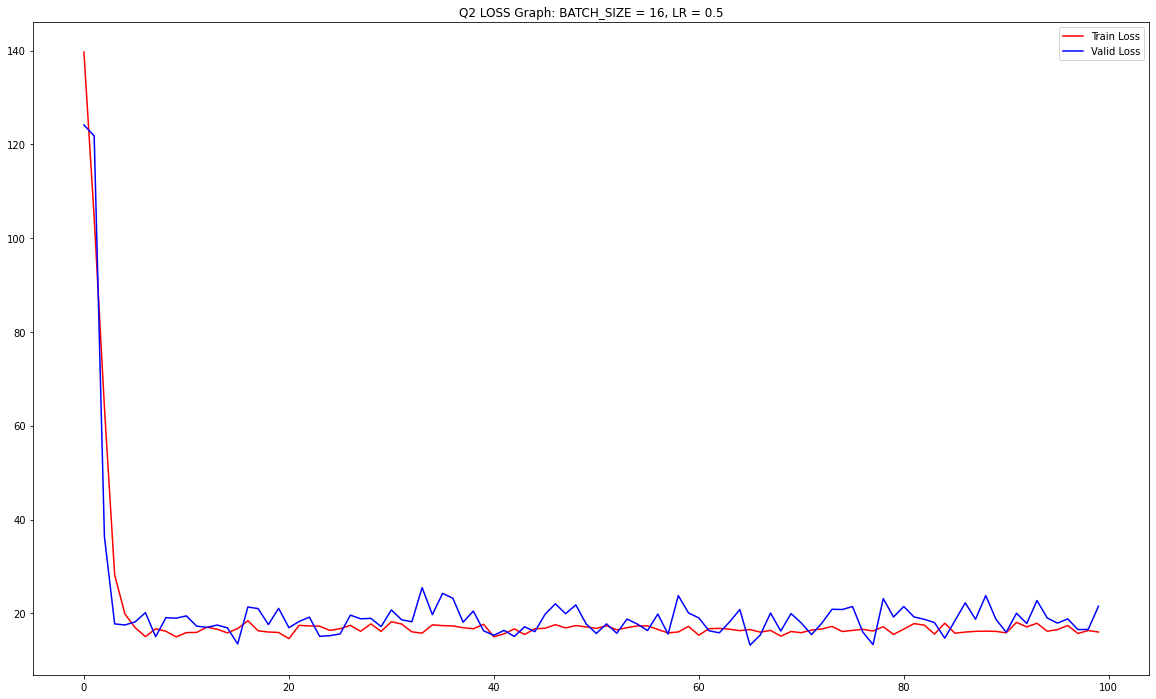

In [81]:
x = np.arange(len(train_loss))
plt.figure(figsize=(20, 12))
plt.plot(x, train_loss, color='r', label='Train Loss')
plt.plot(x, valid_loss, color='b', label='Valid Loss')
plt.title(f"Q2 LOSS Graph: BATCH_SIZE = {batch_size}, LR = {params['learning_rate']}")
plt.legend()
plt.show()

In [82]:
def test(params, test_loader, path):
    input_size = params['input_size']
    hidden_size = params['hidden_size']
    num_layers = params['num_layers']
    output_size = params['output_size']
    truths, preds = [], []
    model = LSTM(input_size, hidden_size, num_layers, output_size, batch_size)
    print(model)
    if MULTI_GPU:
        model = nn.DataParallel(model, device_ids=device_ids)
    model.load_state_dict(torch.load(path)['model'])
    model.to(device)
    
    model.eval()
    for X, y in tqdm(test_loader):
        X = X.to(device)
        truths.extend(y.view(-1).cpu().numpy())
        with torch.no_grad():
            y_hat = model(X)
            preds.extend(y_hat.view(-1).cpu().numpy())
    truths, preds = np.array(truths), np.array(preds)
    truths = truths * (test_max_power_range[1] - test_max_power_range[0]) + test_max_power_range[0]
    preds = preds * (test_max_power_range[1] - test_max_power_range[0]) + test_max_power_range[0]
    print('MAPE:', mape(truths, preds))
    print('MAE:', MAE(truths, preds))
    print('MSE:', MSE(truths, preds))
    print('R2 Score:', r2_score(truths, preds))
    
    return truths, preds

In [83]:
truths, preds = test(params, test_loader, 'model_max_1.pth')

LSTM(
  (lstm): LSTM(85, 512, num_layers=3, batch_first=True)
  (linear): Linear(in_features=512, out_features=1, bias=True)
)


100%|██████████| 15/15 [00:00<00:00, 77.49it/s]

MAPE: 240.69771766662598
MAE: 590248.94
MSE: 521135400000.0
R2 Score: -372.5801870777583


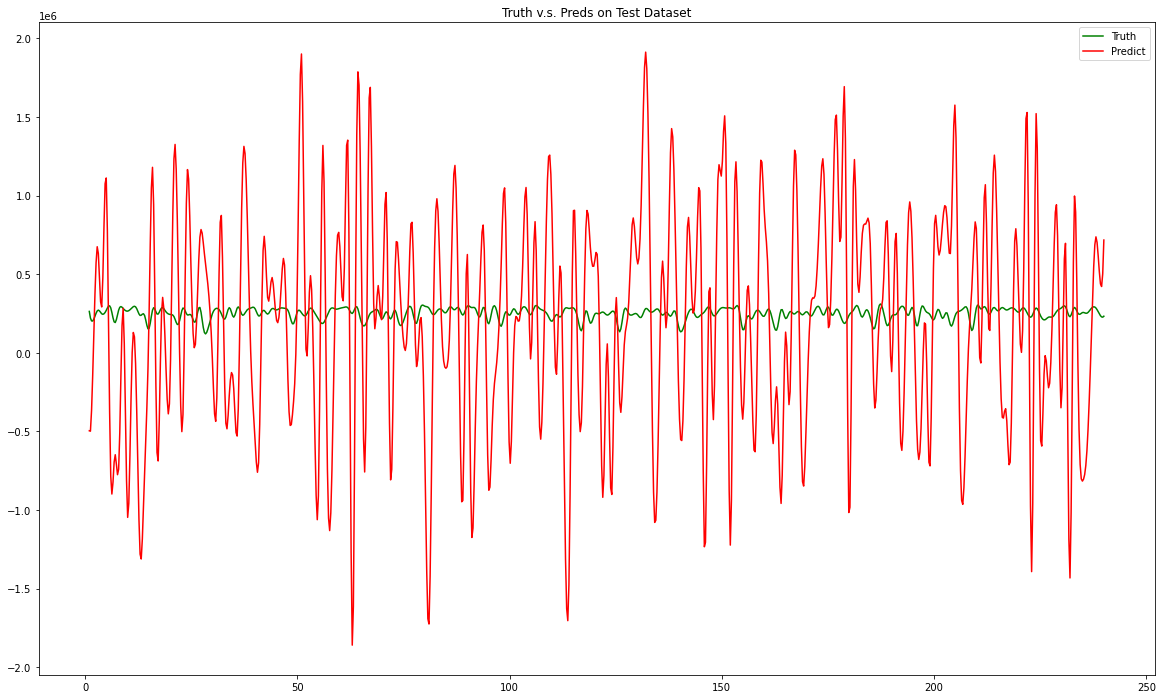

In [84]:
x = [i for i in range(1, len(truths) + 1)]
x_smth = np.linspace(np.min(x), np.max(x), 900)
truths_smth = make_interp_spline(x, truths)(x_smth)
preds_smth = make_interp_spline(x, preds)(x_smth)
plt.figure(figsize=(20, 12))
plt.plot(x_smth, truths_smth, color='g', label='Truth')
plt.plot(x_smth, preds_smth, color='r', label='Predict')
plt.legend()
plt.title('Truth v.s. Preds on Test Dataset')
plt.show()

#### 2.1.2.2 Train Model for Tick

In [85]:
def preprocessing(data, window_size, predict_size):
    X, y = [], []
    for i in range(len(data) - window_size - predict_size):
        X.append(data[i:i + window_size, 2:])
        y.append(data[i + window_size:i + window_size + predict_size, 1:2].reshape(1, -1))
    X = torch.FloatTensor(np.array(X))
    y = torch.FloatTensor(np.array(y))
    return X, y

In [86]:
window_size, predict_size = 14, 1

X_train, y_train = preprocessing(train_max, window_size, predict_size)
X_valid, y_valid = preprocessing(valid_max, window_size, predict_size)
X_test, y_test = preprocessing(test_max, window_size, predict_size)

train_data = TensorDataset(X_train, y_train)
valid_data = TensorDataset(X_valid, y_valid)
test_data = TensorDataset(X_test, y_test)

In [87]:
batch_size = 16
train_loader = DataLoader(train_data, batch_size=batch_size * num_gpus,
                          shuffle=True, num_workers=2,
                          drop_last=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size * num_gpus,
                          shuffle=True, num_workers=2,
                          drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size * num_gpus,
                          shuffle=True, num_workers=2,
                          drop_last=True)

In [88]:
params = {'input_size': X_train.shape[2],
          'hidden_size': 512,
          'output_size': predict_size,
          'num_layers': 2, 
          'learning_rate': 0.5,
          'weight_decay': 1e-3,
          'step_size': 2,
          'gamma': 0.1,
          'epochs': 100}

In [89]:
train_loss, valid_loss = train(params, train_loader, valid_loader, 'model_max_2.pth')

LSTM(
  (lstm): LSTM(85, 512, num_layers=3, batch_first=True)
  (linear): Linear(in_features=512, out_features=1, bias=True)
)


  0%|          | 0/100 [00:00<?, ?it/s]

Step 0, train loss 0.318208


/opt/conda/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([16, 1, 1])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  1%|          | 1/100 [00:00<01:12,  1.36it/s]

New best performance... Save new model checkpoint.
Epoch [1/100], train loss 332.406542, valid loss 191.469385. Now best: 191.469385
Step 0, train loss 119.123306


  2%|▏         | 2/100 [00:01<01:13,  1.34it/s]

New best performance... Save new model checkpoint.
Epoch [2/100], train loss 180.946527, valid loss 133.150375. Now best: 133.150375
Step 0, train loss 149.081665


  3%|▎         | 3/100 [00:02<01:14,  1.31it/s]

New best performance... Save new model checkpoint.
Epoch [3/100], train loss 94.264460, valid loss 72.634037. Now best: 72.634037
Step 0, train loss 31.617619


  4%|▍         | 4/100 [00:03<01:13,  1.31it/s]

New best performance... Save new model checkpoint.
Epoch [4/100], train loss 64.889138, valid loss 52.851253. Now best: 52.851253
Step 0, train loss 84.451042


  5%|▌         | 5/100 [00:03<01:10,  1.35it/s]

Epoch [5/100], train loss 48.672873, valid loss 63.333679. Now best: 52.851253
Step 0, train loss 73.674164


  6%|▌         | 6/100 [00:04<01:14,  1.26it/s]

New best performance... Save new model checkpoint.
Epoch [6/100], train loss 46.996225, valid loss 43.941018. Now best: 43.941018
Step 0, train loss 69.986862


  7%|▋         | 7/100 [00:05<01:10,  1.31it/s]

Epoch [7/100], train loss 46.865409, valid loss 52.288506. Now best: 43.941018
Step 0, train loss 42.414898


  8%|▊         | 8/100 [00:06<01:11,  1.30it/s]

Epoch [8/100], train loss 45.227337, valid loss 51.030672. Now best: 43.941018
Step 0, train loss 36.017830


  9%|▉         | 9/100 [00:07<01:17,  1.18it/s]

Epoch [9/100], train loss 51.108045, valid loss 48.062575. Now best: 43.941018
Step 0, train loss 41.957912


 10%|█         | 10/100 [00:08<01:17,  1.16it/s]

Epoch [10/100], train loss 52.072209, valid loss 44.884538. Now best: 43.941018
Step 0, train loss 40.419205


 11%|█         | 11/100 [00:08<01:13,  1.21it/s]

Epoch [11/100], train loss 50.030999, valid loss 57.167431. Now best: 43.941018
Step 0, train loss 58.290031


 12%|█▏        | 12/100 [00:09<01:09,  1.27it/s]

Epoch [12/100], train loss 50.475764, valid loss 54.561632. Now best: 43.941018
Step 0, train loss 30.709732


 13%|█▎        | 13/100 [00:10<01:07,  1.28it/s]

New best performance... Save new model checkpoint.
Epoch [13/100], train loss 53.856862, valid loss 38.942330. Now best: 38.942330
Step 0, train loss 75.936211


 14%|█▍        | 14/100 [00:10<01:05,  1.32it/s]

Epoch [14/100], train loss 49.584304, valid loss 56.136130. Now best: 38.942330
Step 0, train loss 45.228161


 15%|█▌        | 15/100 [00:11<01:02,  1.36it/s]

Epoch [15/100], train loss 48.126510, valid loss 53.561836. Now best: 38.942330
Step 0, train loss 26.067722


 16%|█▌        | 16/100 [00:12<01:02,  1.34it/s]

New best performance... Save new model checkpoint.
Epoch [16/100], train loss 48.909029, valid loss 33.710999. Now best: 33.710999
Step 0, train loss 63.391445


 17%|█▋        | 17/100 [00:13<01:01,  1.36it/s]

Epoch [17/100], train loss 48.512625, valid loss 63.885019. Now best: 33.710999
Step 0, train loss 55.999195


 18%|█▊        | 18/100 [00:13<00:59,  1.38it/s]

Epoch [18/100], train loss 46.868816, valid loss 46.207611. Now best: 33.710999
Step 0, train loss 34.633987


 19%|█▉        | 19/100 [00:14<00:58,  1.40it/s]

Epoch [19/100], train loss 45.811339, valid loss 39.473428. Now best: 33.710999
Step 0, train loss 45.404373


 20%|██        | 20/100 [00:15<00:56,  1.40it/s]

Epoch [20/100], train loss 46.923005, valid loss 54.485380. Now best: 33.710999
Step 0, train loss 45.415657


 21%|██        | 21/100 [00:15<00:56,  1.41it/s]

Epoch [21/100], train loss 44.420538, valid loss 67.081115. Now best: 33.710999
Step 0, train loss 39.491776


 22%|██▏       | 22/100 [00:16<00:55,  1.42it/s]

Epoch [22/100], train loss 48.264469, valid loss 54.544944. Now best: 33.710999
Step 0, train loss 64.486282


 23%|██▎       | 23/100 [00:17<00:54,  1.42it/s]

Epoch [23/100], train loss 44.310726, valid loss 44.219847. Now best: 33.710999
Step 0, train loss 35.227837


 24%|██▍       | 24/100 [00:18<00:54,  1.39it/s]

Epoch [24/100], train loss 48.451706, valid loss 43.504175. Now best: 33.710999
Step 0, train loss 43.439316


 25%|██▌       | 25/100 [00:19<00:59,  1.27it/s]

Epoch [25/100], train loss 48.427772, valid loss 49.185873. Now best: 33.710999
Step 0, train loss 64.464851


 26%|██▌       | 26/100 [00:19<01:00,  1.23it/s]

Epoch [26/100], train loss 51.731366, valid loss 45.764695. Now best: 33.710999
Step 0, train loss 46.051826


 27%|██▋       | 27/100 [00:20<00:57,  1.27it/s]

Epoch [27/100], train loss 50.181174, valid loss 60.563285. Now best: 33.710999
Step 0, train loss 92.291458


 28%|██▊       | 28/100 [00:21<00:55,  1.31it/s]

Epoch [28/100], train loss 46.478234, valid loss 56.124271. Now best: 33.710999
Step 0, train loss 37.563519


 29%|██▉       | 29/100 [00:22<00:53,  1.33it/s]

Epoch [29/100], train loss 47.162341, valid loss 60.357964. Now best: 33.710999
Step 0, train loss 67.038559


 30%|███       | 30/100 [00:22<00:51,  1.35it/s]

Epoch [30/100], train loss 49.505243, valid loss 66.063075. Now best: 33.710999
Step 0, train loss 44.419212


 31%|███       | 31/100 [00:23<00:50,  1.36it/s]

Epoch [31/100], train loss 48.329465, valid loss 37.967342. Now best: 33.710999
Step 0, train loss 56.011662


 32%|███▏      | 32/100 [00:24<00:49,  1.37it/s]

Epoch [32/100], train loss 46.433156, valid loss 51.408422. Now best: 33.710999
Step 0, train loss 60.669384


 33%|███▎      | 33/100 [00:24<00:48,  1.38it/s]

Epoch [33/100], train loss 46.796794, valid loss 52.288446. Now best: 33.710999
Step 0, train loss 48.531025


 34%|███▍      | 34/100 [00:25<00:47,  1.39it/s]

Epoch [34/100], train loss 50.874401, valid loss 61.347726. Now best: 33.710999
Step 0, train loss 36.739044


 35%|███▌      | 35/100 [00:26<00:46,  1.39it/s]

Epoch [35/100], train loss 49.386738, valid loss 48.101753. Now best: 33.710999
Step 0, train loss 44.626328


 36%|███▌      | 36/100 [00:27<00:46,  1.38it/s]

Epoch [36/100], train loss 44.107529, valid loss 61.906113. Now best: 33.710999
Step 0, train loss 40.376156


 37%|███▋      | 37/100 [00:27<00:45,  1.38it/s]

Epoch [37/100], train loss 48.076303, valid loss 59.339858. Now best: 33.710999
Step 0, train loss 57.076347


 38%|███▊      | 38/100 [00:28<00:44,  1.39it/s]

Epoch [38/100], train loss 49.060096, valid loss 36.779754. Now best: 33.710999
Step 0, train loss 53.115013


 39%|███▉      | 39/100 [00:29<00:43,  1.41it/s]

Epoch [39/100], train loss 49.091546, valid loss 62.954412. Now best: 33.710999
Step 0, train loss 50.661385


 40%|████      | 40/100 [00:29<00:42,  1.42it/s]

Epoch [40/100], train loss 47.078298, valid loss 39.017158. Now best: 33.710999
Step 0, train loss 70.570679


 41%|████      | 41/100 [00:30<00:43,  1.37it/s]

Epoch [41/100], train loss 48.177833, valid loss 49.024155. Now best: 33.710999
Step 0, train loss 52.331978


 42%|████▏     | 42/100 [00:31<00:41,  1.39it/s]

Epoch [42/100], train loss 47.542371, valid loss 58.815227. Now best: 33.710999
Step 0, train loss 32.632309


 43%|████▎     | 43/100 [00:32<00:40,  1.39it/s]

Epoch [43/100], train loss 48.674290, valid loss 59.150039. Now best: 33.710999
Step 0, train loss 33.134941


 44%|████▍     | 44/100 [00:32<00:39,  1.41it/s]

Epoch [44/100], train loss 46.782501, valid loss 49.265784. Now best: 33.710999
Step 0, train loss 36.789536


 45%|████▌     | 45/100 [00:33<00:38,  1.43it/s]

Epoch [45/100], train loss 47.948013, valid loss 62.481476. Now best: 33.710999
Step 0, train loss 41.832478


 46%|████▌     | 46/100 [00:34<00:37,  1.44it/s]

Epoch [46/100], train loss 46.460451, valid loss 52.373131. Now best: 33.710999
Step 0, train loss 43.192207


 47%|████▋     | 47/100 [00:34<00:36,  1.44it/s]

Epoch [47/100], train loss 51.496113, valid loss 57.364865. Now best: 33.710999
Step 0, train loss 65.881523


 48%|████▊     | 48/100 [00:35<00:36,  1.44it/s]

Epoch [48/100], train loss 48.930231, valid loss 48.278675. Now best: 33.710999
Step 0, train loss 54.093761


 49%|████▉     | 49/100 [00:36<00:35,  1.43it/s]

Epoch [49/100], train loss 47.206998, valid loss 50.031708. Now best: 33.710999
Step 0, train loss 66.581970


 50%|█████     | 50/100 [00:36<00:34,  1.43it/s]

Epoch [50/100], train loss 51.453920, valid loss 47.855284. Now best: 33.710999
Step 0, train loss 28.162121


 51%|█████     | 51/100 [00:37<00:35,  1.38it/s]

Epoch [51/100], train loss 49.410607, valid loss 46.881660. Now best: 33.710999
Step 0, train loss 51.918709


 52%|█████▏    | 52/100 [00:38<00:38,  1.24it/s]

Epoch [52/100], train loss 49.433532, valid loss 61.572506. Now best: 33.710999
Step 0, train loss 36.722069


 53%|█████▎    | 53/100 [00:39<00:37,  1.26it/s]

Epoch [53/100], train loss 46.532766, valid loss 55.857124. Now best: 33.710999
Step 0, train loss 88.494431


 54%|█████▍    | 54/100 [00:40<00:35,  1.31it/s]

Epoch [54/100], train loss 48.707812, valid loss 60.082620. Now best: 33.710999
Step 0, train loss 43.015892


 55%|█████▌    | 55/100 [00:40<00:33,  1.34it/s]

Epoch [55/100], train loss 44.193316, valid loss 44.006596. Now best: 33.710999
Step 0, train loss 82.302124


 56%|█████▌    | 56/100 [00:41<00:32,  1.37it/s]

Epoch [56/100], train loss 52.526522, valid loss 45.156896. Now best: 33.710999
Step 0, train loss 53.221893


 57%|█████▋    | 57/100 [00:42<00:30,  1.39it/s]

Epoch [57/100], train loss 45.256451, valid loss 45.345621. Now best: 33.710999
Step 0, train loss 36.194885


 58%|█████▊    | 58/100 [00:42<00:29,  1.41it/s]

Epoch [58/100], train loss 48.545597, valid loss 51.223834. Now best: 33.710999
Step 0, train loss 18.559597


 59%|█████▉    | 59/100 [00:43<00:29,  1.41it/s]

Epoch [59/100], train loss 47.677116, valid loss 46.493282. Now best: 33.710999
Step 0, train loss 71.735825


 60%|██████    | 60/100 [00:44<00:28,  1.42it/s]

Epoch [60/100], train loss 48.415174, valid loss 45.784911. Now best: 33.710999
Step 0, train loss 67.065353


 61%|██████    | 61/100 [00:45<00:27,  1.43it/s]

Epoch [61/100], train loss 48.860560, valid loss 37.745810. Now best: 33.710999
Step 0, train loss 81.595764


 62%|██████▏   | 62/100 [00:45<00:26,  1.43it/s]

Epoch [62/100], train loss 51.995231, valid loss 43.278251. Now best: 33.710999
Step 0, train loss 52.530567


 63%|██████▎   | 63/100 [00:46<00:25,  1.44it/s]

Epoch [63/100], train loss 47.226727, valid loss 56.996817. Now best: 33.710999
Step 0, train loss 42.368763


 64%|██████▍   | 64/100 [00:47<00:25,  1.43it/s]

Epoch [64/100], train loss 48.975632, valid loss 50.540202. Now best: 33.710999
Step 0, train loss 23.482265


 65%|██████▌   | 65/100 [00:47<00:24,  1.43it/s]

Epoch [65/100], train loss 47.375252, valid loss 63.573101. Now best: 33.710999
Step 0, train loss 25.644606


 66%|██████▌   | 66/100 [00:48<00:23,  1.44it/s]

Epoch [66/100], train loss 43.506695, valid loss 62.554680. Now best: 33.710999
Step 0, train loss 59.936142


 67%|██████▋   | 67/100 [00:49<00:22,  1.44it/s]

Epoch [67/100], train loss 51.134259, valid loss 46.108310. Now best: 33.710999
Step 0, train loss 62.908264


 68%|██████▊   | 68/100 [00:49<00:22,  1.44it/s]

Epoch [68/100], train loss 47.595817, valid loss 49.341778. Now best: 33.710999
Step 0, train loss 54.609085


 69%|██████▉   | 69/100 [00:50<00:21,  1.44it/s]

Epoch [69/100], train loss 51.834367, valid loss 48.404468. Now best: 33.710999
Step 0, train loss 60.105431


 70%|███████   | 70/100 [00:51<00:20,  1.44it/s]

Epoch [70/100], train loss 49.522620, valid loss 59.919439. Now best: 33.710999
Step 0, train loss 61.086571


 71%|███████   | 71/100 [00:51<00:20,  1.44it/s]

Epoch [71/100], train loss 47.571116, valid loss 50.604911. Now best: 33.710999
Step 0, train loss 32.071732


 72%|███████▏  | 72/100 [00:52<00:19,  1.44it/s]

Epoch [72/100], train loss 50.178737, valid loss 65.376892. Now best: 33.710999
Step 0, train loss 29.127047


 73%|███████▎  | 73/100 [00:53<00:18,  1.44it/s]

Epoch [73/100], train loss 49.777636, valid loss 40.306766. Now best: 33.710999
Step 0, train loss 44.931049


 74%|███████▍  | 74/100 [00:54<00:18,  1.44it/s]

Epoch [74/100], train loss 47.047164, valid loss 44.221804. Now best: 33.710999
Step 0, train loss 52.828125


 75%|███████▌  | 75/100 [00:54<00:17,  1.43it/s]

Epoch [75/100], train loss 46.761665, valid loss 45.581784. Now best: 33.710999
Step 0, train loss 29.077393


 76%|███████▌  | 76/100 [00:55<00:16,  1.43it/s]

Epoch [76/100], train loss 45.113456, valid loss 58.380299. Now best: 33.710999
Step 0, train loss 37.450031


 77%|███████▋  | 77/100 [00:56<00:16,  1.43it/s]

Epoch [77/100], train loss 50.090832, valid loss 48.486431. Now best: 33.710999
Step 0, train loss 38.879128


 78%|███████▊  | 78/100 [00:56<00:15,  1.43it/s]

Epoch [78/100], train loss 50.441126, valid loss 50.948995. Now best: 33.710999
Step 0, train loss 86.344238


 79%|███████▉  | 79/100 [00:57<00:14,  1.44it/s]

Epoch [79/100], train loss 46.485025, valid loss 43.250304. Now best: 33.710999
Step 0, train loss 52.152744


 80%|████████  | 80/100 [00:58<00:13,  1.43it/s]

Epoch [80/100], train loss 51.644714, valid loss 50.078935. Now best: 33.710999
Step 0, train loss 45.183620


 81%|████████  | 81/100 [00:58<00:13,  1.43it/s]

Epoch [81/100], train loss 45.833184, valid loss 55.131369. Now best: 33.710999
Step 0, train loss 86.228775


 82%|████████▏ | 82/100 [00:59<00:12,  1.42it/s]

Epoch [82/100], train loss 48.741316, valid loss 44.889849. Now best: 33.710999
Step 0, train loss 60.774849


 83%|████████▎ | 83/100 [01:00<00:11,  1.43it/s]

Epoch [83/100], train loss 44.459442, valid loss 56.451003. Now best: 33.710999
Step 0, train loss 66.102974


 84%|████████▍ | 84/100 [01:01<00:11,  1.43it/s]

Epoch [84/100], train loss 49.289788, valid loss 60.695869. Now best: 33.710999
Step 0, train loss 72.177628


 85%|████████▌ | 85/100 [01:01<00:10,  1.43it/s]

Epoch [85/100], train loss 49.669364, valid loss 57.364401. Now best: 33.710999
Step 0, train loss 19.803762


 86%|████████▌ | 86/100 [01:02<00:09,  1.43it/s]

Epoch [86/100], train loss 48.777304, valid loss 44.591391. Now best: 33.710999
Step 0, train loss 29.133478


 87%|████████▋ | 87/100 [01:03<00:09,  1.43it/s]

Epoch [87/100], train loss 46.964951, valid loss 43.581048. Now best: 33.710999
Step 0, train loss 16.649715


 88%|████████▊ | 88/100 [01:03<00:08,  1.43it/s]

Epoch [88/100], train loss 48.985241, valid loss 40.020604. Now best: 33.710999
Step 0, train loss 65.709473


 89%|████████▉ | 89/100 [01:04<00:07,  1.43it/s]

Epoch [89/100], train loss 49.934575, valid loss 59.484214. Now best: 33.710999
Step 0, train loss 65.229538


 90%|█████████ | 90/100 [01:05<00:06,  1.43it/s]

Epoch [90/100], train loss 50.396028, valid loss 45.116996. Now best: 33.710999
Step 0, train loss 25.006039


 91%|█████████ | 91/100 [01:05<00:06,  1.43it/s]

Epoch [91/100], train loss 48.690521, valid loss 45.889295. Now best: 33.710999
Step 0, train loss 61.642426


 92%|█████████▏| 92/100 [01:06<00:05,  1.43it/s]

Epoch [92/100], train loss 48.722599, valid loss 39.222463. Now best: 33.710999
Step 0, train loss 38.829697


 93%|█████████▎| 93/100 [01:07<00:04,  1.43it/s]

Epoch [93/100], train loss 48.205988, valid loss 44.448832. Now best: 33.710999
Step 0, train loss 52.417137


 94%|█████████▍| 94/100 [01:08<00:04,  1.42it/s]

Epoch [94/100], train loss 48.971793, valid loss 42.835979. Now best: 33.710999
Step 0, train loss 35.988083


 95%|█████████▌| 95/100 [01:08<00:03,  1.38it/s]

Epoch [95/100], train loss 45.456768, valid loss 39.710351. Now best: 33.710999
Step 0, train loss 55.750057


 96%|█████████▌| 96/100 [01:10<00:03,  1.15it/s]

Epoch [96/100], train loss 47.991482, valid loss 45.741840. Now best: 33.710999
Step 0, train loss 37.279213


 97%|█████████▋| 97/100 [01:11<00:02,  1.09it/s]

Epoch [97/100], train loss 48.693457, valid loss 56.550425. Now best: 33.710999
Step 0, train loss 73.754883


 98%|█████████▊| 98/100 [01:11<00:01,  1.17it/s]

Epoch [98/100], train loss 52.326175, valid loss 50.921562. Now best: 33.710999
Step 0, train loss 56.776596


 99%|█████████▉| 99/100 [01:12<00:00,  1.23it/s]

Epoch [99/100], train loss 49.331290, valid loss 44.701827. Now best: 33.710999
Step 0, train loss 57.798309


100%|██████████| 100/100 [01:13<00:00,  1.37it/s]

Epoch [100/100], train loss 47.952601, valid loss 49.876111. Now best: 33.710999


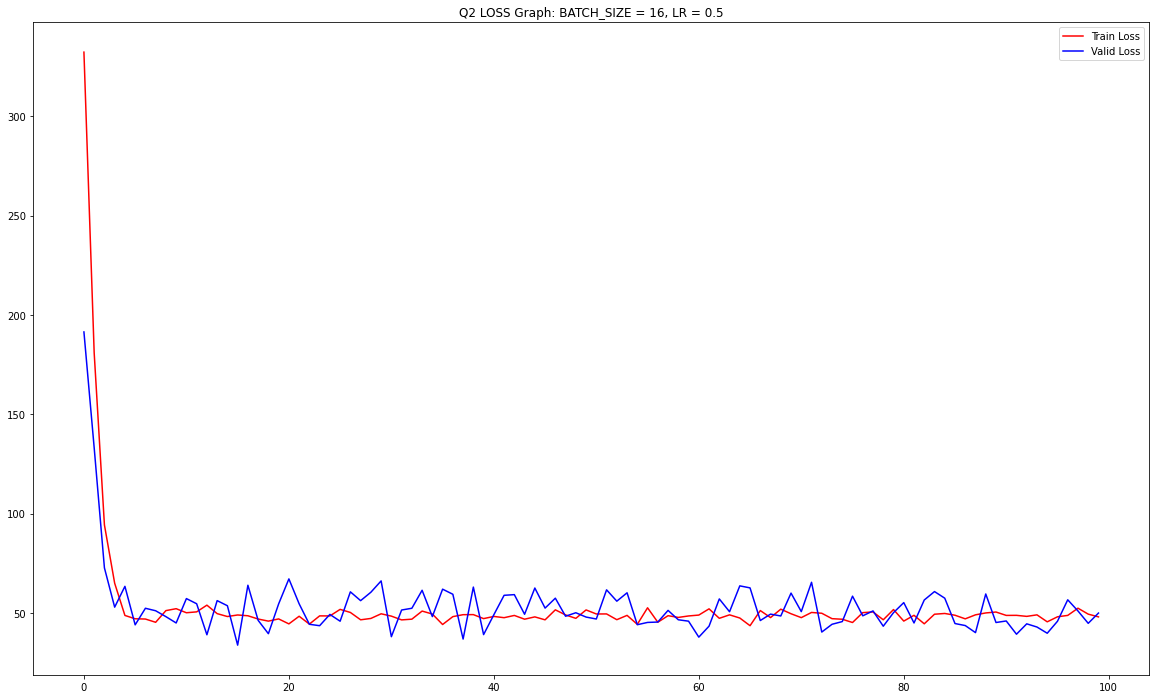

In [90]:
x = np.arange(len(train_loss))
plt.figure(figsize=(20, 12))
plt.plot(x, train_loss, color='r', label='Train Loss')
plt.plot(x, valid_loss, color='b', label='Valid Loss')
plt.title(f"Q2 LOSS Graph: BATCH_SIZE = {batch_size}, LR = {params['learning_rate']}")
plt.legend()
plt.show()

In [91]:
def test(params, test_loader, path):
    input_size = params['input_size']
    hidden_size = params['hidden_size']
    num_layers = params['num_layers']
    output_size = params['output_size']
    truths, preds = [], []
    model = LSTM(input_size, hidden_size, num_layers, output_size, batch_size)
    print(model)
    if MULTI_GPU:
        model = nn.DataParallel(model, device_ids=device_ids)
    model.load_state_dict(torch.load(path)['model'])
    model.to(device)
    
    model.eval()
    for X, y in tqdm(test_loader):
        X = X.to(device)
        truths.extend(y.view(-1).cpu().numpy())
        with torch.no_grad():
            y_hat = model(X)
            preds.extend(y_hat.view(-1).cpu().numpy())
    truths, preds = np.array(truths), np.array(preds)
    truths = truths * (test_max_tick_range[1] - test_max_tick_range[0]) + test_max_tick_range[0]
    preds = preds * (test_max_tick_range[1] - test_max_tick_range[0]) + test_max_tick_range[0]
    print('MAPE:', mape(truths, preds))
    print('MAE:', MAE(truths, preds))
    print('MSE:', MSE(truths, preds))
    print('R2 Score:', r2_score(truths, preds))
    
    return truths, preds

In [92]:
truths, preds = test(params, test_loader, 'model_max_2.pth')

LSTM(
  (lstm): LSTM(85, 512, num_layers=3, batch_first=True)
  (linear): Linear(in_features=512, out_features=1, bias=True)
)


100%|██████████| 15/15 [00:00<00:00, 79.12it/s]

MAPE: 1531.2752723693848
MAE: 494.1054
MSE: 372875.78
R2 Score: -2474.6290365307964


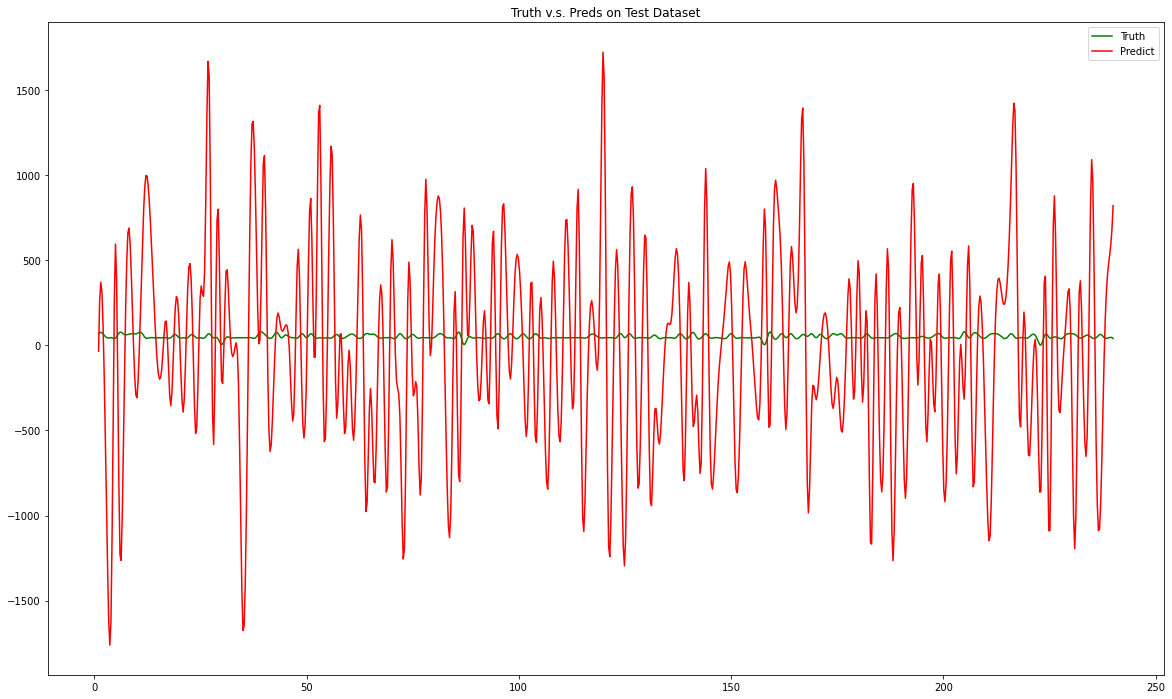

In [93]:
x = [i for i in range(1, len(truths) + 1)]
x_smth = np.linspace(np.min(x), np.max(x), 900)
truths_smth = make_interp_spline(x, truths)(x_smth)
preds_smth = make_interp_spline(x, preds)(x_smth)
plt.figure(figsize=(20, 12))
plt.plot(x_smth, truths_smth, color='g', label='Truth')
plt.plot(x_smth, preds_smth, color='r', label='Predict')
plt.legend()
plt.title('Truth v.s. Preds on Test Dataset')
plt.show()

## 2.2 For Daily Min

In [114]:
def preprocessing(data, window_size, predict_size):
    X, y = [], []
    for i in range(len(data) - window_size - predict_size):
        X.append(data[i:i + window_size, 2:])
        y.append(data[i + window_size:i + window_size + predict_size, :2].reshape(2, -1))
    X = torch.FloatTensor(np.array(X))
    y = torch.FloatTensor(np.array(y))
    return X, y

In [115]:
window_size, predict_size = 14, 1

X_train, y_train = preprocessing(train_min, window_size, predict_size)
X_valid, y_valid = preprocessing(valid_min, window_size, predict_size)
X_test, y_test = preprocessing(test_min, window_size, predict_size)

In [116]:
train_data = TensorDataset(X_train, y_train)
valid_data = TensorDataset(X_valid, y_valid)
test_data = TensorDataset(X_test, y_test)

In [117]:
batch_size = 16
train_loader = DataLoader(train_data, batch_size=batch_size * num_gpus,
                          shuffle=True, num_workers=2,
                          drop_last=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size * num_gpus,
                          shuffle=True, num_workers=2,
                          drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size * num_gpus,
                          shuffle=True, num_workers=2,
                          drop_last=True)

In [118]:
print('Train set:', X_train.shape, y_train.shape)
print('Valid set:', X_valid.shape, y_valid.shape)
print('Test set:', X_test.shape, y_test.shape)

Train set: torch.Size([922, 14, 85]) torch.Size([922, 2, 1])
Valid set: torch.Size([118, 14, 85]) torch.Size([118, 2, 1])
Test set: torch.Size([254, 14, 85]) torch.Size([254, 2, 1])


In [119]:
params = {'input_size': X_train.shape[2],
          'hidden_size': 512,
          'output_size': predict_size,
          'num_outputs': 2,
          'num_layers': 20, 
          'learning_rate': 0.5,
          'weight_decay': 1e-2,
          'step_size': 10,
          'gamma': 0.1,
          'epochs': 100}

In [120]:
def train(params, train_loader, valid_loader, path):
    input_size = params['input_size']
    hidden_size = params['hidden_size']
    num_layers = params['num_layers']
    output_size = params['output_size']
    lr = params['learning_rate']
    wd = params['weight_decay']
    step_size = params['step_size']
    gamma = params['gamma']
    epochs = params['epochs']
    num_outputs = params['num_outputs']
    train_loss, valid_loss = [], []
    min_valid_loss = np.inf
    
    model = LSTM_multi(input_size, hidden_size, num_layers, output_size, batch_size)
    print(model)
    if MULTI_GPU:
        model = nn.DataParallel(model, device_ids=device_ids)
    model.to(device)
    
    loss = nn.MSELoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size,
                                                gamma=gamma)
    if MULTI_GPU:
        optimizer = nn.DataParallel(optimizer, device_ids=device_ids)
        scheduler = nn.DataParallel(scheduler, device_ids=device_ids)
        
    for epoch in tqdm(range(epochs)):
        train_ls, valid_ls = [], []
        
        model.train()
        for step, (X, y) in enumerate(train_loader):
            X = X.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            l = 0
            for k in range(num_outputs):
                l += loss(y_hat[k, :, :], y[:, k, :])
            l /= num_outputs
            train_ls.append(l.item())
            l.backward()
            optimizer.step()
            if step % 10 == 0:
                print("Step {}, train loss {:.6f}".format(step, l.item()))
        train_loss.append(np.mean(train_ls))
        
        model.eval()
        for step, (X, y) in enumerate(valid_loader):
            X = X.to(device)
            y = y.to(device)
            with torch.no_grad():
                y_hat = model(X)
            l = 0
            for k in range(num_outputs):
                l += loss(y_hat[k, :, :], y[:, k, :])
            l /= num_outputs
            valid_ls.append(l.item())
        valid_loss.append(np.mean(valid_ls))
        if valid_loss[-1] < min_valid_loss:
            state = {'model': model.state_dict()}
            torch.save(state, path)
            min_valid_loss = valid_loss[-1]
        
        print('Epoch [{:d}/{:d}], train loss {:.6f}, valid loss {:.6f}. Now best: {:.6f}'.format(
                epoch + 1, epochs, train_loss[-1], valid_loss[-1], min_valid_loss))
        scheduler.step()
    
    return train_loss, valid_loss

In [121]:
train_loss, valid_loss = train(params, train_loader, valid_loader, 'model_min.pth')

LSTM_multi(
  (lstm): LSTM(85, 512, num_layers=20, batch_first=True)
  (linear_pred): Linear(in_features=512, out_features=1, bias=True)
  (linear_time): Linear(in_features=512, out_features=1, bias=True)
)


  0%|          | 0/100 [00:00<?, ?it/s]

Step 0, train loss 0.224123
Step 10, train loss 187.295090
Step 20, train loss 105.542023
Step 30, train loss 118.407204
Step 40, train loss 170.375854
Step 50, train loss 216.200424


  1%|          | 1/100 [00:03<06:04,  3.68s/it]

Epoch [1/100], train loss 163.238213, valid loss 209.109538. Now best: 209.109538
Step 0, train loss 244.532196
Step 10, train loss 246.923706
Step 20, train loss 196.866699
Step 30, train loss 232.276459
Step 40, train loss 218.166687
Step 50, train loss 180.811401


  2%|▏         | 2/100 [00:07<06:04,  3.72s/it]

Epoch [2/100], train loss 217.086787, valid loss 164.209099. Now best: 164.209099
Step 0, train loss 117.527954
Step 10, train loss 180.343445
Step 20, train loss 212.976715
Step 30, train loss 177.139648
Step 40, train loss 164.098831
Step 50, train loss 214.298569


  3%|▎         | 3/100 [00:10<05:36,  3.47s/it]

Epoch [3/100], train loss 178.677087, valid loss 189.473527. Now best: 164.209099
Step 0, train loss 230.154358
Step 10, train loss 249.296661
Step 20, train loss 204.828857
Step 30, train loss 243.130707
Step 40, train loss 269.337189
Step 50, train loss 255.729599


  4%|▍         | 4/100 [00:13<05:26,  3.41s/it]

Epoch [4/100], train loss 205.123720, valid loss 215.907045. Now best: 164.209099
Step 0, train loss 178.756943
Step 10, train loss 140.065094
Step 20, train loss 295.303741
Step 30, train loss 138.705307
Step 40, train loss 144.251495
Step 50, train loss 134.261444


  5%|▌         | 5/100 [00:17<05:36,  3.54s/it]

Epoch [5/100], train loss 191.193266, valid loss 151.013605. Now best: 151.013605
Step 0, train loss 215.900833
Step 10, train loss 147.242401
Step 20, train loss 231.131348
Step 30, train loss 175.764938
Step 40, train loss 271.176758
Step 50, train loss 188.128906


  6%|▌         | 6/100 [00:21<05:37,  3.59s/it]

Epoch [6/100], train loss 149.240571, valid loss 141.265106. Now best: 141.265106
Step 0, train loss 150.773758
Step 10, train loss 192.695160
Step 20, train loss 115.604355
Step 30, train loss 142.428360
Step 40, train loss 167.824661
Step 50, train loss 105.048752


  7%|▋         | 7/100 [00:24<05:20,  3.44s/it]

Epoch [7/100], train loss 142.842405, valid loss 157.240193. Now best: 141.265106
Step 0, train loss 90.972099
Step 10, train loss 173.576172
Step 20, train loss 118.795105
Step 30, train loss 80.015244
Step 40, train loss 68.901817
Step 50, train loss 142.006165


  8%|▊         | 8/100 [00:28<05:28,  3.57s/it]

Epoch [8/100], train loss 140.375525, valid loss 127.066890. Now best: 127.066890
Step 0, train loss 126.415375
Step 10, train loss 144.498764
Step 20, train loss 130.562363
Step 30, train loss 219.256256
Step 40, train loss 127.458481
Step 50, train loss 185.281387


  9%|▉         | 9/100 [00:31<05:13,  3.44s/it]

Epoch [9/100], train loss 153.901579, valid loss 165.074541. Now best: 127.066890
Step 0, train loss 115.671509
Step 10, train loss 116.671310
Step 20, train loss 118.599068
Step 30, train loss 129.553864
Step 40, train loss 239.329437
Step 50, train loss 127.236778


 10%|█         | 10/100 [00:34<05:00,  3.34s/it]

Epoch [10/100], train loss 181.911413, valid loss 217.597945. Now best: 127.066890
Step 0, train loss 167.505859
Step 10, train loss 193.307434
Step 20, train loss 181.534027
Step 30, train loss 147.396637
Step 40, train loss 166.651855
Step 50, train loss 39.533508


 11%|█         | 11/100 [00:38<05:08,  3.46s/it]

Epoch [11/100], train loss 155.015014, valid loss 99.023712. Now best: 99.023712
Step 0, train loss 103.133087
Step 10, train loss 56.864929
Step 20, train loss 91.375809
Step 30, train loss 36.799538
Step 40, train loss 69.139069
Step 50, train loss 48.227169


 12%|█▏        | 12/100 [00:42<05:12,  3.55s/it]

Epoch [12/100], train loss 70.223693, valid loss 57.746218. Now best: 57.746218
Step 0, train loss 52.866791
Step 10, train loss 50.746593
Step 20, train loss 61.094872
Step 30, train loss 77.134506
Step 40, train loss 56.104919
Step 50, train loss 25.374382


 13%|█▎        | 13/100 [00:45<05:15,  3.62s/it]

Epoch [13/100], train loss 36.156292, valid loss 24.707908. Now best: 24.707908
Step 0, train loss 24.694885
Step 10, train loss 9.881874
Step 20, train loss 14.162567
Step 30, train loss 16.741852
Step 40, train loss 31.309736
Step 50, train loss 11.477328


 14%|█▍        | 14/100 [00:49<05:17,  3.69s/it]

Epoch [14/100], train loss 15.725291, valid loss 11.069093. Now best: 11.069093
Step 0, train loss 7.863963
Step 10, train loss 6.791649
Step 20, train loss 8.798597
Step 30, train loss 5.264711
Step 40, train loss 8.353153
Step 50, train loss 4.604763


 15%|█▌        | 15/100 [00:53<05:15,  3.71s/it]

Epoch [15/100], train loss 7.310395, valid loss 4.962132. Now best: 4.962132
Step 0, train loss 6.469787
Step 10, train loss 3.487252
Step 20, train loss 3.046559
Step 30, train loss 2.796951
Step 40, train loss 2.593342
Step 50, train loss 1.631102


 16%|█▌        | 16/100 [00:57<05:11,  3.71s/it]

Epoch [16/100], train loss 3.479827, valid loss 2.403233. Now best: 2.403233
Step 0, train loss 1.427621
Step 10, train loss 1.424663
Step 20, train loss 3.385605
Step 30, train loss 2.148419
Step 40, train loss 0.739620
Step 50, train loss 0.857685


 17%|█▋        | 17/100 [01:01<05:12,  3.76s/it]

Epoch [17/100], train loss 1.614310, valid loss 1.202258. Now best: 1.202258
Step 0, train loss 1.118275
Step 10, train loss 0.998497
Step 20, train loss 0.940792
Step 30, train loss 0.609489
Step 40, train loss 0.420007
Step 50, train loss 0.793050


 18%|█▊        | 18/100 [01:04<05:06,  3.74s/it]

Epoch [18/100], train loss 0.783532, valid loss 0.512434. Now best: 0.512434
Step 0, train loss 0.314748
Step 10, train loss 0.379478
Step 20, train loss 0.353825
Step 30, train loss 0.339490
Step 40, train loss 0.228254
Step 50, train loss 0.309407


 19%|█▉        | 19/100 [01:08<05:01,  3.72s/it]

Epoch [19/100], train loss 0.335071, valid loss 0.298799. Now best: 0.298799
Step 0, train loss 0.182241
Step 10, train loss 0.175426
Step 20, train loss 0.218414
Step 30, train loss 0.112556
Step 40, train loss 0.172125
Step 50, train loss 0.115897


 20%|██        | 20/100 [01:12<05:01,  3.77s/it]

Epoch [20/100], train loss 0.181361, valid loss 0.174272. Now best: 0.174272
Step 0, train loss 0.074635
Step 10, train loss 0.101987
Step 20, train loss 0.109906
Step 30, train loss 0.092518
Step 40, train loss 0.147451
Step 50, train loss 0.151575


 21%|██        | 21/100 [01:16<04:57,  3.77s/it]

Epoch [21/100], train loss 0.122915, valid loss 0.165733. Now best: 0.165733
Step 0, train loss 0.077291
Step 10, train loss 0.137729
Step 20, train loss 0.166375
Step 30, train loss 0.073302
Step 40, train loss 0.159718
Step 50, train loss 0.114935


 22%|██▏       | 22/100 [01:19<04:39,  3.58s/it]

Epoch [22/100], train loss 0.110686, valid loss 0.175044. Now best: 0.165733
Step 0, train loss 0.087327
Step 10, train loss 0.118108
Step 20, train loss 0.057656
Step 30, train loss 0.121334
Step 40, train loss 0.075258
Step 50, train loss 0.135974


 23%|██▎       | 23/100 [01:23<04:43,  3.68s/it]

Epoch [23/100], train loss 0.108986, valid loss 0.135139. Now best: 0.135139
Step 0, train loss 0.133714
Step 10, train loss 0.072076
Step 20, train loss 0.111210
Step 30, train loss 0.104335
Step 40, train loss 0.169829
Step 50, train loss 0.141598


 24%|██▍       | 24/100 [01:26<04:27,  3.52s/it]

Epoch [24/100], train loss 0.102951, valid loss 0.146842. Now best: 0.135139
Step 0, train loss 0.107043
Step 10, train loss 0.108391
Step 20, train loss 0.101075
Step 30, train loss 0.122564
Step 40, train loss 0.126667
Step 50, train loss 0.085276


 25%|██▌       | 25/100 [01:29<04:15,  3.41s/it]

Epoch [25/100], train loss 0.089805, valid loss 0.137224. Now best: 0.135139
Step 0, train loss 0.118867
Step 10, train loss 0.078729
Step 20, train loss 0.069685
Step 30, train loss 0.139308
Step 40, train loss 0.061589
Step 50, train loss 0.040973


 26%|██▌       | 26/100 [01:33<04:19,  3.50s/it]

Epoch [26/100], train loss 0.086859, valid loss 0.134281. Now best: 0.134281
Step 0, train loss 0.048165
Step 10, train loss 0.090709
Step 20, train loss 0.136187
Step 30, train loss 0.086149
Step 40, train loss 0.102861
Step 50, train loss 0.074656


 27%|██▋       | 27/100 [01:36<04:21,  3.58s/it]

Epoch [27/100], train loss 0.082841, valid loss 0.132886. Now best: 0.132886
Step 0, train loss 0.065508
Step 10, train loss 0.085883
Step 20, train loss 0.101801
Step 30, train loss 0.048825
Step 40, train loss 0.062413
Step 50, train loss 0.082135


 28%|██▊       | 28/100 [01:40<04:20,  3.61s/it]

Epoch [28/100], train loss 0.077569, valid loss 0.129281. Now best: 0.129281
Step 0, train loss 0.042126
Step 10, train loss 0.069255
Step 20, train loss 0.083434
Step 30, train loss 0.100158
Step 40, train loss 0.073195
Step 50, train loss 0.028247


 29%|██▉       | 29/100 [01:44<04:19,  3.65s/it]

Epoch [29/100], train loss 0.067600, valid loss 0.127191. Now best: 0.127191
Step 0, train loss 0.068400
Step 10, train loss 0.107330
Step 20, train loss 0.059678
Step 30, train loss 0.087993
Step 40, train loss 0.095954
Step 50, train loss 0.061174


 30%|███       | 30/100 [01:48<04:18,  3.70s/it]

Epoch [30/100], train loss 0.069092, valid loss 0.121301. Now best: 0.121301
Step 0, train loss 0.060246
Step 10, train loss 0.097818
Step 20, train loss 0.072494
Step 30, train loss 0.064390
Step 40, train loss 0.054678
Step 50, train loss 0.059294


 31%|███       | 31/100 [01:51<04:14,  3.69s/it]

Epoch [31/100], train loss 0.065135, valid loss 0.107676. Now best: 0.107676
Step 0, train loss 0.029052
Step 10, train loss 0.038541
Step 20, train loss 0.109925
Step 30, train loss 0.037441
Step 40, train loss 0.053440
Step 50, train loss 0.101065


 32%|███▏      | 32/100 [01:55<03:59,  3.53s/it]

Epoch [32/100], train loss 0.065248, valid loss 0.117577. Now best: 0.107676
Step 0, train loss 0.081271
Step 10, train loss 0.035934
Step 20, train loss 0.054397
Step 30, train loss 0.063484
Step 40, train loss 0.052142
Step 50, train loss 0.027616


 33%|███▎      | 33/100 [01:58<03:49,  3.42s/it]

Epoch [33/100], train loss 0.063139, valid loss 0.112845. Now best: 0.107676
Step 0, train loss 0.065972
Step 10, train loss 0.063773
Step 20, train loss 0.052422
Step 30, train loss 0.059098
Step 40, train loss 0.064942
Step 50, train loss 0.071549


 34%|███▍      | 34/100 [02:01<03:39,  3.33s/it]

Epoch [34/100], train loss 0.062559, valid loss 0.123368. Now best: 0.107676
Step 0, train loss 0.064169
Step 10, train loss 0.061719
Step 20, train loss 0.064867
Step 30, train loss 0.054312
Step 40, train loss 0.092253
Step 50, train loss 0.099083


 35%|███▌      | 35/100 [02:04<03:32,  3.28s/it]

Epoch [35/100], train loss 0.064260, valid loss 0.123507. Now best: 0.107676
Step 0, train loss 0.032828
Step 10, train loss 0.075698
Step 20, train loss 0.063919
Step 30, train loss 0.063071
Step 40, train loss 0.045814
Step 50, train loss 0.038606


 36%|███▌      | 36/100 [02:07<03:27,  3.24s/it]

Epoch [36/100], train loss 0.067832, valid loss 0.117339. Now best: 0.107676
Step 0, train loss 0.093388
Step 10, train loss 0.055805
Step 20, train loss 0.092595
Step 30, train loss 0.100539
Step 40, train loss 0.045492
Step 50, train loss 0.060034


 37%|███▋      | 37/100 [02:10<03:22,  3.22s/it]

Epoch [37/100], train loss 0.064840, valid loss 0.109301. Now best: 0.107676
Step 0, train loss 0.021772
Step 10, train loss 0.081421
Step 20, train loss 0.051791
Step 30, train loss 0.071511
Step 40, train loss 0.065642
Step 50, train loss 0.123626


 38%|███▊      | 38/100 [02:14<03:28,  3.36s/it]

Epoch [38/100], train loss 0.065314, valid loss 0.104443. Now best: 0.104443
Step 0, train loss 0.075754
Step 10, train loss 0.138083
Step 20, train loss 0.062176
Step 30, train loss 0.080196
Step 40, train loss 0.059217
Step 50, train loss 0.062671


 39%|███▉      | 39/100 [02:17<03:26,  3.39s/it]

Epoch [39/100], train loss 0.057715, valid loss 0.112441. Now best: 0.104443
Step 0, train loss 0.057839
Step 10, train loss 0.098765
Step 20, train loss 0.022902
Step 30, train loss 0.094839
Step 40, train loss 0.041375
Step 50, train loss 0.066457


 40%|████      | 40/100 [02:21<03:21,  3.36s/it]

Epoch [40/100], train loss 0.062168, valid loss 0.111462. Now best: 0.104443
Step 0, train loss 0.056215
Step 10, train loss 0.100818
Step 20, train loss 0.045449
Step 30, train loss 0.049052
Step 40, train loss 0.079825
Step 50, train loss 0.038261


 41%|████      | 41/100 [02:24<03:14,  3.29s/it]

Epoch [41/100], train loss 0.061891, valid loss 0.121547. Now best: 0.104443
Step 0, train loss 0.081517
Step 10, train loss 0.084339
Step 20, train loss 0.085169
Step 30, train loss 0.034574
Step 40, train loss 0.055710
Step 50, train loss 0.054355


 42%|████▏     | 42/100 [02:27<03:08,  3.24s/it]

Epoch [42/100], train loss 0.057251, valid loss 0.106742. Now best: 0.104443
Step 0, train loss 0.050957
Step 10, train loss 0.032661
Step 20, train loss 0.095845
Step 30, train loss 0.051010
Step 40, train loss 0.044419
Step 50, train loss 0.077347


 43%|████▎     | 43/100 [02:30<03:03,  3.23s/it]

Epoch [43/100], train loss 0.059628, valid loss 0.110774. Now best: 0.104443
Step 0, train loss 0.106896
Step 10, train loss 0.046405
Step 20, train loss 0.036174
Step 30, train loss 0.026872
Step 40, train loss 0.035975
Step 50, train loss 0.062094


 44%|████▍     | 44/100 [02:33<02:59,  3.20s/it]

Epoch [44/100], train loss 0.062097, valid loss 0.106684. Now best: 0.104443
Step 0, train loss 0.095390
Step 10, train loss 0.057966
Step 20, train loss 0.077254
Step 30, train loss 0.037213
Step 40, train loss 0.115242
Step 50, train loss 0.040806


 45%|████▌     | 45/100 [02:36<02:55,  3.18s/it]

Epoch [45/100], train loss 0.060151, valid loss 0.123578. Now best: 0.104443
Step 0, train loss 0.062329
Step 10, train loss 0.092262
Step 20, train loss 0.108479
Step 30, train loss 0.055303
Step 40, train loss 0.020987
Step 50, train loss 0.052301


 46%|████▌     | 46/100 [02:40<02:53,  3.21s/it]

Epoch [46/100], train loss 0.061833, valid loss 0.113395. Now best: 0.104443
Step 0, train loss 0.044476
Step 10, train loss 0.045735
Step 20, train loss 0.062313
Step 30, train loss 0.029520
Step 40, train loss 0.065041
Step 50, train loss 0.055261


 47%|████▋     | 47/100 [02:43<02:48,  3.18s/it]

Epoch [47/100], train loss 0.057679, valid loss 0.115075. Now best: 0.104443
Step 0, train loss 0.068094
Step 10, train loss 0.053925
Step 20, train loss 0.040723
Step 30, train loss 0.044935
Step 40, train loss 0.053959
Step 50, train loss 0.040241


 48%|████▊     | 48/100 [02:46<02:44,  3.17s/it]

Epoch [48/100], train loss 0.060553, valid loss 0.113248. Now best: 0.104443
Step 0, train loss 0.073591
Step 10, train loss 0.053225
Step 20, train loss 0.076009
Step 30, train loss 0.056724
Step 40, train loss 0.042934
Step 50, train loss 0.044639


 49%|████▉     | 49/100 [02:49<02:44,  3.22s/it]

Epoch [49/100], train loss 0.060670, valid loss 0.112710. Now best: 0.104443
Step 0, train loss 0.048746
Step 10, train loss 0.083646
Step 20, train loss 0.046285
Step 30, train loss 0.086449
Step 40, train loss 0.041770
Step 50, train loss 0.054362


 50%|█████     | 50/100 [02:52<02:40,  3.21s/it]

Epoch [50/100], train loss 0.062229, valid loss 0.106724. Now best: 0.104443
Step 0, train loss 0.092883
Step 10, train loss 0.025397
Step 20, train loss 0.067958
Step 30, train loss 0.041450
Step 40, train loss 0.042222
Step 50, train loss 0.036526


 51%|█████     | 51/100 [02:56<02:35,  3.18s/it]

Epoch [51/100], train loss 0.057491, valid loss 0.109066. Now best: 0.104443
Step 0, train loss 0.050028
Step 10, train loss 0.047734
Step 20, train loss 0.052446
Step 30, train loss 0.078756
Step 40, train loss 0.065282
Step 50, train loss 0.042045


 52%|█████▏    | 52/100 [02:59<02:31,  3.16s/it]

Epoch [52/100], train loss 0.060361, valid loss 0.114231. Now best: 0.104443
Step 0, train loss 0.066554
Step 10, train loss 0.067901
Step 20, train loss 0.052782
Step 30, train loss 0.081221
Step 40, train loss 0.062009
Step 50, train loss 0.032264


 53%|█████▎    | 53/100 [03:02<02:28,  3.16s/it]

Epoch [53/100], train loss 0.062968, valid loss 0.113906. Now best: 0.104443
Step 0, train loss 0.080773
Step 10, train loss 0.070359
Step 20, train loss 0.062660
Step 30, train loss 0.088371
Step 40, train loss 0.056383
Step 50, train loss 0.049907


 54%|█████▍    | 54/100 [03:05<02:25,  3.16s/it]

Epoch [54/100], train loss 0.061115, valid loss 0.113876. Now best: 0.104443
Step 0, train loss 0.077338
Step 10, train loss 0.080214
Step 20, train loss 0.040098
Step 30, train loss 0.061925
Step 40, train loss 0.038924
Step 50, train loss 0.042343


 55%|█████▌    | 55/100 [03:08<02:21,  3.16s/it]

Epoch [55/100], train loss 0.060887, valid loss 0.108035. Now best: 0.104443
Step 0, train loss 0.041486
Step 10, train loss 0.064495
Step 20, train loss 0.104047
Step 30, train loss 0.043925
Step 40, train loss 0.046375
Step 50, train loss 0.044890


 56%|█████▌    | 56/100 [03:11<02:18,  3.15s/it]

Epoch [56/100], train loss 0.059641, valid loss 0.114898. Now best: 0.104443
Step 0, train loss 0.042558
Step 10, train loss 0.053229
Step 20, train loss 0.062814
Step 30, train loss 0.050334
Step 40, train loss 0.040086
Step 50, train loss 0.123533


 57%|█████▋    | 57/100 [03:14<02:15,  3.15s/it]

Epoch [57/100], train loss 0.059934, valid loss 0.117917. Now best: 0.104443
Step 0, train loss 0.054432
Step 10, train loss 0.063727
Step 20, train loss 0.064269
Step 30, train loss 0.038239
Step 40, train loss 0.029850
Step 50, train loss 0.043430


 58%|█████▊    | 58/100 [03:18<02:12,  3.15s/it]

Epoch [58/100], train loss 0.061034, valid loss 0.116697. Now best: 0.104443
Step 0, train loss 0.064693
Step 10, train loss 0.058483
Step 20, train loss 0.036793
Step 30, train loss 0.080616
Step 40, train loss 0.058298
Step 50, train loss 0.023872


 59%|█████▉    | 59/100 [03:21<02:10,  3.18s/it]

Epoch [59/100], train loss 0.057617, valid loss 0.113554. Now best: 0.104443
Step 0, train loss 0.100848
Step 10, train loss 0.026795
Step 20, train loss 0.052452
Step 30, train loss 0.059595
Step 40, train loss 0.076361
Step 50, train loss 0.031743


 60%|██████    | 60/100 [03:24<02:07,  3.18s/it]

Epoch [60/100], train loss 0.061350, valid loss 0.119054. Now best: 0.104443
Step 0, train loss 0.073688
Step 10, train loss 0.032664
Step 20, train loss 0.057433
Step 30, train loss 0.038627
Step 40, train loss 0.073289
Step 50, train loss 0.033122


 61%|██████    | 61/100 [03:27<02:03,  3.16s/it]

Epoch [61/100], train loss 0.060650, valid loss 0.120554. Now best: 0.104443
Step 0, train loss 0.037039
Step 10, train loss 0.088021
Step 20, train loss 0.099689
Step 30, train loss 0.078959
Step 40, train loss 0.070050
Step 50, train loss 0.076819


 62%|██████▏   | 62/100 [03:30<01:59,  3.15s/it]

Epoch [62/100], train loss 0.063640, valid loss 0.108987. Now best: 0.104443
Step 0, train loss 0.042474
Step 10, train loss 0.048408
Step 20, train loss 0.086634
Step 30, train loss 0.054454
Step 40, train loss 0.063200
Step 50, train loss 0.034092


 63%|██████▎   | 63/100 [03:33<01:56,  3.16s/it]

Epoch [63/100], train loss 0.056970, valid loss 0.110548. Now best: 0.104443
Step 0, train loss 0.068441
Step 10, train loss 0.063187
Step 20, train loss 0.050834
Step 30, train loss 0.040726
Step 40, train loss 0.065358
Step 50, train loss 0.050792


 64%|██████▍   | 64/100 [03:37<01:53,  3.16s/it]

Epoch [64/100], train loss 0.062906, valid loss 0.108175. Now best: 0.104443
Step 0, train loss 0.096130
Step 10, train loss 0.064369
Step 20, train loss 0.087857
Step 30, train loss 0.077062
Step 40, train loss 0.065741
Step 50, train loss 0.036850


 65%|██████▌   | 65/100 [03:40<01:50,  3.16s/it]

Epoch [65/100], train loss 0.059857, valid loss 0.122444. Now best: 0.104443
Step 0, train loss 0.067661
Step 10, train loss 0.036927
Step 20, train loss 0.036702
Step 30, train loss 0.056627
Step 40, train loss 0.060690
Step 50, train loss 0.051483


 66%|██████▌   | 66/100 [03:43<01:47,  3.15s/it]

Epoch [66/100], train loss 0.061444, valid loss 0.109461. Now best: 0.104443
Step 0, train loss 0.047782
Step 10, train loss 0.059983
Step 20, train loss 0.040341
Step 30, train loss 0.049161
Step 40, train loss 0.056979
Step 50, train loss 0.083216


 67%|██████▋   | 67/100 [03:47<01:49,  3.32s/it]

Epoch [67/100], train loss 0.061157, valid loss 0.103975. Now best: 0.103975
Step 0, train loss 0.034259
Step 10, train loss 0.048826
Step 20, train loss 0.034050
Step 30, train loss 0.098685
Step 40, train loss 0.084175
Step 50, train loss 0.065497


 68%|██████▊   | 68/100 [03:50<01:44,  3.26s/it]

Epoch [68/100], train loss 0.061263, valid loss 0.113437. Now best: 0.103975
Step 0, train loss 0.092587
Step 10, train loss 0.061007
Step 20, train loss 0.102110
Step 30, train loss 0.081264
Step 40, train loss 0.076209
Step 50, train loss 0.084178


 69%|██████▉   | 69/100 [03:53<01:40,  3.24s/it]

Epoch [69/100], train loss 0.059410, valid loss 0.112540. Now best: 0.103975
Step 0, train loss 0.038352
Step 10, train loss 0.089497
Step 20, train loss 0.050331
Step 30, train loss 0.072264
Step 40, train loss 0.065932
Step 50, train loss 0.058018


 70%|███████   | 70/100 [03:56<01:37,  3.25s/it]

Epoch [70/100], train loss 0.059354, valid loss 0.115746. Now best: 0.103975
Step 0, train loss 0.058029
Step 10, train loss 0.083133
Step 20, train loss 0.060019
Step 30, train loss 0.044322
Step 40, train loss 0.052235
Step 50, train loss 0.048777


 71%|███████   | 71/100 [03:59<01:33,  3.22s/it]

Epoch [71/100], train loss 0.059532, valid loss 0.109906. Now best: 0.103975
Step 0, train loss 0.070301
Step 10, train loss 0.035106
Step 20, train loss 0.049037
Step 30, train loss 0.046005
Step 40, train loss 0.107722
Step 50, train loss 0.068114


 72%|███████▏  | 72/100 [04:03<01:29,  3.19s/it]

Epoch [72/100], train loss 0.059740, valid loss 0.110788. Now best: 0.103975
Step 0, train loss 0.088221
Step 10, train loss 0.048372
Step 20, train loss 0.073543
Step 30, train loss 0.072315
Step 40, train loss 0.099769
Step 50, train loss 0.077646


 73%|███████▎  | 73/100 [04:06<01:25,  3.18s/it]

Epoch [73/100], train loss 0.062064, valid loss 0.118076. Now best: 0.103975
Step 0, train loss 0.062323
Step 10, train loss 0.064140
Step 20, train loss 0.100878
Step 30, train loss 0.059113
Step 40, train loss 0.106497
Step 50, train loss 0.045068


 74%|███████▍  | 74/100 [04:09<01:22,  3.18s/it]

Epoch [74/100], train loss 0.059019, valid loss 0.111739. Now best: 0.103975
Step 0, train loss 0.040380
Step 10, train loss 0.073065
Step 20, train loss 0.088281
Step 30, train loss 0.048560
Step 40, train loss 0.112180
Step 50, train loss 0.037616


 75%|███████▌  | 75/100 [04:12<01:19,  3.17s/it]

Epoch [75/100], train loss 0.062473, valid loss 0.125258. Now best: 0.103975
Step 0, train loss 0.121406
Step 10, train loss 0.021806
Step 20, train loss 0.054831
Step 30, train loss 0.032629
Step 40, train loss 0.055068
Step 50, train loss 0.065902


 76%|███████▌  | 76/100 [04:15<01:15,  3.16s/it]

Epoch [76/100], train loss 0.062760, valid loss 0.114021. Now best: 0.103975
Step 0, train loss 0.072280
Step 10, train loss 0.050471
Step 20, train loss 0.047557
Step 30, train loss 0.089459
Step 40, train loss 0.021015
Step 50, train loss 0.047992


 77%|███████▋  | 77/100 [04:18<01:13,  3.18s/it]

Epoch [77/100], train loss 0.061343, valid loss 0.116235. Now best: 0.103975
Step 0, train loss 0.056593
Step 10, train loss 0.038296
Step 20, train loss 0.054444
Step 30, train loss 0.074963
Step 40, train loss 0.054753
Step 50, train loss 0.049779


 78%|███████▊  | 78/100 [04:21<01:09,  3.17s/it]

Epoch [78/100], train loss 0.059921, valid loss 0.111556. Now best: 0.103975
Step 0, train loss 0.038210
Step 10, train loss 0.021977
Step 20, train loss 0.090457
Step 30, train loss 0.077204
Step 40, train loss 0.053822
Step 50, train loss 0.049450


 79%|███████▉  | 79/100 [04:25<01:06,  3.18s/it]

Epoch [79/100], train loss 0.059898, valid loss 0.104593. Now best: 0.103975
Step 0, train loss 0.048784
Step 10, train loss 0.042244
Step 20, train loss 0.068691
Step 30, train loss 0.090435
Step 40, train loss 0.076882
Step 50, train loss 0.048100


 80%|████████  | 80/100 [04:28<01:03,  3.16s/it]

Epoch [80/100], train loss 0.061368, valid loss 0.120894. Now best: 0.103975
Step 0, train loss 0.042007
Step 10, train loss 0.045400
Step 20, train loss 0.049988
Step 30, train loss 0.026914
Step 40, train loss 0.064099
Step 50, train loss 0.048714


 81%|████████  | 81/100 [04:31<01:00,  3.16s/it]

Epoch [81/100], train loss 0.061246, valid loss 0.107564. Now best: 0.103975
Step 0, train loss 0.038365
Step 10, train loss 0.030163
Step 20, train loss 0.067672
Step 30, train loss 0.046973
Step 40, train loss 0.046599
Step 50, train loss 0.060613


 82%|████████▏ | 82/100 [04:34<00:56,  3.15s/it]

Epoch [82/100], train loss 0.061542, valid loss 0.113181. Now best: 0.103975
Step 0, train loss 0.048118
Step 10, train loss 0.054488
Step 20, train loss 0.074802
Step 30, train loss 0.055182
Step 40, train loss 0.061079
Step 50, train loss 0.107927


 83%|████████▎ | 83/100 [04:37<00:53,  3.15s/it]

Epoch [83/100], train loss 0.057465, valid loss 0.113339. Now best: 0.103975
Step 0, train loss 0.040041
Step 10, train loss 0.105919
Step 20, train loss 0.036541
Step 30, train loss 0.076356
Step 40, train loss 0.068596
Step 50, train loss 0.099102


 84%|████████▍ | 84/100 [04:40<00:50,  3.18s/it]

Epoch [84/100], train loss 0.061739, valid loss 0.108926. Now best: 0.103975
Step 0, train loss 0.075229
Step 10, train loss 0.078471
Step 20, train loss 0.080810
Step 30, train loss 0.043518
Step 40, train loss 0.081324
Step 50, train loss 0.060036


 85%|████████▌ | 85/100 [04:44<00:47,  3.17s/it]

Epoch [85/100], train loss 0.061985, valid loss 0.108920. Now best: 0.103975
Step 0, train loss 0.055010
Step 10, train loss 0.043753
Step 20, train loss 0.064170
Step 30, train loss 0.074231
Step 40, train loss 0.052265
Step 50, train loss 0.035598


 86%|████████▌ | 86/100 [04:47<00:44,  3.16s/it]

Epoch [86/100], train loss 0.062671, valid loss 0.109578. Now best: 0.103975
Step 0, train loss 0.120618
Step 10, train loss 0.037899
Step 20, train loss 0.063700
Step 30, train loss 0.050150
Step 40, train loss 0.046211
Step 50, train loss 0.055774


 87%|████████▋ | 87/100 [04:50<00:41,  3.16s/it]

Epoch [87/100], train loss 0.060387, valid loss 0.112256. Now best: 0.103975
Step 0, train loss 0.031210
Step 10, train loss 0.022243
Step 20, train loss 0.058544
Step 30, train loss 0.056858
Step 40, train loss 0.064132
Step 50, train loss 0.061793


 88%|████████▊ | 88/100 [04:53<00:37,  3.16s/it]

Epoch [88/100], train loss 0.061938, valid loss 0.109483. Now best: 0.103975
Step 0, train loss 0.058355
Step 10, train loss 0.071805
Step 20, train loss 0.057579
Step 30, train loss 0.095675
Step 40, train loss 0.089581
Step 50, train loss 0.060262


 89%|████████▉ | 89/100 [04:56<00:35,  3.18s/it]

Epoch [89/100], train loss 0.061400, valid loss 0.110435. Now best: 0.103975
Step 0, train loss 0.050912
Step 10, train loss 0.048552
Step 20, train loss 0.123190
Step 30, train loss 0.079277
Step 40, train loss 0.039756
Step 50, train loss 0.054289


 90%|█████████ | 90/100 [04:59<00:31,  3.17s/it]

Epoch [90/100], train loss 0.058437, valid loss 0.119892. Now best: 0.103975
Step 0, train loss 0.036589
Step 10, train loss 0.071662
Step 20, train loss 0.076718
Step 30, train loss 0.097978
Step 40, train loss 0.048701
Step 50, train loss 0.053384


 91%|█████████ | 91/100 [05:03<00:28,  3.18s/it]

Epoch [91/100], train loss 0.058882, valid loss 0.110545. Now best: 0.103975
Step 0, train loss 0.071210
Step 10, train loss 0.085018
Step 20, train loss 0.086401
Step 30, train loss 0.045957
Step 40, train loss 0.058573
Step 50, train loss 0.074946


 92%|█████████▏| 92/100 [05:06<00:25,  3.17s/it]

Epoch [92/100], train loss 0.060337, valid loss 0.115889. Now best: 0.103975
Step 0, train loss 0.081346
Step 10, train loss 0.065287
Step 20, train loss 0.029443
Step 30, train loss 0.048181
Step 40, train loss 0.043092
Step 50, train loss 0.070190


 93%|█████████▎| 93/100 [05:09<00:22,  3.17s/it]

Epoch [93/100], train loss 0.063972, valid loss 0.110993. Now best: 0.103975
Step 0, train loss 0.060628
Step 10, train loss 0.082755
Step 20, train loss 0.091078
Step 30, train loss 0.074055
Step 40, train loss 0.106558
Step 50, train loss 0.049944


 94%|█████████▍| 94/100 [05:12<00:18,  3.16s/it]

Epoch [94/100], train loss 0.064016, valid loss 0.120095. Now best: 0.103975
Step 0, train loss 0.044766
Step 10, train loss 0.038365
Step 20, train loss 0.088358
Step 30, train loss 0.105478
Step 40, train loss 0.058032
Step 50, train loss 0.084959


 95%|█████████▌| 95/100 [05:15<00:15,  3.16s/it]

Epoch [95/100], train loss 0.062870, valid loss 0.115099. Now best: 0.103975
Step 0, train loss 0.089917
Step 10, train loss 0.059429
Step 20, train loss 0.023641
Step 30, train loss 0.056373
Step 40, train loss 0.048138
Step 50, train loss 0.054173


 96%|█████████▌| 96/100 [05:18<00:12,  3.15s/it]

Epoch [96/100], train loss 0.058532, valid loss 0.113869. Now best: 0.103975
Step 0, train loss 0.050000
Step 10, train loss 0.046842
Step 20, train loss 0.040579
Step 30, train loss 0.080573
Step 40, train loss 0.102366
Step 50, train loss 0.070411


 97%|█████████▋| 97/100 [05:22<00:09,  3.15s/it]

Epoch [97/100], train loss 0.059826, valid loss 0.113233. Now best: 0.103975
Step 0, train loss 0.061351
Step 10, train loss 0.054703
Step 20, train loss 0.094104
Step 30, train loss 0.042582
Step 40, train loss 0.072939
Step 50, train loss 0.094812


 98%|█████████▊| 98/100 [05:25<00:06,  3.15s/it]

Epoch [98/100], train loss 0.057967, valid loss 0.112598. Now best: 0.103975
Step 0, train loss 0.050379
Step 10, train loss 0.058317
Step 20, train loss 0.061833
Step 30, train loss 0.049338
Step 40, train loss 0.072613
Step 50, train loss 0.046776


 99%|█████████▉| 99/100 [05:28<00:03,  3.16s/it]

Epoch [99/100], train loss 0.062124, valid loss 0.116473. Now best: 0.103975
Step 0, train loss 0.062056
Step 10, train loss 0.068027
Step 20, train loss 0.029528
Step 30, train loss 0.090048
Step 40, train loss 0.036876
Step 50, train loss 0.056443


100%|██████████| 100/100 [05:31<00:00,  3.32s/it]

Epoch [100/100], train loss 0.062314, valid loss 0.135493. Now best: 0.103975


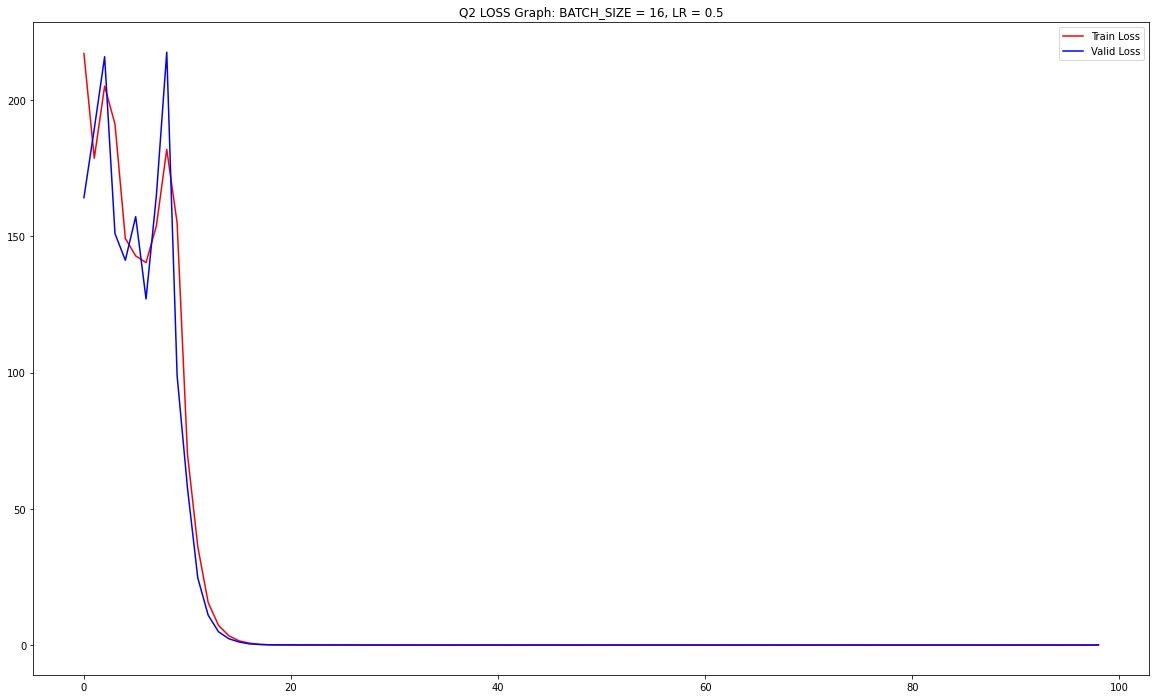

In [122]:
x = np.arange(len(train_loss[1:]))
plt.figure(figsize=(20, 12))
plt.plot(x, train_loss[1:], color='r', label='Train Loss')
plt.plot(x, valid_loss[1:], color='b', label='Valid Loss')
plt.title(f"Q2 LOSS Graph: BATCH_SIZE = {batch_size}, LR = {params['learning_rate']}")
plt.legend()
plt.show()

In [123]:
def test(params, test_loader, path):
    input_size = params['input_size']
    hidden_size = params['hidden_size']
    num_layers = params['num_layers']
    output_size = params['output_size']
    num_outputs = params['num_outputs']
    truths, preds = [[], []], [[], []]
    model = LSTM_multi(input_size, hidden_size, num_layers, output_size, batch_size)
    print(model)
    if MULTI_GPU:
        model = nn.DataParallel(model, device_ids=device_ids)
    model.load_state_dict(torch.load(path)['model'])
    model.to(device)
    
    model.eval()
    for X, y in tqdm(test_loader):
        X = X.to(device)
        for k in range(num_outputs):
            truths[k].extend(y[:, k, :].view(-1).cpu().numpy())
        with torch.no_grad():
            y_hat = model(X)
            for k in range(num_outputs):
                preds[k].extend(y_hat[k, :, :].view(-1).cpu().numpy())
    truths, preds = np.array(truths), np.array(preds)
    for vals in [truths, preds]:
        vals[0] = vals[0] * (test_max_power_range[1] - test_max_power_range[0]) + test_max_power_range[0]
        vals[1] = vals[1] * (test_max_tick_range[1] - test_max_tick_range[0]) + test_max_tick_range[0]
    scores = pd.DataFrame(columns=['MAPE', 'MAE', 'MSE', 'R2 Score'])
    for k in range(num_outputs):
        scores.loc[k, 'MAPE'] = mape(truths[k], preds[k])
        scores.loc[k, 'MAE'] = MAE(truths[k], preds[k])
        scores.loc[k, 'MSE'] = MSE(truths[k], preds[k])
        scores.loc[k, 'R2 Score'] = r2_score(truths[k], preds[k])
    return truths, preds, scores

In [124]:
truths, preds, scores = test(params, test_loader, 'model_min.pth')

LSTM_multi(
  (lstm): LSTM(85, 512, num_layers=20, batch_first=True)
  (linear_pred): Linear(in_features=512, out_features=1, bias=True)
  (linear_time): Linear(in_features=512, out_features=1, bias=True)
)


100%|██████████| 15/15 [00:00<00:00, 35.42it/s]


In [127]:
scores

,MAPE,MAE,MSE,R2 Score
0,16.032737,43237.542969,2493509632.0,-2.124081
1,136.054862,16.974518,455.317413,-1.869942


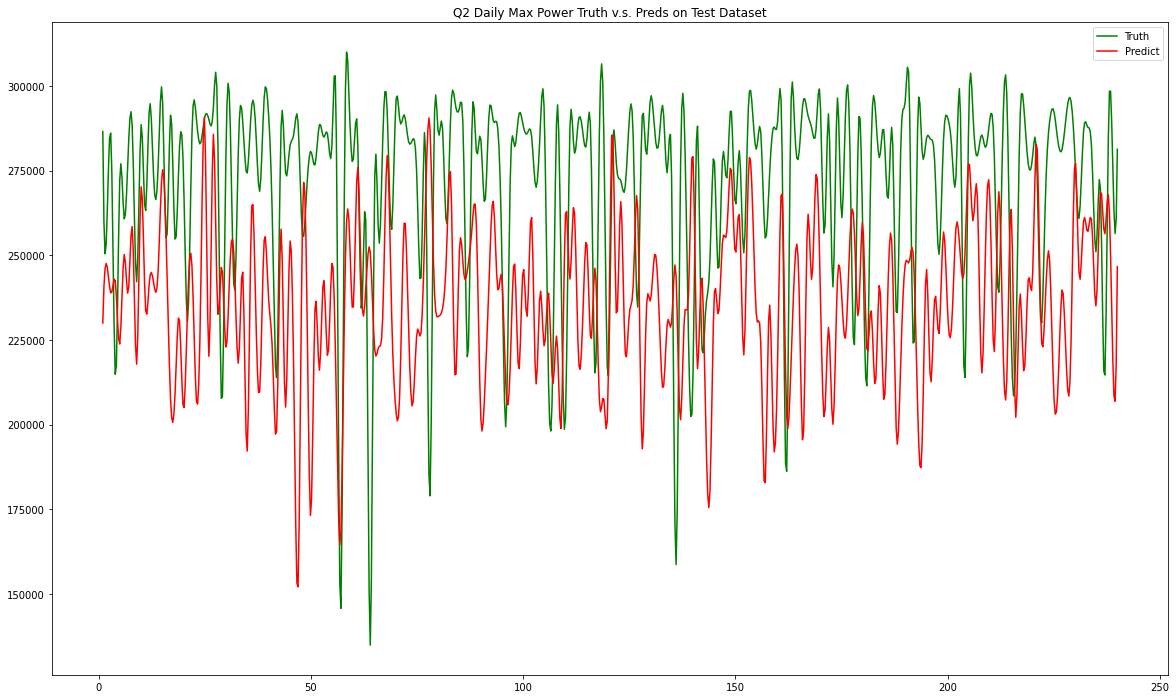

In [125]:
x = [i for i in range(1, len(truths[0]) + 1)]
x_smth = np.linspace(np.min(x), np.max(x), 900)
truths_smth = make_interp_spline(x, truths[0])(x_smth)
preds_smth = make_interp_spline(x, preds[0])(x_smth)
plt.figure(figsize=(20, 12))
plt.plot(x_smth, truths_smth, color='g', label='Truth')
plt.plot(x_smth, preds_smth, color='r', label='Predict')
plt.legend()
plt.title('Q2 Daily Max Power Truth v.s. Preds on Test Dataset')
plt.show()

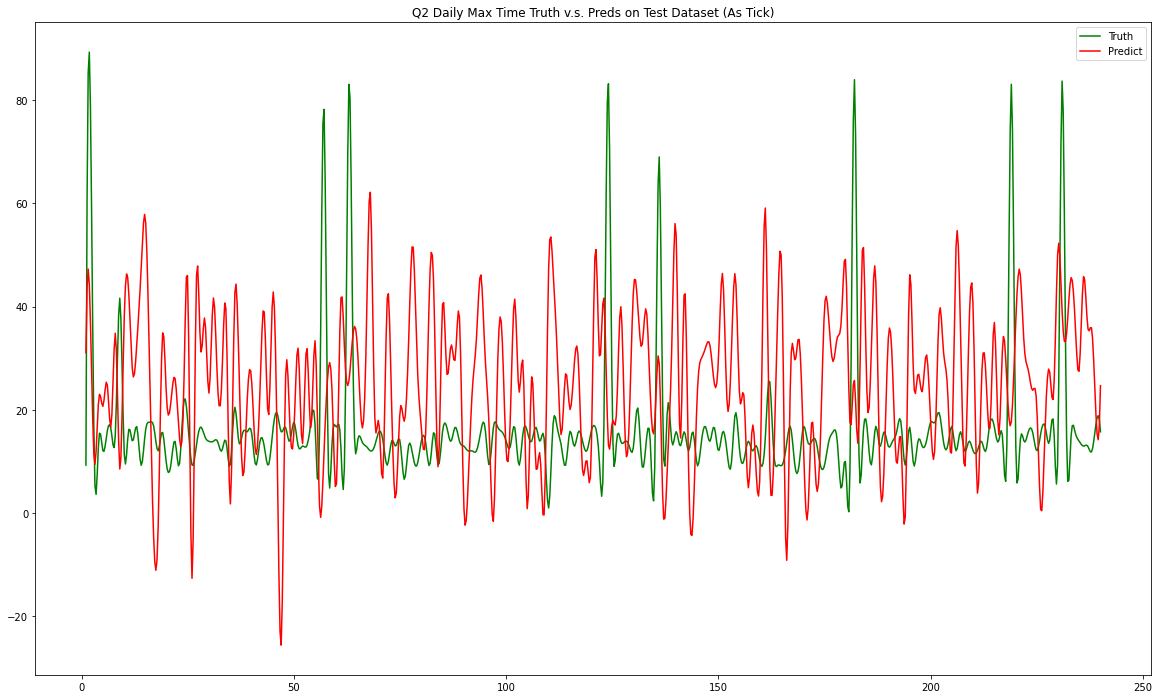

In [126]:
x = [i for i in range(1, len(truths[1]) + 1)]
x_smth = np.linspace(np.min(x), np.max(x), 900)
truths_smth = make_interp_spline(x, truths[1])(x_smth)
preds_smth = make_interp_spline(x, preds[1])(x_smth)
plt.figure(figsize=(20, 12))
plt.plot(x_smth, truths_smth, color='g', label='Truth')
plt.plot(x_smth, preds_smth, color='r', label='Predict')
plt.legend()
plt.title('Q2 Daily Max Time Truth v.s. Preds on Test Dataset (As Tick)')
plt.show()